# LIBRERIAS Y FUNCIONES NECESARIAS

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgb
import scorecardpy as sc
import xgboost as xgb

from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif

from scorecardpy import woebin, woebin_ply, scorecard

pd.set_option('display.max_columns', None)

## Funciones descriptivas y de evaluación de desempeño

In [2]:
#### FUNCIONES A UTILIZAR PARA DESCRIBIR Y EVALUAR MODELOS ####

############################### FUNCIÓN DE ANALISIS DESCRIPTIVO ##################################        

def analisis_desc(df, var_obj):

    %matplotlib inline

    # 1. Visualizar las primeras filas del dataset
    print("----- Primeras 5 filas del dataset -----")
    print(df.head())

    # 2. Información general del dataset: tipos de datos y presencia de valores nulos
    print("\n----- Información del dataset -----")
    df.info()

    # 3. Estadísticas descriptivas de todas las variables (incluyendo las categóricas)
    print("\n----- Estadísticas descriptivas -----")
    print(df.describe(include='all'))

    # 4. Matriz de correlación (solo para columnas numéricas)
    print("\n----- Matriz de Correlación (Columnas Numéricas) -----")
    # Seleccionar solo las columnas numéricas
    df_numeric = df.select_dtypes(include=[np.number])
    corr_matrix = df_numeric.corr()
    print(corr_matrix)

    # 5. Imprimir correlaciones individuales ordenadas para cada variable numérica
    #print("\n----- Correlaciones ordenadas por variable -----")
    #for col in corr_matrix.columns:
        #print(f"\nCorrelaciones de la variable '{col}':")
        #sorted_corr = corr_matrix[col].sort_values(ascending=False)
        #print(sorted_corr)

    # 6. Verificar la cantidad de valores nulos en cada columna
    print("\n----- Valores nulos por columna -----")
    print(df.isnull().sum())

    # 7. Distribución de la variable respuesta
    if var_obj in df.columns:
        print(f"\n----- Distribución de la variable {var_obj} -----")
        print(df[var_obj].describe())
    else:
        print(f"\nNo se encontró la variable {var_obj} en el dataset.")

    # 8. Distribución de otras variables categóricas 
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print("\n----- Distribución de variables categóricas -----")
        for col in categorical_cols:
            print(f"\nDistribución de la variable '{col}':")
            print(df[col].value_counts())
    else:
        print("\nNo se encontraron variables categóricas adicionales.")

    # 9. Análisis adicional: Generar resumen de estadísticas para cada columna individual
    #print("\n----- Resumen de cada variable -----")
    #for col in df.columns:
        #print(f"\nResumen para la variable '{col}':")
        #print(df[col].describe())

############################## FUNCIÓN DE METRICAS DE DESEMPEÑO ##################################        
        
def metricas_desempeño(XTest, yTest, modelo):

    nombre_modelo = str(modelo)
    predicciones=modelo.predict(XTest)
    prediccionesProb=modelo.predict_proba(XTest)

    # Calculo del error MSE para modelos de clasificación
    
    error=0
    for i in range(0,len(yTest)):
        if(yTest[i]!=predicciones[i]):
            error+=1/len(yTest)
            
    print(f"{'.' * 90}","\n")
    print(f'El error de clasificación para {nombre_modelo} en la muestra de test es:')
    print(error,"\n")
    print(f"{'.' * 90}","\n")

    # Calculo de la matriz de confusión
    
    print(confusion_matrix(y_true=yTest, y_pred=predicciones),"\n")
    print(f"{'.' * 90}","\n")

    # Calculo de la metrica Accuracy 
    
    accuracy = accuracy_score(y_true=yTest, y_pred=predicciones)
    
    print(f'El valor de accuracy para el modelo {nombre_modelo} es:')
    print(accuracy,"\n")
    print(f"{'.' * 90}","\n")

    # Calculo de la metrica Precision 
    
    precision = precision_score(y_true=yTest, y_pred=predicciones)
    
    print(f'El valor de precision para el modelo {nombre_modelo} es:')
    print(precision,"\n")
    print(f"{'.' * 90}","\n")

    # Calculo de la metrica F1-Score 
    
    f1 = f1_score(y_true=yTest, y_pred=predicciones)
    
    print(f'El valor de F1-Score para el modelo {nombre_modelo} es:')
    print(f1,"\n")
    print(f"{'.' * 90}","\n")
    
    # Calculo de la curva ROC y el AUC 
    
    fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionesProb[:,1], pos_label=1)
    AUC=metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print(f'El valor de AUC para el modelo {nombre_modelo} es:')
    print(AUC,"\n")
    print(f"{'.' * 90}","\n")

    # Comparación de metricas

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title("Comparación de métricas")
    ejeX = ['Accuracy', 'Precision','AUC']
    ejeY = [accuracy,precision,AUC]
    ax.bar(ejeX,ejeY)
    def addlabels(x,y,plotP):
        for i in range(len(x)):
            plotP.text(i,y[i],y[i])
    addlabels(ejeX,ejeY,plt)
    plt.show()
        
    return error, accuracy, precision, AUC, f1

######################## FUNCIÓN DE HISTOGRAMA, CORRELOGRAMAS ######################        

def funcion_corr(df, var_obj):

    XTotal = df.drop([var_obj], axis = 1)
    yTotal = df[var_obj]
    
    # Historgrama de la variable respuesta
    
    plt.hist(yTotal, bins='auto')
    mensaje = ['Histograma de la variable de respuesta']
    plt.title(" ".join(mensaje))
    plt.show()
    
    # Correlogramas
    
    XTotal=pd.DataFrame(XTotal)
    sns.pairplot(XTotal, kind="scatter")
    plt.show()

######################### FUNCIÓN DE PARTICION EN TRAIN Y TEST ########################    

def train_test_f(df, var_obj):
    
    XTotal = df.drop([var_obj], axis = 1)
    yTotal = df[var_obj]
    
    #Particion de las bases en Train y Test
    
    XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.3, stratify=yTotal, random_state=42)

    # Transofrmación de yTrain en valores 1 y 0

    label_encoder = LabelEncoder()
    yTrain = yTrain.values.ravel()
    yTrain = label_encoder.fit_transform(yTrain)
    
    yTest = yTest.values.ravel()
    yTest = label_encoder.transform(yTest)
    
    return XTrain, XTest, yTrain, yTest

#################### FUNCIÓN DE ESTANDARIZACION DE VARIABLES NUMERICAS Y CATEGORICAS #####################        
#def custom_combiner(feature_name, category):
#    return f"{feature_name}.{category}"

def estandarizacion(XTrain, XTest):
    # Identificar las columnas numéricas y categóricas
    num_cols = XTrain.select_dtypes(include=['float64', 'int64', 'int32']).columns
    cat_cols = XTrain.select_dtypes(include=['category', 'object']).columns

    XTrain_sc = XTrain.copy()
    XTest_sc = XTest.copy()

    # Diccionarios para almacenar los escaladores y codificadores
    scalers = {}
    encoders = {}

    # --- Ajustar y transformar columnas numéricas con MinMaxScaler ---
    for col in num_cols:
        # Crear y ajustar el escalador
        scaler = MinMaxScaler()
        XTrain_sc[col] = scaler.fit_transform(XTrain_sc[[col]])  # Ajustar y transformar
        XTest_sc[col] = scaler.transform(XTest_sc[[col]])        # Solo transformar

        # Guardar el escalador como objeto
        scalers[col] = scaler

    # Crear una carpeta para guardar los escaladores
    folder_name_sc = "scalers_folder"
    if not os.path.exists(folder_name_sc):
        os.makedirs(folder_name_sc)  # Crear la carpeta si no existe

    # Guardar los escaladores como objetos
    for col, scaler in scalers.items():
        file_path = os.path.join(folder_name_sc, f"{col}_scaler.pkl")
        joblib.dump(scaler, file_path)  # Guarda el objeto MinMaxScaler, no un arreglo NumPy

    # --- Codificar columnas categóricas con OneHotEncoder ---
    for col in cat_cols:
        # Crear y ajustar el codificador
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        
        # Codificar las columnas en XTrain
        encoded_train = encoder.fit_transform(XTrain_sc[[col]].astype(str))
        encoded_train_df = pd.DataFrame(
            encoded_train, 
            columns=encoder.get_feature_names_out([col]), 
            index=XTrain_sc.index
        )
        XTrain_sc = XTrain_sc.drop(columns=[col]).join(encoded_train_df)

        # Codificar las columnas en XTest usando el encoder ajustado en XTrain
        encoded_test = encoder.transform(XTest_sc[[col]].astype(str))
        encoded_test_df = pd.DataFrame(
            encoded_test, 
            columns=encoder.get_feature_names_out([col]), 
            index=XTest_sc.index
        )
        XTest_sc = XTest_sc.drop(columns=[col]).join(encoded_test_df)

        # Guardar el codificador
        encoders[col] = encoder

    # Crear una carpeta para guardar los OneHotEncoders
    folder_name_enc = "encoders_folder"
    if not os.path.exists(folder_name_enc):
        os.makedirs(folder_name_enc)  # Crear la carpeta si no existe

    # Guardar los encoders como objetos
    for col, encoder in encoders.items():
        file_path = os.path.join(folder_name_enc, f"{col}_encoder.pkl")
        joblib.dump(encoder, file_path, protocol=2)

    # --- Devolvemos los datos transformados y los diccionarios de escaladores y encoders cargados ---
    return XTrain_sc, XTest_sc, scalers, encoders


## Función ejecución modelo de clasificación LightGBM

In [3]:
def modelo_LightGBM(df_X, df_y):

    # Modelo a utilizar
    model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1) # Estos parametros solo silencian los mensajes Info y Warning
        
    # Utilizar la búsqueda de hiperparámetros
    param_grid = {
        'num_leaves': [31, 50],
        'max_depth': [-1, 15, 20],
        'learning_rate': [0.05, 0.1, 0.15],
        'n_estimators': [100, 200]
    }
    
    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5, 
        scoring = 'recall',  # Métrica de evaluación
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(df_X, df_y)

    return grid_search

## Función personalizada creación de variables por servicios adquiridos

In [4]:
def const_vars_serv(df, var):

    # Separar el contenido de la variable 'PQT_MAS_COMPRADO' por el signo "+"
    df_prueba = df[[var, 'CHURN']].copy()
    
    df_prueba[var] = df_prueba[var].str.lower()
    
    df_split = df_prueba[var].str.split('+', expand=True)
    
    df_split.columns = ['Componente_1', 'Componente_2', 'Componente_3', 'Componente_4', 'Componente_5']
    
    # Crear un diccionario para almacenar los resultados
    conteos_categorias = {}
    
    # Iterar sobre las columnas y guardar los conteos en el diccionario
    for col in ['Componente_1', 'Componente_2', 'Componente_3', 'Componente_4', 'Componente_5']:
        print(f"Conteo de categorías para {col}:")
        conteos_categorias[col + '_list'] = df_split[col].value_counts()  # Guardar el conteo en el diccionario
        print(conteos_categorias[col + '_list'])  # Mostrar el conteo
        print("\n")
    
    # Crear una única lista con todos los elementos de las 5 listas
    todos_los_elementos = []
    
    for key, conteo in conteos_categorias.items():
        todos_los_elementos.extend(conteo.index)  # Agregar los índices (categorías) de cada serie a la lista
    
    # Remover duplicados, si es necesario
    todos_los_elementos = list(set(todos_los_elementos))
    
    # Mostrar la lista resultante
    todos_los_elementos
        
    for elemento in todos_los_elementos:
        df_prueba[elemento] = df_prueba[var].apply(lambda x: 1 if elemento in str(x) else 0)

    # Modificaciones inciales para lectura correcta

    XTrain_mod_arbol = df_prueba.drop([var, 'CHURN'], axis = 1)
    yTrain = df_prueba['CHURN']
    
    # Guardar nombres originales de las columnas
    nombres_originales = XTrain_mod_arbol.columns.tolist()
    
    # Crear un DataFrame a partir de la lista nombres_originales
    df_nombres = pd.DataFrame(nombres_originales, columns=['Nombre'])
    
    # Agregar una columna 'Col_Indice' con números del 0 al total de columnas
    df_nombres['Feature'] = range(len(XTrain_mod_arbol.columns))
    
    # Asegúrate de que las longitudes coincidan
    if len(df_nombres) == len(XTrain_mod_arbol.columns):
        # Reemplazar 'Col_Indice' con los nombres de las columnas de XTrain_mod_arbol
        XTrain_mod_arbol.columns = df_nombres['Feature']
    else:
        print("Error: Las longitudes de df_nombres y las columnas de XTrain_mod_arbol no coinciden.")

    # Aplicacion del modelo LightGBM para encontrar los mejores parametros y variables
    print("---------- Comienza Ejecucion modelo LightGBM ----------")

    # Identificar columnas con tipo 'object'

    grid_search_lgbm = modelo_LightGBM(XTrain_mod_arbol, yTrain)

    print("---------- Finaliza Ejecucion modelo LightGBM ----------")

    # Obtener el modelo óptimo ajustado por GridSearchCV
    best_lgbm_model = grid_search_lgbm.best_estimator_
    
    # Extraer las importancias de las características
    feature_importances = best_lgbm_model.feature_importances_
    
    # Suponiendo que tienes una lista de nombres de las características
    feature_names = XTrain_mod_arbol.columns if isinstance(XTrain_mod_arbol, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]
    
    # Crear un DataFrame para ordenar y visualizar
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)
    
    importance_df = importance_df.merge(df_nombres, on = 'Feature', how = 'left')
    corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()
    
    selvars = importance_df[importance_df['Importance'] >= corte]
    selvars = selvars['Nombre'].tolist()

    print("---------- Las variables selecionadas por servicios adquiridos son ----------")

    print(selvars)

    importance_df_red = importance_df[importance_df['Nombre'].isin(selvars)]
    
    # Visualizar con un gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df_red["Nombre"], importance_df_red["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance (LightGBM)")
    plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
    plt.show()
    
    return selvars

## Función personalizada para crear variables de tendencias

In [5]:
# Crear una función de tendencia
def new_vars_trend(df, col_trs, var_list):

    # A las variables de paquetes adquiridos se pone todo en minúsculas
    var_list = ['PQT_MAS_COMPRADO', 'pqt_mas_comprado_M.1', 'pqt_mas_comprado_M.2', 'pqt_mas_comprado_M.3']
    
    for var in var_list:
        df[var] = df[var].astype(str).str.lower()
    
    # Diccionario con las variables y listas correspondientes
    vars_dict = {
        'PQT_MAS_COMPRADO': vars_PQT_MAS_COMPRADO,
        'pqt_mas_comprado_M.1': vars_PQT_MAS_COMPRADO_M1,
        'pqt_mas_comprado_M.2': vars_PQT_MAS_COMPRADO_M2,
        'pqt_mas_comprado_M.3': vars_PQT_MAS_COMPRADO_M3
    }
    
    # Construcción de las variables de servicios adquiridos por paquete
    for var, elementos in vars_dict.items():
        for elemento in elementos:
            df[f'{elemento}_{var.split(".")[1] if "." in var else "M"}'] = df[var].apply(lambda x: 1 if elemento in str(x) else 0).astype(bool)

    
    for col in col_trs:
        # Valores de tiempo (independientes) y lista de variables
        time = [3, 2, 1]
        vars_time = [f'{col}_M-1', f'{col}_M-2', f'{col}_M-3']
        
        # Valores de [f'PCA_{num}' for num in Vars_PCA]
        rev_total = [df[f'{col}_M-1'], df[f'{col}_M-2'], df[f'{col}_M-3']]
        # Calcular la pendiente usando np.polyfit
        coeficientes = np.polyfit(time, rev_total, 1)
        
        df[f'{col}_PEND'] = coeficientes[0]
        df['ratio_M2_M3'] = np.nan_to_num(df[f'{col}_M-2'] / df[f'{col}_M-3'], nan=0, posinf=0, neginf=0)
        df['ratio_M1_M2'] = np.nan_to_num(df[f'{col}_M-1'] / df[f'{col}_M-2'], nan=0, posinf=0, neginf=0)
        df[f'{col}_TEND'] = np.where((df[f'{col}_PEND'] > 0) & (df['ratio_M2_M3'] > 1.4) | (df['ratio_M1_M2']  > 1.4), 'AUMENTA', 
                                        np.where((df[f'{col}_PEND'] < 0) & ((df['ratio_M2_M3'] > 0) & (df['ratio_M2_M3'] < 0.6)) | ((df['ratio_M1_M2'] > 0) & (df['ratio_M1_M2']  < 0.6)), 'DISMINUYE', 'IGUAL')
                                       )
        df[f'{col}_MEAN_3M'] = df[vars_time].mean(axis = 1)
        df[f'{col}_MIN_3M'] = df[vars_time].min(axis = 1)
        df[f'{col}_MAX_3M'] = df[vars_time].max(axis = 1)
        
        df = df.drop(columns=[f'{col}_PEND', 'ratio_M2_M3', 'ratio_M1_M2'])
    
    return df

# CARGA DE LA BASE DE DATOS

In [6]:
# Carga del parquet 
df_churn = pd.read_parquet('df_prueba.parquet.gzip', engine='pyarrow')

# Clientes que generen un revenue Total mayor a 1.500 

df_churn = df_churn[df_churn['REV_TOTAL'] > 1500]
df_churn['CHURN'] = df_churn['TIPO'].apply(lambda x: 1 if x == 'Churn' else 0).astype(object)
df_churn['PQT_MAS_COMPRADO'] = df_churn['PQT_MAS_COMPRADO'].astype('category')
df_churn = df_churn.replace([None, 'nan', 'NaN'], np.nan)

df_churn

/var/folders/hz/r205qsb53pz1qq80w8gzwjvm0000gn/T/ipykernel_7070/4284145067.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_churn = df_churn.replace([None, 'nan', 'NaN'], np.nan)


,ID,TIPO,RAZON,ACTIVATION_CHANNEL,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,CITY,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,PQT_MAS_COMPRADO,qty_pqt_M.1,pqt_mas_comprado_M.1,qty_pqt_M.2,pqt_mas_comprado_M.2,qty_pqt_M.3,pqt_mas_comprado_M.3,CHURN
0,1,Base,Base,DISTRIBUIDORES,9.0,MOBILE,4G,4G,Y,N,N,N,SMARTPHONE,BOGOTA,"BOGOTÁ, D. C.","BOGOTÁ, D.C.",N,Y,N,0.0,0,0,0,0.0,0.0,0.0,0.0,25061.0,0,0,0,29.0,0,0,0,25032.0,0,0,0,0,7.0,0,0,0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,0,0,7.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,2865.0,0,0,0,0.0,0,0,0,22167.0,0,0,0,0.0,0,0,0,2119377.5,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,Base,Base,DISTRIBUIDORES,4.0,MOBILE,4G,4G,Y,Y,Y,Y,SMARTPHONE,SUR,CAUCA,CAJIBÍO,Y,N,N,3.0,2,1,2,15500.0,9000.0,3000.0,13000.0,13100.0,7778,2825,2712,136.0,251,316,203,12964.0,7527,2509,2509,0,23.0,22,71,24,26.9,27.1,168.1,26.1,0.0,1.0,0.0,1.0,39.0,55,68,52,35.5,29.7,43.4,51.1,3.0,0,0,2,0.0,0.0,0.0,1892.0,1099,366,366,0.0,0,0,0,11071.0,6429,2143,2143,0.0,0,0,0,4250298.3,6330480.2,5945400.3,5027070.5,CORE,CORE,CORE,CORE,0.0,0,10,0,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,2.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,0
2,3,Base,Base,DISTRIBUIDORES,3.0,MOBILE,3G,2G,Y,Y,Y,N,FEATURE PHONE,SUR,RISARALDA,SANTA ROSA DE CABAL,Y,N,N,4.0,6,4,0,29000.0,31000.0,25000.0,0.0,24730.0,29205,26199,0,475.0,3277,4294,0,24255.0,25928,21905,0,0,42.0,58,45,0,35.2,245.0,321.8,0.0,4.0,6.5,3.0,0.0,155.0,339,277,0,356.1,1007.6,1396.4,0.0,2.0,2,4,0,0.0,0.0,0.0,3541.0,3785,3442,0,0.0,0,0,0,20714.0,22143,18361,0,0.0,0,101,0,14315640.3,5847807.2,6425063.0,0.0,CORE,CORE,CORE,NO CORE,0.0,0,0,0,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,6.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,NaN,NaN,0
3,4,Base,Base,DISTRIBUIDORES,6.0,MOBILE,4G,4G,Y,Y,Y,Y,SMARTPHONE,ANDINA,ANTIOQUIA,APARTADÓ,Y,N,N,4.0,5,4,5,40500.0,35000.0,29000.0,32000.0,33903.0,29598,24556,30066,30.0,325,7,85,33873.0,29273,24549,29981,0,3.0,22,1,9,2.3,24.6,0.5,6.3,0.0,0.0,0.0,0.0,31.0,89,20,79,24.8,67.3,13.3,82.9,18.0,23,16,21,0.0,0.0,0.0,4945.0,4273,3604,4351,0.0,0,231,2773,28929.0,25000,20714,22857,0.0,0,0,0,8497395.0,10745653.8,10628257.0,7849774.1,CORE,CORE,CORE,CORE,0.0,0,1,1,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,5.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,5.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,0
4,5,Base,Base,DISTRIBUIDORES,4.0,MOBILE,4G,4G,Y,Y,Y,N,SMARTPHONE,ANDINA,ANTIOQUIA,MEDELLÍN,Y,N,N,5.0,3,2,0,32500.0,18000.0,12000.0,0.0,34609.0,18639,14318

In [7]:
# Variable a mantener proporción
columna_objetivo = "CHURN"  # Reemplaza con la variable que quieres mantener proporcional

# Obtener la muestra estratificada
df_muestra, _ = train_test_split(df_churn, test_size=(len(df_churn) - 30) / len(df_churn), stratify=df_churn[columna_objetivo], random_state=42)
df_muestra.to_csv('df_muestra.csv')

In [8]:
list(df_churn.columns)

['ID',
 'TIPO',
 'RAZON',
 'ACTIVATION_CHANNEL',
 'AGEING',
 'BUSINESS_UNIT',
 'TECHNOLOGY',
 'DEVICE_TECHNOLOGY',
 'DATA_USR',
 'DATA_USR_M-1',
 'DATA_USR_M-2',
 'DATA_USR_M-3',
 'DEVICE_TYPE',
 'REGIONAL',
 'DEPARTMENT',
 'CITY',
 'OPENING',
 'GROSS',
 'RECONNECTION',
 'QTY_RCHG',
 'QTY_RCHG_M-1',
 'QTY_RCHG_M-2',
 'QTY_RCHG_M-3',
 'AMNT_RCHG',
 'AMNT_RCHG_M-1',
 'AMNT_RCHG_M-2',
 'AMNT_RCHG_M-3',
 'REV_TOTAL',
 'REV_TOTAL_M-1',
 'REV_TOTAL_M-2',
 'REV_TOTAL_M-3',
 'REV_IN',
 'REV_IN_M-1',
 'REV_IN_M-2',
 'REV_IN_M-3',
 'REV_OUT',
 'REV_OUT_M-1',
 'REV_OUT_M-2',
 'REV_OUT_M-3',
 'ARPU',
 'CALLS_IN',
 'CALLS_IN_M-1',
 'CALLS_IN_M-2',
 'CALLS_IN_M-3',
 'MINUTES_IN',
 'MINUTES_IN_M-1',
 'MINUTES_IN_M-2',
 'MINUTES_IN_M-3',
 'MSG_IN',
 'MSG_IN_M-1',
 'MSG_IN_M-2',
 'MSG_IN_M-3',
 'CALLS_OUT',
 'CALLS_OUT_M-1',
 'CALLS_OUT_M-2',
 'CALLS_OUT_M-3',
 'MINUTES_OUT',
 'MINUTES_OUT_M-1',
 'MINUTES_OUT_M-2',
 'MINUTES_OUT_M-3',
 'MSG_OUT',
 'MSG_OUT_M-1',
 'MSG_OUT_M-2',
 'MSG_OUT_M-3',
 'PCKG_V

In [9]:
tabla_cruzada = pd.crosstab(df_churn['TIPO'], df_churn['RAZON'])
df_churn = df_churn.drop(['TIPO', 'RAZON'], axis = 1)

tabla_cruzada

RAZON,Base,Port Out
TIPO,,
Base,264251,0
Churn,0,3204


In [10]:
# Contar cuántas veces aparece cada ID
id_counts = df_churn['ID'].value_counts()

# Filtrar IDs que se repiten más de una vez
ids_repetidos = id_counts[id_counts > 1].index

# Eliminación de la columna ID
columnas_pers = ['ID', 'CITY']

df_churn_fil = df_churn.drop(columns=columnas_pers)

ids_repetidos

Index([], dtype='int64', name='ID')

In [11]:
# Seleccionar las columnas de tipo 'object'
df_churn_object_cols = [col for col in df_churn_fil.columns if df_churn_fil[col].dtypes == 'object']

# Convertir las columnas seleccionadas a tipo 'category'
for col in df_churn_object_cols:
    df_churn_fil[col] = df_churn_fil[col].astype('category')

# Verificar los cambios
print(df_churn_fil.dtypes)

ACTIVATION_CHANNEL      category
AGEING                   float64
BUSINESS_UNIT           category
TECHNOLOGY              category
DEVICE_TECHNOLOGY       category
                          ...   
qty_pqt_M.2              float64
pqt_mas_comprado_M.2    category
qty_pqt_M.3              float64
pqt_mas_comprado_M.3    category
CHURN                      int64
Length: 100, dtype: object


# EDA (EXPLORATORY DATA ANALYSIS)

## Analisis Descriptivo

In [12]:
analisis_desc(df_churn_fil, 'CHURN')

----- Primeras 5 filas del dataset -----
  ACTIVATION_CHANNEL  AGEING BUSINESS_UNIT TECHNOLOGY DEVICE_TECHNOLOGY  \
0     DISTRIBUIDORES     9.0        MOBILE         4G                4G   
1     DISTRIBUIDORES     4.0        MOBILE         4G                4G   
2     DISTRIBUIDORES     3.0        MOBILE         3G                2G   
3     DISTRIBUIDORES     6.0        MOBILE         4G                4G   
4     DISTRIBUIDORES     4.0        MOBILE         4G                4G   

  DATA_USR DATA_USR_M-1 DATA_USR_M-2 DATA_USR_M-3    DEVICE_TYPE REGIONAL  \
0        Y            N            N            N     SMARTPHONE   BOGOTA   
1        Y            Y            Y            Y     SMARTPHONE      SUR   
2        Y            Y            Y            N  FEATURE PHONE      SUR   
3        Y            Y            Y            Y     SMARTPHONE   ANDINA   
4        Y            Y            Y            N     SMARTPHONE   ANDINA   

      DEPARTMENT OPENING GROSS RECONNECTION  

In [13]:
Nulls_Analisis = pd.DataFrame(df_churn_fil.isnull().sum().reset_index())
Nulls_Analisis.columns = ['Variable', 'Missing_Count'] 

Null_Cols = (Nulls_Analisis[Nulls_Analisis['Missing_Count'] > 0].iloc[:,0]).to_list()
Null_Cols

['ACTIVATION_CHANNEL',
 'DIAS_INACTIVIDAD',
 'QTY_PQT',
 'PQT_MAS_COMPRADO',
 'qty_pqt_M.1',
 'pqt_mas_comprado_M.1',
 'qty_pqt_M.2',
 'pqt_mas_comprado_M.2',
 'qty_pqt_M.3',
 'pqt_mas_comprado_M.3']

In [14]:
if len(Null_Cols) > 0:
        print("\n----- Distribución de variables categóricas -----")
        for col in Null_Cols:
            print(f"\nDistribución de la variable '{col}':")
            print(df_churn_fil[col].value_counts())
        else:
            print("\nNo se encontraron variables categóricas adicionales.")


----- Distribución de variables categóricas -----

Distribución de la variable 'ACTIVATION_CHANNEL':
ACTIVATION_CHANNEL
DISTRIBUIDORES        186213
TIENDAS_PROPIAS        23380
RETAIL                 21283
FUERZA_VD              18192
AUTOACTIVACION          6387
CORPORATIVO             4019
TO BE DETERMINED        3058
INSTITUCIONAL           2260
E-COMMERCE              1773
TELEVENTAS               705
TIENDA_FVD               105
PYME                      57
CANALES_ESPECIALES         2
Name: count, dtype: int64

Distribución de la variable 'DIAS_INACTIVIDAD':
DIAS_INACTIVIDAD
0.0       176780
1.0        29709
2.0        10877
3.0         3795
4.0         2329
           ...  
264.0          1
335.0          1
485.0          1
2230.0         1
956.0          1
Name: count, Length: 410, dtype: int64

Distribución de la variable 'QTY_PQT':
QTY_PQT
1.0     84038
2.0     39170
3.0     34032
4.0     32228
5.0     19088
6.0      8729
7.0      4820
8.0      2470
9.0      1148
10.0      

## Transformación de la Variable 'ACTIVATION_CHANNEL'

In [15]:
# Crear la tabla cruzada
tabla_cruzada = pd.crosstab(df_churn['ACTIVATION_CHANNEL'], df_churn['CHURN'])

# Agregar una columna con el total por fila
tabla_cruzada.columns = ['No Churn', 'Churn']
tabla_cruzada['Total'] = tabla_cruzada.sum(axis=1)
tabla_cruzada['BGI'] = tabla_cruzada['Churn'] / tabla_cruzada['Total']

# Ordenar la tabla por la columna 'Total' de mayor a menor
tabla_cruzada = tabla_cruzada.sort_values(by='Total', ascending=False)

# Mostrar la tabla cruzada ordenada
tabla_cruzada

,No Churn,Churn,Total,BGI
ACTIVATION_CHANNEL,,,,
DISTRIBUIDORES,183706,2507,186213,0.013463
TIENDAS_PROPIAS,23174,206,23380,0.008811
RETAIL,21124,159,21283,0.007471
FUERZA_VD,18055,137,18192,0.007531
AUTOACTIVACION,6326,61,6387,0.009551
CORPORATIVO,3964,55,4019,0.013685
TO BE DETERMINED,3033,25,3058,0.008175
INSTITUCIONAL,2241,19,2260,0.008407
E-COMMERCE,1756,17,1773,0.009588


In [16]:
# Calcular el promedio de conteos
ACTIVATION_CHANNEL_MEAN = df_churn_fil['ACTIVATION_CHANNEL'].value_counts().mean()

# Filtrar las categorías cuyos conteos son mayores al promedio
ACTIVATION_CHANNEL_SELCATS = df_churn_fil['ACTIVATION_CHANNEL'].value_counts()
ACTIVATION_CHANNEL_SELCATS = (ACTIVATION_CHANNEL_SELCATS[ACTIVATION_CHANNEL_SELCATS > ACTIVATION_CHANNEL_MEAN]).index.to_list()

#Adicionando categorias manualmente

categorias_adicionales = ['FUERZA_VD', 'AUTOACTIVACION', 'CORPORATIVO', 'TO BE DETERMINED', 'INSTITUCIONAL', 'E-COMMERCE',
                         'TELEVENTAS', 'TIENDA_FVD']  # Reemplaza con las categorías que desees
ACTIVATION_CHANNEL_SELCATS += categorias_adicionales

# Reemplazar valores nulos con 'MISSING'
df_churn_fil['ACTIVATION_CHANNEL'] = df_churn_fil['ACTIVATION_CHANNEL'].cat.add_categories(['MISSING'])
df_churn_fil['ACTIVATION_CHANNEL'] = df_churn_fil['ACTIVATION_CHANNEL'].fillna('MISSING')

# Creacion de la nueva variable ACTIVATION_CHANNEL_MOD
df_churn_fil['ACTIVATION_CHANNEL_MOD'] = df_churn_fil['ACTIVATION_CHANNEL'].apply(lambda x: x if x in ACTIVATION_CHANNEL_SELCATS else 'OTROS')
df_churn_fil['ACTIVATION_CHANNEL_MOD'] = df_churn_fil['ACTIVATION_CHANNEL_MOD'].astype('category')

# Confirmando el número de missings
df_churn_fil['ACTIVATION_CHANNEL_MOD'].isnull().sum()

0

In [17]:
ACTIVATION_CHANNEL_SELCATS

['DISTRIBUIDORES',
 'TIENDAS_PROPIAS',
 'RETAIL',
 'FUERZA_VD',
 'AUTOACTIVACION',
 'CORPORATIVO',
 'TO BE DETERMINED',
 'INSTITUCIONAL',
 'E-COMMERCE',
 'TELEVENTAS',
 'TIENDA_FVD']

In [18]:
# Crear la tabla cruzada
tabla_cruzada = pd.crosstab(df_churn_fil['ACTIVATION_CHANNEL_MOD'], df_churn_fil['CHURN'])

# Agregar una columna con el total por fila
tabla_cruzada.columns = ['No Churn', 'Churn']
tabla_cruzada['Total'] = tabla_cruzada.sum(axis=1)
tabla_cruzada['BGI'] = tabla_cruzada['Churn'] / tabla_cruzada['Total']

# Ordenar la tabla por la columna 'Total' de mayor a menor
tabla_cruzada = tabla_cruzada.sort_values(by='Total', ascending=False)

# Mostrar la tabla cruzada ordenada
tabla_cruzada

,No Churn,Churn,Total,BGI
ACTIVATION_CHANNEL_MOD,,,,
DISTRIBUIDORES,183706,2507,186213,0.013463
TIENDAS_PROPIAS,23174,206,23380,0.008811
RETAIL,21124,159,21283,0.007471
FUERZA_VD,18055,137,18192,0.007531
AUTOACTIVACION,6326,61,6387,0.009551
CORPORATIVO,3964,55,4019,0.013685
TO BE DETERMINED,3033,25,3058,0.008175
INSTITUCIONAL,2241,19,2260,0.008407
E-COMMERCE,1756,17,1773,0.009588


In [19]:
# Eliminar la variable de la lista de variables con nulos y del dataframe
df_churn_fil = df_churn_fil.drop(['ACTIVATION_CHANNEL'], axis = 1)
Null_Cols.remove('ACTIVATION_CHANNEL')

## Transformación de las demás Variables con Missings

In [20]:
df_churn_fil[df_churn_fil['DIAS_INACTIVIDAD'].isnull()]

,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,PQT_MAS_COMPRADO,qty_pqt_M.1,pqt_mas_comprado_M.1,qty_pqt_M.2,pqt_mas_comprado_M.2,qty_pqt_M.3,pqt_mas_comprado_M.3,CHURN,ACTIVATION_CHANNEL_MOD
0,9.0,MOBILE,4G,4G,Y,N,N,N,SMARTPHONE,BOGOTA,"BOGOTÁ, D. C.",N,Y,N,0.0,0,0,0,0.0,0.0,0.0,0.0,25061.0,0,0,0,29.0,0,0,0,25032.0,0,0,0,0,7.0,0,0,0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,0,0,7.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,2865.0,0,0,0,0.0,0,0,0,22167.0,0,0,0,0.0,0,0,0,2119377.5,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,DISTRIBUIDORES
45,1.0,MOBILE,2G,2G,Y,N,N,N,LOW END,ANDINA,SANTANDER,N,Y,N,1.0,0,0,0,5500.0,0.0,0.0,0.0,4600.0,0,0,0,0.0,0,0,0,4600.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,671.0,0,0,0,0.0,0,0,0,3929.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB 3...,NaN,NaN,NaN,NaN,NaN,NaN,0,DISTRIBUIDORES
64,1.0,MOBILE,2G,2G,Y,N,N,N,LOW END,BOGOTA,"BOGOTÁ, D. C.",N,Y,N,1.0,0,0,0,3500.0,0.0,0.0,0.0,2927.0,0,0,0,0.0,0,0,0,2927.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,427.0,0,0,0,0.0,0,0,0,2500.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,NaN,NaN,NaN,NaN,NaN,NaN,0,DISTRIBUIDORES
153,1.0,MOBILE,2G,2G,Y,N,N,N,LOW END,ANDINA,SANTANDER,N,Y,N,1.0,0,0,0,11000.0,0.0,0.0,0.0,9200.0,0,0,0,0.0,0,0,0,9200.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1343.0,0,0,0,0.0,0,0,0,7857.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 5 GB S...,NaN,NaN,NaN,NaN,NaN,NaN,0,AUTOACTIVACION
243,1.0,MOBILE,2G,4G,Y,N,N,N,SMARTPHONE,SUR,VALLE DEL CAUCA,N,Y,N,1.0,0,0,0,3500.0,0.0,0.0,0.0,3219.0,0,0,0,292.0,0,0,0,2927.0,0,0,0,0,4.0,0,0,0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.0,0,0,0,14.0,0.0,0.0,0.0,1.0,0,0,0,0.0,0.0,0.0,427.0,0,0,0,0.0,0,0,0,2500.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,NaN,0,0,0,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,NaN,NaN,NaN,NaN,NaN,NaN,0,DISTRIBUIDORES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499924,1.0,MOBILE,4G,2G,Y,N,N,N,SMARTPHONE,SUR,CALDAS,N,Y,N,1.0,0,0,0,5000.0,0.0

In [21]:
df_churn_fil[Null_Cols].dtypes

DIAS_INACTIVIDAD         float64
QTY_PQT                  float64
PQT_MAS_COMPRADO        category
qty_pqt_M.1              float64
pqt_mas_comprado_M.1    category
qty_pqt_M.2              float64
pqt_mas_comprado_M.2    category
qty_pqt_M.3              float64
pqt_mas_comprado_M.3    category
dtype: object

In [22]:
# Filtrar columnas que son de tipo float64 o int64
null_numeric_cols = [col for col in Null_Cols if df_churn_fil[col].dtypes in ['float64', 'int64']]
null_category_cols = [col for col in Null_Cols if df_churn_fil[col].dtypes in ['category']]

# Mostrar las columnas seleccionadas
print(null_numeric_cols)

['DIAS_INACTIVIDAD', 'QTY_PQT', 'qty_pqt_M.1', 'qty_pqt_M.2', 'qty_pqt_M.3']


In [23]:
# Modificación de las variables categoricas con nullos

for col_categorica in null_category_cols:
    df_churn_fil[col_categorica] = df_churn_fil[col_categorica].cat.add_categories(['MISSING'])
    df_churn_fil[col_categorica] = df_churn_fil[col_categorica].fillna('MISSING')
    print(df_churn_fil[col_categorica].isnull().sum())

0
0
0
0


In [24]:
# Modificación de las variables numericas con nullos
for col_numerica in null_numeric_cols:
    df_churn_fil[col_numerica] = df_churn_fil[col_numerica].fillna(0)
    print(df_churn_fil[col_numerica].isnull().sum())

0
0
0
0
0


## Confirmación de variables sin valores nulos

In [25]:
# Ejecución de un segundo analisis para confirmación de que ya no hay variables con valores nulos

Nulls_Analisis_2 = pd.DataFrame(df_churn_fil.isnull().sum().reset_index())
Nulls_Analisis_2.columns = ['Variable', 'Missing_Count'] 

Null_Cols_2 = (Nulls_Analisis_2[Nulls_Analisis_2['Missing_Count'] > 0].iloc[:,0]).to_list()
Null_Cols_2

[]

## Transformación de variables de adquisición de paquetes

In [26]:
def transf_var_paquete(df, var_paquetes):

    for var_paquete in var_paquetes:
        tabla_cruzada = pd.crosstab(df[var_paquete], df['CHURN'])
        
        # Agregar una columna con el total por fila
        tabla_cruzada.columns = ['No Churn', 'Churn']
        tabla_cruzada['Total'] = tabla_cruzada.sum(axis=1)
        tabla_cruzada['BGI'] = tabla_cruzada['Churn'] / tabla_cruzada['Total']
        
        # Ordenar la tabla por la columna 'Total' de mayor a menor
        tabla_cruzada = tabla_cruzada.sort_values(by='Total', ascending=False)
        
        # Mostrar la tabla cruzada ordenada
        tabla_cruzada
        
        # Calcular el promedio de conteos
        VAR_PAQUETE_MEAN = df[var_paquete].value_counts().mean()
        
        # Filtrar las categorías cuyos conteos son mayores al promedio
        VAR_PAQUETE_SELCATS = df[var_paquete].value_counts()
        VAR_PAQUETE_SELCATS = (VAR_PAQUETE_SELCATS[VAR_PAQUETE_SELCATS > VAR_PAQUETE_MEAN]).index.to_list()
        
        # Creacion de la nueva variable ACTIVATION_CHANNEL_MOD
        df[f'{var_paquete}_MOD'] = df[var_paquete].apply(lambda x: x if x in VAR_PAQUETE_SELCATS else 'OTROS')
        df[f'{var_paquete}_MOD'] = df[f'{var_paquete}_MOD'].astype('category')
        
        # Confirmando el número de missings
        print(f'------------ Las nuevas categorias para {var_paquete} son: ------------')
        print(df[f'{var_paquete}_MOD'].value_counts())
        print('\n')

    return df

# Seleccion de las variables de paquetes y aplicación de la función de transformación
var_paquetes_sel = ['PQT_MAS_COMPRADO', 'pqt_mas_comprado_M.1', 'pqt_mas_comprado_M.2', 'pqt_mas_comprado_M.3']
df_churn_trasnf = transf_var_paquete(df_churn_fil, var_paquetes_sel)

df_churn_trasnf

------------ Las nuevas categorias para PQT_MAS_COMPRADO son: ------------
PQT_MAS_COMPRADO_MOD
Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB + WA + FB 6d -$6000         60909
Voz Ilimitada + SMS Ilimitados Allnet + 350 MB + WA + FB 2d -$3000         50120
MISSING                                                                    40470
OTROS                                                                      23198
Voz Ilimitada + SMS Ilimitados Allnet + 6 GB + WA + FB 30d -$15000         21121
Voz Ilimitada + SMS Ilimitados Allnet + 500 MB + WA + FB 5d -$3000         20635
Voz Ilimitada + SMS Ilimitados Allnet + 3 GB + WA + FB 10d -$10000         17849
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB + WA + FB 7d -$7000           14888
Voz Ilimitada + SMS Ilimitados Allnet + 1,5 GB + WA + FB 7d ATCK -$5000     7422
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB 3d -$5000                      5984
Voz Ilimitada + SMS Ilimitados Allnet + 1 GB 2d -$3000                      4859
Name: count, 

,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,PQT_MAS_COMPRADO,qty_pqt_M.1,pqt_mas_comprado_M.1,qty_pqt_M.2,pqt_mas_comprado_M.2,qty_pqt_M.3,pqt_mas_comprado_M.3,CHURN,ACTIVATION_CHANNEL_MOD,PQT_MAS_COMPRADO_MOD,pqt_mas_comprado_M.1_MOD,pqt_mas_comprado_M.2_MOD,pqt_mas_comprado_M.3_MOD
0,9.0,MOBILE,4G,4G,Y,N,N,N,SMARTPHONE,BOGOTA,"BOGOTÁ, D. C.",N,Y,N,0.0,0,0,0,0.0,0.0,0.0,0.0,25061.0,0,0,0,29.0,0,0,0,25032.0,0,0,0,0,7.0,0,0,0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0,0,0,7.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,2865.0,0,0,0,0.0,0,0,0,22167.0,0,0,0,0.0,0,0,0,2119377.5,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,0.0,0,0,0,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,0,DISTRIBUIDORES,MISSING,MISSING,MISSING,MISSING
1,4.0,MOBILE,4G,4G,Y,Y,Y,Y,SMARTPHONE,SUR,CAUCA,Y,N,N,3.0,2,1,2,15500.0,9000.0,3000.0,13000.0,13100.0,7778,2825,2712,136.0,251,316,203,12964.0,7527,2509,2509,0,23.0,22,71,24,26.9,27.1,168.1,26.1,0.0,1.0,0.0,1.0,39.0,55,68,52,35.5,29.7,43.4,51.1,3.0,0,0,2,0.0,0.0,0.0,1892.0,1099,366,366,0.0,0,0,0,11071.0,6429,2143,2143,0.0,0,0,0,4250298.3,6330480.2,5945400.3,5027070.5,CORE,CORE,CORE,CORE,0.0,0,10,0,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,2.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,0,DISTRIBUIDORES,Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB...,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...
2,3.0,MOBILE,3G,2G,Y,Y,Y,N,FEATURE PHONE,SUR,RISARALDA,Y,N,N,4.0,6,4,0,29000.0,31000.0,25000.0,0.0,24730.0,29205,26199,0,475.0,3277,4294,0,24255.0,25928,21905,0,0,42.0,58,45,0,35.2,245.0,321.8,0.0,4.0,6.5,3.0,0.0,155.0,339,277,0,356.1,1007.6,1396.4,0.0,2.0,2,4,0,0.0,0.0,0.0,3541.0,3785,3442,0,0.0,0,0,0,20714.0,22143,18361,0,0.0,0,101,0,14315640.3,5847807.2,6425063.0,0.0,CORE,CORE,CORE,NO CORE,0.0,0,0,0,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,6.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,4.0,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,0.0,MISSING,0,DISTRIBUIDORES,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,Voz Ilimitada + SMS Ilimitados Allnet + 2 GB +...,MISSING
3,6.0,MOBILE,4G,4G,Y,Y,Y,Y,SMARTPHONE,ANDINA,ANTIOQUIA,Y,N,N,4.0,5,4,5,40500.0,35000.0,29000.0,32000.0,33903.0,29598,24556,30066,30.0,325,7,85,33873.0,29273,24549,29981,0,3.0,22,1,9,2.3,24.6,0.5,6.3,0.0,0.0,0.0,0.0,31.0,89,20,79,24.8,67.3,13.3,82.9,18.0,23,16,21,0.0,0.0,0.0,4945.0,4273,3604,4351,0.0,0,231,2773,28929.0,25000,20714,22857,0.0,0,0,0,8497395.0,10745653.8,10628257.0,7849774.1,CORE,CORE,CORE,CORE,0.0,0,

In [27]:
df_churn_trasnf['DEPARTMENT'].value_counts()

DEPARTMENT
ANTIOQUIA                                     58252
ATLÁNTICO                                     38835
BOGOTÁ, D. C.                                 31252
BOLÍVAR                                       19979
MAGDALENA                                     13815
VALLE DEL CAUCA                               12988
CÓRDOBA                                       11613
CUNDINAMARCA                                  10920
SANTANDER                                      9911
LA GUAJIRA                                     7901
CESAR                                          7864
SUCRE                                          7746
CALDAS                                         5843
NORTE DE SANTANDER                             5519
TOLIMA                                         4608
RISARALDA                                      4536
CAUCA                                          3044
QUINDÍO                                        2915
NARIÑO                                         2667
B

# INGENIERIA DE DATOS

In [28]:
XTrain, XTest, yTrain, yTest = train_test_f(df_churn_trasnf, 'CHURN')

df_churn_train = XTrain.copy()
df_churn_train['CHURN'] = yTrain

print(df_churn_fil['CHURN'].value_counts())
print(pd.Series(yTrain).value_counts())
print(pd.Series(yTest).value_counts())

CHURN
0    264251
1      3204
Name: count, dtype: int64
0    184975
1      2243
Name: count, dtype: int64
0    79276
1      961
Name: count, dtype: int64


In [29]:
df_churn_train.dtypes

AGEING                       float64
BUSINESS_UNIT               category
TECHNOLOGY                  category
DEVICE_TECHNOLOGY           category
DATA_USR                    category
                              ...   
PQT_MAS_COMPRADO_MOD        category
pqt_mas_comprado_M.1_MOD    category
pqt_mas_comprado_M.2_MOD    category
pqt_mas_comprado_M.3_MOD    category
CHURN                          int64
Length: 104, dtype: object

## Construcción de variables adicionales

Conteo de categorías para Componente_1:
Componente_1
voz ilimitada                            154699
missing                                   28323
60 minutos                                  977
suscripcion 60 minutos                      892
7 min                                       696
30 mb                                       553
100 min                                     298
150 mb 2d -$3000                            220
200 mb total -$1900                         162
suscripcion voz ilimitada                    59
5 min ldi -$3100                             47
50 min                                       44
susripcion voz ilimitada                     35
20 sms allnet -$1200                         32
15 min allnet -$2000                         29
10 min ldi 2d -$5400                         28
65 min                                       16
5 favoritos onnet mes -$7500                 16
2 favoritos onnet mes -$6000                 15
15 min allnet -$1950               

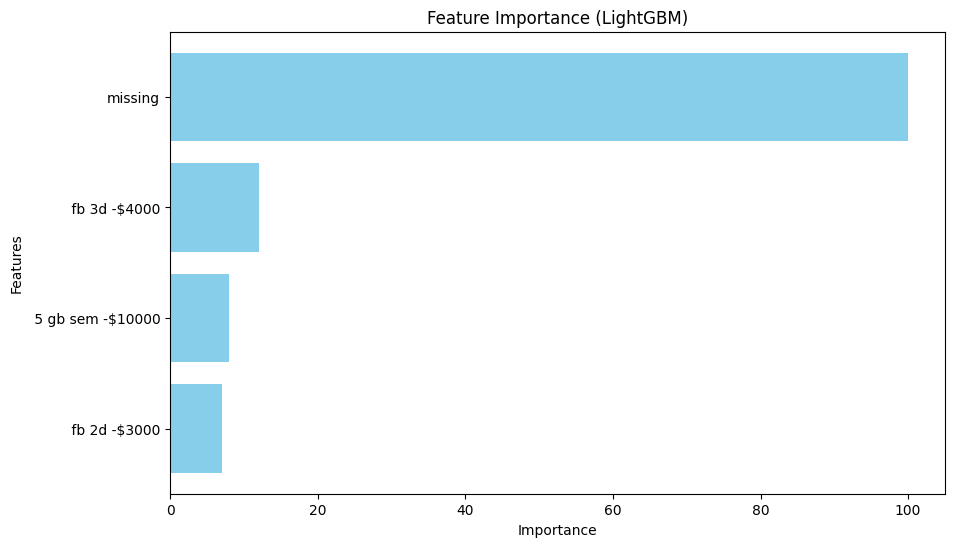

In [30]:
var = 'PQT_MAS_COMPRADO'
vars_PQT_MAS_COMPRADO = const_vars_serv(df_churn_train, var)
np.savetxt("PQT_MAS_COMPRADO.csv", vars_PQT_MAS_COMPRADO, delimiter=",", fmt="%s")

Conteo de categorías para Componente_1:
Componente_1
voz ilimitada                            121844
missing                                   62310
suscripcion 60 minutos                      804
60 minutos                                  678
30 mb                                       465
7 min                                       464
150 mb 2d -$3000                            143
200 mb total -$1900                         135
100 min                                      67
suscripcion voz ilimitada                    65
15 min allnet -$2000                         33
20 sms allnet -$1200                         29
susripcion voz ilimitada                     26
50 min                                       25
5 favoritos onnet mes -$7500                 21
10 min ldi 2d -$5400                         18
2 favoritos onnet mes -$6000                 15
40 mb total -$500                            13
15 min allnet -$1950                         11
sms ilim tarifa especial allnet -$7

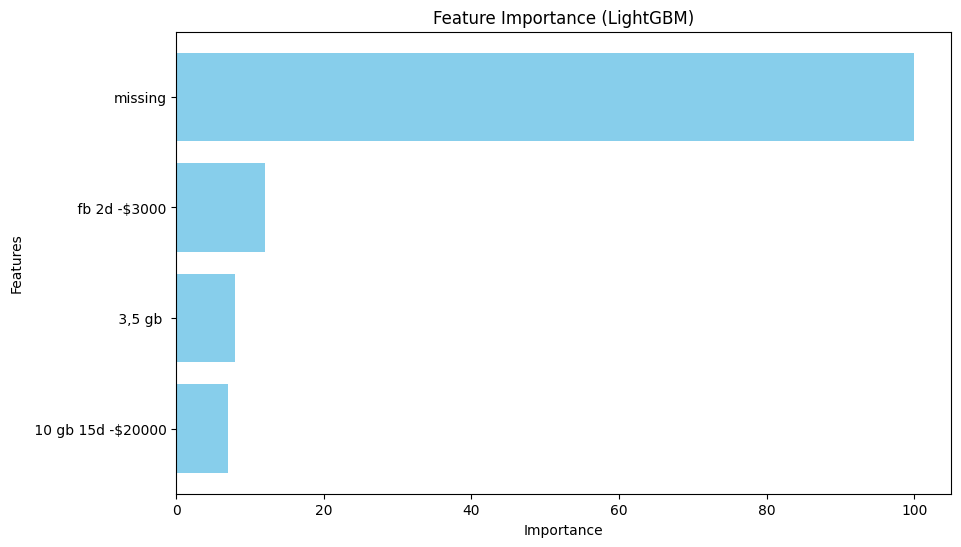

In [31]:
var = 'pqt_mas_comprado_M.1'
vars_PQT_MAS_COMPRADO_M1 = const_vars_serv(df_churn_train, var)
np.savetxt("pqt_mas_comprado_M.1.csv", vars_PQT_MAS_COMPRADO_M1, delimiter=",", fmt="%s")

Conteo de categorías para Componente_1:
Componente_1
voz ilimitada                      113029
missing                             72096
60 minutos                            660
7 min                                 428
suscripcion 60 minutos                311
30 mb                                 223
150 mb 2d -$3000                      143
100 min                                60
200 mb total -$1900                    56
suscripcion voz ilimitada              34
50 min                                 27
10 min ldi 2d -$5400                   22
15 min allnet -$2000                   18
susripcion voz ilimitada               14
40 mb total -$500                      14
15 min allnet -$1950                   12
2 favoritos onnet mes -$6000            9
5 favoritos onnet mes -$7500            9
2 gb total                              9
600 mb total sem -$14900                8
5 min ldi -$3100                        8
5 favoritos 2da bolsa -$7000            6
65 min                 

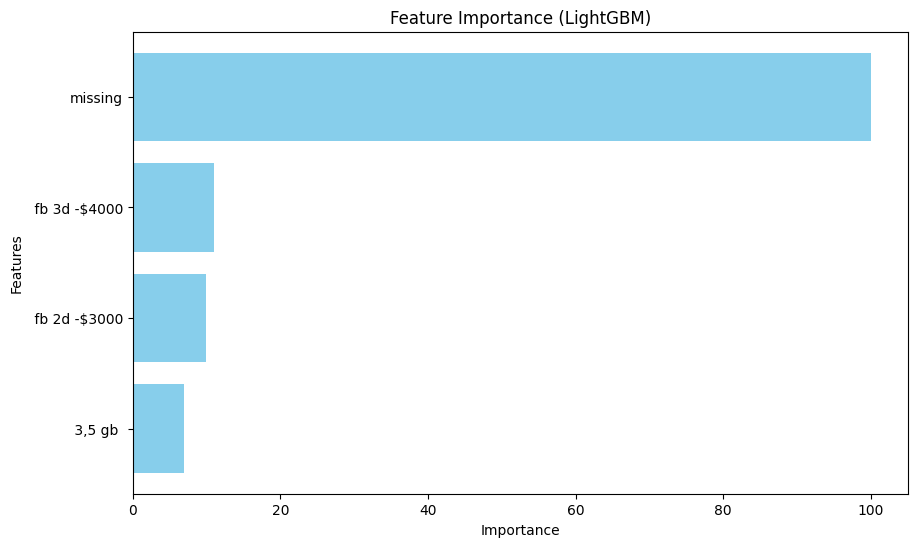

In [32]:
var = 'pqt_mas_comprado_M.2'
vars_PQT_MAS_COMPRADO_M2 = const_vars_serv(df_churn_train, var)
np.savetxt("pqt_mas_comprado_M.2.csv", vars_PQT_MAS_COMPRADO_M2, delimiter=",", fmt="%s")

Conteo de categorías para Componente_1:
Componente_1
voz ilimitada                   104914
missing                          80066
60 minutos                         628
7 min                              451
suscripcion 60 minutos             391
30 mb                              248
150 mb 2d -$3000                   150
100 min                             74
200 mb total -$1900                 68
suscripcion voz ilimitada           37
20 sms allnet -$1200                21
15 min allnet -$2000                20
50 min                              19
10 min ldi 2d -$5400                18
susripcion voz ilimitada            17
5 favoritos onnet mes -$7500        13
5 min ldi -$3100                    11
40 mb total -$500                   11
15 min allnet -$1950                 8
600 mb total sem -$14900             8
2 gb total                           8
65 min                               7
2 favoritos onnet mes -$6000         7
30 min ldi sem -$15600               4
90 min     

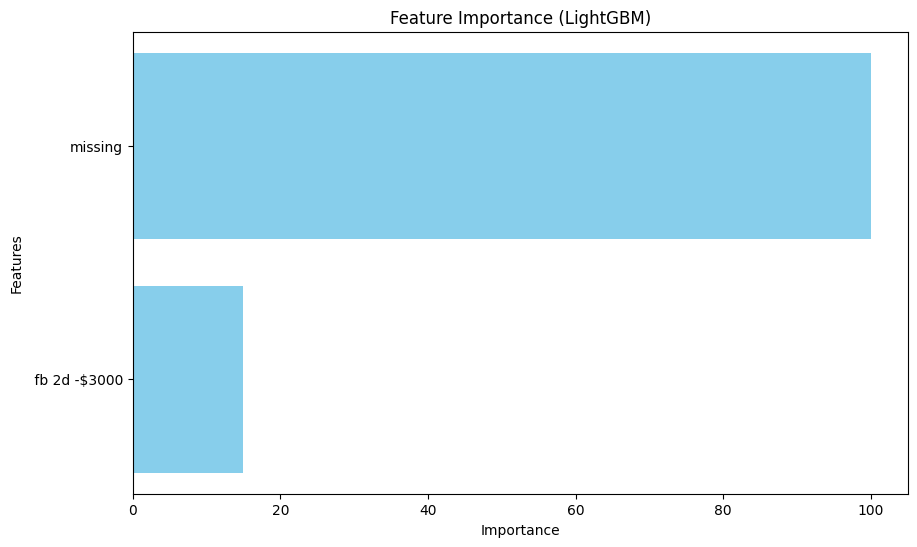

In [33]:
var = 'pqt_mas_comprado_M.3'
vars_PQT_MAS_COMPRADO_M3 = const_vars_serv(df_churn_train, var)
np.savetxt("pqt_mas_comprado_M.3.csv", vars_PQT_MAS_COMPRADO_M3, delimiter=",", fmt="%s")

In [34]:
# Definir columnas sobre las que se aplicara la función de construccion de variables
var_list_pqt = ['PQT_MAS_COMPRADO', 'pqt_mas_comprado_M.1', 'pqt_mas_comprado_M.2', 'pqt_mas_comprado_M.3']
np.savetxt("var_list_pqt.csv", var_list_pqt, delimiter=",", fmt="%s")

col_trans = ['QTY_RCHG', 'AMNT_RCHG', 'REV_TOTAL', 'REV_IN', 'REV_OUT', 'CALLS_IN', 'MINUTES_IN', 'MSG_IN', 'CALLS_OUT', 'MINUTES_OUT',
           'MSG_OUT', 'REV_OUT_COMMUNICATION', 'REV_OUT_ENTERTAIMENT', 'REV_OUT_INFORMATION', 'REV_OUT_SOLUTIONS', 'CONSUMO_DATOS',
           'DIAS_INACTIVIDAD']
np.savetxt("col_trans.csv", col_trans, delimiter=",", fmt="%s")



# Ejecutar la función
df_churn_train_new_vars = new_vars_trend(df_churn_train, col_trans, var_list_pqt)
df_churn_train_new_vars = df_churn_train_new_vars.drop(var_list_pqt, axis = 1)

#print(df_churn_p[df_churn_p['QTY_RCHG_TEND'] == 'AUMENTA'][['QTY_RCHG_M-1', 'QTY_RCHG_M-2', 'QTY_RCHG_M-3', 'QTY_RCHG_TEND',
#                                                           'QTY_RCHG_MEAN_3M', 'QTY_RCHG_MIN_3M', 'QTY_RCHG_MAX_3M']])

In [35]:
df_churn_test = XTest.copy()
df_churn_test['CHURN'] = yTest

# Ejecutar la función
df_churn_test_new_vars = new_vars_trend(df_churn_test, col_trans, var_list_pqt)
df_churn_test_new_vars = df_churn_test_new_vars.drop(var_list_pqt, axis = 1)
df_churn_test_new_vars

,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,qty_pqt_M.1,qty_pqt_M.2,qty_pqt_M.3,ACTIVATION_CHANNEL_MOD,PQT_MAS_COMPRADO_MOD,pqt_mas_comprado_M.1_MOD,pqt_mas_comprado_M.2_MOD,pqt_mas_comprado_M.3_MOD,CHURN,missing_M,fb 3d -$4000_M,5 gb sem -$10000_M,fb 2d -$3000_M,missing_1,fb 2d -$3000_1,"3,5 gb _1",10 gb 15d -$20000_1,missing_2,fb 3d -$4000_2,fb 2d -$3000_2,"3,5 gb _2",missing_3,fb 2d -$3000_3,QTY_RCHG_TEND,QTY_RCHG_MEAN_3M,QTY_RCHG_MIN_3M,QTY_RCHG_MAX_3M,AMNT_RCHG_TEND,AMNT_RCHG_MEAN_3M,AMNT_RCHG_MIN_3M,AMNT_RCHG_MAX_3M,REV_TOTAL_TEND,REV_TOTAL_MEAN_3M,REV_TOTAL_MIN_3M,REV_TOTAL_MAX_3M,REV_IN_TEND,REV_IN_MEAN_3M,REV_IN_MIN_3M,REV_IN_MAX_3M,REV_OUT_TEND,REV_OUT_MEAN_3M,REV_OUT_MIN_3M,REV_OUT_MAX_3M,CALLS_IN_TEND,CALLS_IN_MEAN_3M,CALLS_IN_MIN_3M,CALLS_IN_MAX_3M,MINUTES_IN_TEND,MINUTES_IN_MEAN_3M,MINUTES_IN_MIN_3M,MINUTES_IN_MAX_3M,MSG_IN_TEND,MSG_IN_MEAN_3M,MSG_IN_MIN_3M,MSG_IN_MAX_3M,CALLS_OUT_TEND,CALLS_OUT_MEAN_3M,CALLS_OUT_MIN_3M,CALLS_OUT_MAX_3M,MINUTES_OUT_TEND,MINUTES_OUT_MEAN_3M,MINUTES_OUT_MIN_3M,MINUTES_OUT_MAX_3M,MSG_OUT_TEND,MSG_OUT_MEAN_3M,MSG_OUT_MIN_3M,MSG_OUT_MAX_3M,REV_OUT_COMMUNICATION_TEND,REV_OUT_COMMUNICATION_MEAN_3M,REV_OUT_COMMUNICATION_MIN_3M,REV_OUT_COMMUNICATION_MAX_3M,REV_OUT_ENTERTAIMENT_TEND,REV_OUT_ENTERTAIMENT_MEAN_3M,REV_OUT_ENTERTAIMENT_MIN_3M,REV_OUT_ENTERTAIMENT_MAX_3M,REV_OUT_INFORMATION_TEND,REV_OUT_INFORMATION_MEAN_3M,REV_OUT_INFORMATION_MIN_3M,REV_OUT_INFORMATION_MAX_3M,REV_OUT_SOLUTIONS_TEND,REV_OUT_SOLUTIONS_MEAN_3M,REV_OUT_SOLUTIONS_MIN_3M,REV_OUT_SOLUTIONS_MAX_3M,CONSUMO_DATOS_TEND,CONSUMO_DATOS_MEAN_3M,CONSUMO_DATOS_MIN_3M,CONSUMO_DATOS_MAX_3M,DIAS_INACTIVIDAD_TEND,DIAS_INACTIVIDAD_MEAN_3M,DIAS_INACTIVIDAD_MIN_3M,DIAS_INACTIVIDAD_MAX_3M
97612,1.0,MOBILE,2G,4G,Y,N,N,N,SMARTPHONE,ANDINA,ANTIOQUIA,N,Y,N,1.0,0,0,0,3500.0,0.0,0.0,0.0,2927.0,0,0,0,0.0,0,0,0,2927.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,427.0,0,0,0,0.0,0,0,0,2500.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,0.0,0,0,0,1.0,0.0,0.0,0.0,DISTRIBUIDORES,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,MISSING,MISSING,MISSING,0,False,False,False,False,True,False,False,False,True,False,False,False,True,False,IGUAL,0.000000,0,0,IGUAL,0.000000,0.0,0.0,IGUAL,0.000000,0,0,IGUAL,0.000000,0,0,IGUAL,0.000000,0,0,IGUAL,0.000000,0,0,IGUAL,0.000000,0.0,0.0,IGUAL,0.000000,0.0,0.0,IGUAL,0.000000,0,0,IGUAL,0.000000,0.0,0.0,IGUAL,0.000000,0,0,IGUAL,0.000000,0,0,IGUAL,0.0,0,0,IGUAL,0.000000,0,0,IGUAL,0.0,0,0,IGUAL,0.000000e+00,0.0,0.0,IGUAL,0.000000,0,0
91799,11.0,MOBILE,4G,2G,Y,Y,Y,Y,SMARTPHONE,SUR,CALDAS,Y,N,N,1.0,1,1,1,16000.0,15000.0,15000.0,15000.0,13542.0,12770,12883,12985,160.0,224,337,439,13382.0,12546,125

# SELECCION DE VARIABLES POR EL MODELO LIGHTGBM

In [36]:
XTrain = df_churn_train_new_vars.drop('CHURN', axis = 1)
XTest_1 = df_churn_test_new_vars.drop('CHURN', axis = 1)

## Variables numericas

In [37]:
# Creación de una lista de variables númericas
num_cols = XTrain.select_dtypes(include=['float64', 'int64']).columns

XTrain_num = XTrain[num_cols]
#XTest_num = XTest[num_cols]

#Ejecución de un modelo LightGBM para encontrar las mejores variables numericas
grid_search_lgbm_num = modelo_LightGBM(XTrain_num, yTrain)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


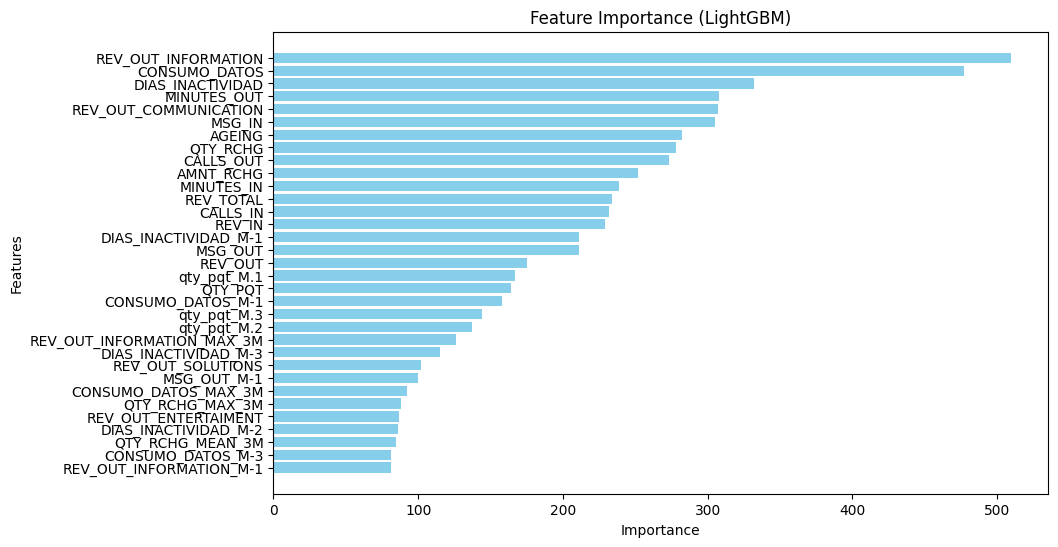

In [38]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_num.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_num.columns if isinstance(XTrain_num, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_num = importance_df[importance_df['Importance'] >= corte]
selvars_num = selvars_num['Feature'].tolist()

importance_df_red = importance_df[importance_df['Feature'].isin(selvars_num)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red["Feature"], importance_df_red["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

## Variables Categoricas

In [39]:
# Creación de una lista de variables númericas
cat_cols = XTrain.select_dtypes(include=['category']).columns

XTrain_cat = XTrain[cat_cols]
#XTest_cat = XTrain[cat_cols]

#Ejecución de un modelo LightGBM para encontrar las mejores variables numericas
grid_search_lgbm_cat = modelo_LightGBM(XTrain_cat, yTrain)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


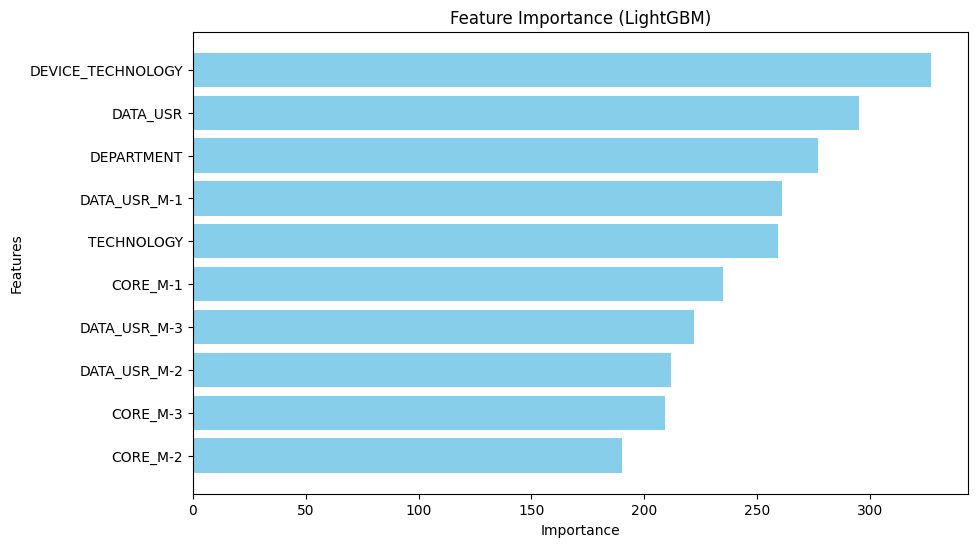

In [40]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_cat.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_cat.columns if isinstance(XTrain_cat, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_cat = importance_df[importance_df['Importance'] >= corte]
selvars_cat = selvars_cat['Feature'].tolist()

importance_df_red = importance_df[importance_df['Feature'].isin(selvars_cat)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red["Feature"], importance_df_red["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()


## Variables Booleans

In [41]:
# Creación de una lista de variables númericas
bool_cols = XTrain.select_dtypes(include=['bool']).columns

XTrain_bool = XTrain[bool_cols]

In [42]:
# Guardar nombres originales de las columnas
XTrain_bool_arbol = XTrain_bool.copy()

nombres_originales = XTrain_bool.columns.tolist()

# Crear un DataFrame a partir de la lista nombres_originales
df_nombres = pd.DataFrame(nombres_originales, columns=['Nombre'])

# Agregar una columna 'Col_Indice' con números del 0 al total de columnas
df_nombres['Feature'] = range(len(XTrain_bool.columns))

# Asegúrate de que las longitudes coincidan
if len(df_nombres) == len(XTrain_bool.columns):
    # Reemplazar 'Col_Indice' con los nombres de las columnas de XTrain_mod_arbol
    XTrain_bool_arbol.columns = df_nombres['Feature']
else:
    print("Error: Las longitudes de df_nombres y las columnas de XTrain_mod_arbol no coinciden.")

# Aplicacion del modelo LightGBM para encontrar los mejores parametros y variables
print("---------- Comienza Ejecucion modelo LightGBM ----------")

# Identificar columnas con tipo 'object'

grid_search_lgbm_bool = modelo_LightGBM(XTrain_bool_arbol, yTrain)

print("---------- Finaliza Ejecucion modelo LightGBM ----------")

---------- Comienza Ejecucion modelo LightGBM ----------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
---------- Finaliza Ejecucion modelo LightGBM ----------


---------- Las variables selecionadas por servicios adquiridos son ----------
['missing_1', 'missing_3', 'missing_2', 'missing_M']


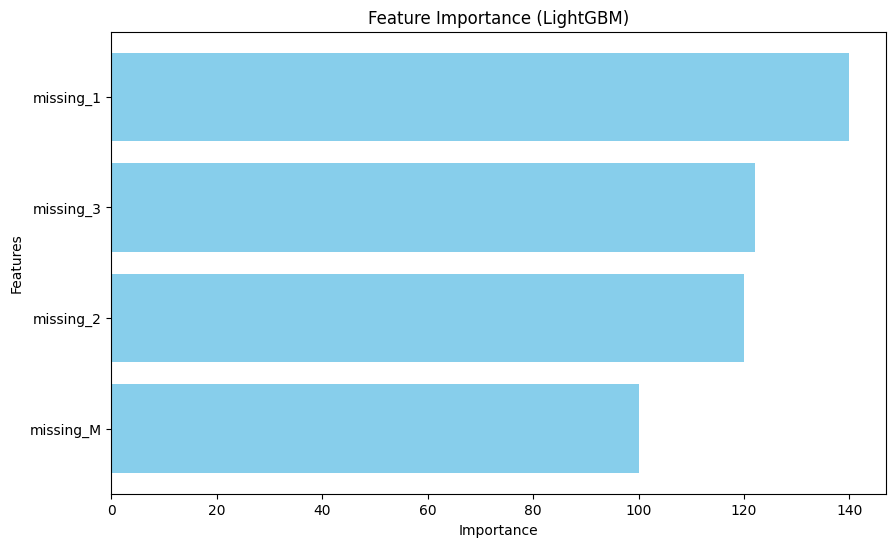

In [43]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_bool.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_bool_arbol.columns if isinstance(XTrain_bool_arbol, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

importance_df = importance_df.merge(df_nombres, on = 'Feature', how = 'left')
corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_bool = importance_df[importance_df['Importance'] >= corte]
selvars_bool = selvars_bool['Nombre'].tolist()

print("---------- Las variables selecionadas por servicios adquiridos son ----------")

print(selvars_bool)

importance_df_red = importance_df[importance_df['Nombre'].isin(selvars_bool)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red["Nombre"], importance_df_red["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

## Seleccion de variables

In [44]:
Selected_Cols = selvars_num + selvars_cat + selvars_bool
np.savetxt("Selected_Cols.csv", Selected_Cols, delimiter=",", fmt="%s")
Selected_Cols

['REV_OUT_INFORMATION',
 'CONSUMO_DATOS',
 'DIAS_INACTIVIDAD',
 'MINUTES_OUT',
 'REV_OUT_COMMUNICATION',
 'MSG_IN',
 'AGEING',
 'QTY_RCHG',
 'CALLS_OUT',
 'AMNT_RCHG',
 'MINUTES_IN',
 'REV_TOTAL',
 'CALLS_IN',
 'REV_IN',
 'DIAS_INACTIVIDAD_M-1',
 'MSG_OUT',
 'REV_OUT',
 'qty_pqt_M.1',
 'QTY_PQT',
 'CONSUMO_DATOS_M-1',
 'qty_pqt_M.3',
 'qty_pqt_M.2',
 'REV_OUT_INFORMATION_MAX_3M',
 'DIAS_INACTIVIDAD_M-3',
 'REV_OUT_SOLUTIONS',
 'MSG_OUT_M-1',
 'CONSUMO_DATOS_MAX_3M',
 'QTY_RCHG_MAX_3M',
 'REV_OUT_ENTERTAIMENT',
 'DIAS_INACTIVIDAD_M-2',
 'QTY_RCHG_MEAN_3M',
 'CONSUMO_DATOS_M-3',
 'REV_OUT_INFORMATION_M-1',
 'DEVICE_TECHNOLOGY',
 'DATA_USR',
 'DEPARTMENT',
 'DATA_USR_M-1',
 'TECHNOLOGY',
 'CORE_M-1',
 'DATA_USR_M-3',
 'DATA_USR_M-2',
 'CORE_M-3',
 'CORE_M-2',
 'missing_1',
 'missing_3',
 'missing_2',
 'missing_M']

In [45]:
XTrain_red = XTrain[Selected_Cols]
XTest_red = XTest_1[Selected_Cols]

XTrain_red

,REV_OUT_INFORMATION,CONSUMO_DATOS,DIAS_INACTIVIDAD,MINUTES_OUT,REV_OUT_COMMUNICATION,MSG_IN,AGEING,QTY_RCHG,CALLS_OUT,AMNT_RCHG,MINUTES_IN,REV_TOTAL,CALLS_IN,REV_IN,DIAS_INACTIVIDAD_M-1,MSG_OUT,REV_OUT,qty_pqt_M.1,QTY_PQT,CONSUMO_DATOS_M-1,qty_pqt_M.3,qty_pqt_M.2,REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD_M-3,REV_OUT_SOLUTIONS,MSG_OUT_M-1,CONSUMO_DATOS_MAX_3M,QTY_RCHG_MAX_3M,REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD_M-2,QTY_RCHG_MEAN_3M,CONSUMO_DATOS_M-3,REV_OUT_INFORMATION_M-1,DEVICE_TECHNOLOGY,DATA_USR,DEPARTMENT,DATA_USR_M-1,TECHNOLOGY,CORE_M-1,DATA_USR_M-3,DATA_USR_M-2,CORE_M-3,CORE_M-2,missing_1,missing_3,missing_2,missing_M
486583,20252.0,359125.6,0.0,386.4,3614.0,1.0,1.0,3.0,337.0,28000.0,36.3,24398.0,32.0,482.0,0,2.0,23916.0,0.0,3.0,0.0,0.0,0.0,0,0,50.0,0,0.0,0,0.0,0,0.000000,0.0,0,2G,Y,"BOGOTÁ, D. C.",N,4G,NO CORE,N,N,NO CORE,NO CORE,True,True,True,False
302956,22143.0,1589974.0,0.0,0.7,3785.0,2.0,34.0,9.0,2.0,31000.0,6.0,25949.0,8.0,21.0,0,0.0,25928.0,3.0,9.0,493643.3,6.0,3.0,17244,0,0.0,1,10202423.0,6,0.0,1,4.333333,10202423.0,8571,2G,Y,ANTIOQUIA,Y,4G,CORE,Y,Y,CORE,CORE,False,False,False,False
436023,33571.0,27891020.0,1.0,12.7,5738.0,0.0,11.0,3.0,27.0,47000.0,3.7,39336.0,6.0,26.0,1,0.0,39310.0,2.0,3.0,22129853.0,1.0,0.0,12857,5,0.0,12,22129853.0,2,0.0,0,1.000000,2563748.0,12857,2G,Y,"BOGOTÁ, D. C.",Y,4G,CORE,N,N,CORE,NO CORE,False,False,True,False
195054,9286.0,8273654.0,0.0,191.6,1587.0,0.0,41.0,2.0,97.0,13000.0,765.0,21077.0,97.0,10204.0,0,20.0,10873.0,2.0,2.0,8199312.0,0.0,0.0,8571,1,0.0,26,8199312.0,2,0.0,0,0.666667,48017.5,8571,2G,Y,CESAR,Y,4G,CORE,N,N,NO CORE,NO CORE,False,True,True,False
295461,17244.0,19191617.0,1.0,491.2,2950.0,6.0,7.0,4.0,502.0,24000.0,77.5,22360.0,99.0,1217.0,1,20.0,21143.0,2.0,4.0,7081003.0,4.0,5.0,19286,0,908.0,12,12322385.0,5,42.0,0,4.000000,5992072.0,6429,2G,Y,SANTANDER,Y,4G,CORE,Y,Y,CORE,CORE,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96899,22143.0,771445.3,0.0,794.5,3785.0,7.0,132.0,2.0,196.0,31000.0,1027.9,28473.0,330.0,2545.0,0,0.0,25928.0,0.0,2.0,372113.9,1.0,1.0,10714,0,0.0,0,945520.5,1,0.0,0,0.666667,945520.5,0,2G,Y,ANTIOQUIA,N,4G,NO CORE,Y,Y,CORE,CORE,True,False,False,False
345289,19286.0,7923354.0,0.0,47.5,3296.0,3.0,9.0,2.0,75.0,27000.0,121.3,24191.0,57.0,1609.0,0,22.0,22582.0,0.0,2.0,31164.8,1.0,0.0,10714,2,0.0,21,400570.3,1,0.0,0,0.333333,95560.6,0,4G,Y,CUNDINAMARCA,N,4G,NO CORE,Y,N,CORE,NO CORE,True,False,True,False
184395,19286.0,34645046.0,0.0,158.7,3296.0,0.0,3.0,7.0,220.0,27000.0,164.2,23715.0,140.0,1133.0,0,14.0,22582.0,4.0,7.0,21949404.0,0.0,0.0,10714,0,0.0,2,21949404.0,4,0.0,6,1.333333,0.0,10714,4G,Y,MAGDALENA,Y,4G,CORE,N,N,NO CORE,NO CORE,False,True,True,False
422331,18214.0,29520259.0,0.0,241.7,3113.0,3.0,12.0,4.0,132.0,25500.0,403.7,24070.0,117.0,2742.0,0,23.0,21328.0,8.0,4.0,18201103.0,4.0,8.0,14538,0,0.0,36,33186861.0,6,0.0,0,5.333333,33005896.0,12412,4G,Y,ATLÁNTICO,Y,3G,CORE,Y,Y,CORE,CORE,False,False,False,False


In [46]:
XTrain_sc, XTest_sc, loaded_scalers, loaded_encoders = estandarizacion(XTrain_red, XTest_red)
XTrain_sc

,REV_OUT_INFORMATION,CONSUMO_DATOS,DIAS_INACTIVIDAD,MINUTES_OUT,REV_OUT_COMMUNICATION,MSG_IN,AGEING,QTY_RCHG,CALLS_OUT,AMNT_RCHG,MINUTES_IN,REV_TOTAL,CALLS_IN,REV_IN,DIAS_INACTIVIDAD_M-1,MSG_OUT,REV_OUT,qty_pqt_M.1,QTY_PQT,CONSUMO_DATOS_M-1,qty_pqt_M.3,qty_pqt_M.2,REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD_M-3,REV_OUT_SOLUTIONS,MSG_OUT_M-1,CONSUMO_DATOS_MAX_3M,QTY_RCHG_MAX_3M,REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD_M-2,QTY_RCHG_MEAN_3M,CONSUMO_DATOS_M-3,REV_OUT_INFORMATION_M-1,missing_1,missing_3,missing_2,missing_M,DEVICE_TECHNOLOGY_2G,DEVICE_TECHNOLOGY_3G,DEVICE_TECHNOLOGY_4G,DATA_USR_N,DATA_USR_Y,DEPARTMENT_AMAZONAS,DEPARTMENT_ANTIOQUIA,DEPARTMENT_ARAUCA,"DEPARTMENT_ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y",DEPARTMENT_ATLÁNTICO,"DEPARTMENT_BOGOTÁ, D. C.",DEPARTMENT_BOLÍVAR,DEPARTMENT_BOYACÁ,DEPARTMENT_CALDAS,DEPARTMENT_CAQUETÁ,DEPARTMENT_CASANARE,DEPARTMENT_CAUCA,DEPARTMENT_CESAR,DEPARTMENT_CHOCÓ,DEPARTMENT_CUNDINAMARCA,DEPARTMENT_CÓRDOBA,DEPARTMENT_GUAINÍA,DEPARTMENT_GUAVIARE,DEPARTMENT_HUILA,DEPARTMENT_LA GUAJIRA,DEPARTMENT_MAGDALENA,DEPARTMENT_META,DEPARTMENT_NARIÑO,DEPARTMENT_NORTE DE SANTANDER,DEPARTMENT_PUTUMAYO,DEPARTMENT_QUINDÍO,DEPARTMENT_RISARALDA,DEPARTMENT_SANTANDER,DEPARTMENT_SUCRE,DEPARTMENT_TO BE DETERMINED,DEPARTMENT_TOLIMA,DEPARTMENT_VALLE DEL CAUCA,DEPARTMENT_VAUPÉS,DEPARTMENT_VICHADA,DATA_USR_M-1_N,DATA_USR_M-1_Y,TECHNOLOGY_2G,TECHNOLOGY_3G,TECHNOLOGY_4G,CORE_M-1_CORE,CORE_M-1_NO CORE,DATA_USR_M-3_N,DATA_USR_M-3_Y,DATA_USR_M-2_N,DATA_USR_M-2_Y,CORE_M-3_CORE,CORE_M-3_NO CORE,CORE_M-2_CORE,CORE_M-2_NO CORE
486583,0.091312,0.000861,0.000382,0.021934,0.133406,0.000232,0.004386,0.058824,0.037955,0.093023,0.004045,0.098118,0.007775,0.004027,0.000382,0.000484,0.149134,0.000000,0.073171,0.000000,0.000000,0.000000,0.000000,0.000391,0.002473,0.000000,0.000000,0.000000,0.00000,0.000386,0.000000,0.000000,0.000000,True,True,True,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
302956,0.099838,0.003810,0.000382,0.000040,0.134338,0.000463,0.149123,0.176471,0.000225,0.102990,0.000669,0.104765,0.001944,0.000175,0.000382,0.000000,0.157261,0.068182,0.219512,0.001908,0.146341,0.071429,0.104784,0.000391,0.000000,0.000224,0.020995,0.068182,0.00000,0.000772,0.051793,0.037988,0.052082,False,False,False,False,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
436023,0.151364,0.066838,0.000764,0.000721,0.144983,0.000000,0.048246,0.058824,0.003041,0.156146,0.000412,0.162131,0.001458,0.000217,0.000764,0.000000,0.211316,0.045455,0.073171,0.085532,0.024390,0.000000,0.078126,0.002346,0.000000,0.002687,0.045541,0.022727,0.00000,0.000386,0.011952,0.009546,0.078126,False,False,True,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
195054,0.041868,0.019827,0.000382,0.010876,0.122357,0.000000,0.179825,0.039216,0.010925,0.043189,0.085244,0.083887,0.023567,0.085261,0.000382,0.004836,0.096448,0.045455,0.048780,0.031690,0.000000,0.000000,0.052082,0.000782,0.000000,0.005822,0.016873,0.022727,0.00000,0.000386,0.007968,0.000179,0.052082,False,True,True,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
295461,0.077749,0.045991,0.000764,0.027883,0.129786,0.001390,0.030702,0.078431,0.056538,0.079734,0.008636,0.089385,0.024052,0.010169,0.000764,0.004836,0.137933,0.045455,0.097561,0.027368,0.097561,0.119048,0.117192,0.000391,0.044910,0.002687,0.025358,0.056818,0.00047,0.000386,0.0478

# MODELO PCA PARA ENCONTRAR LOS MEJORES COMPONENTES PRINCIPALES

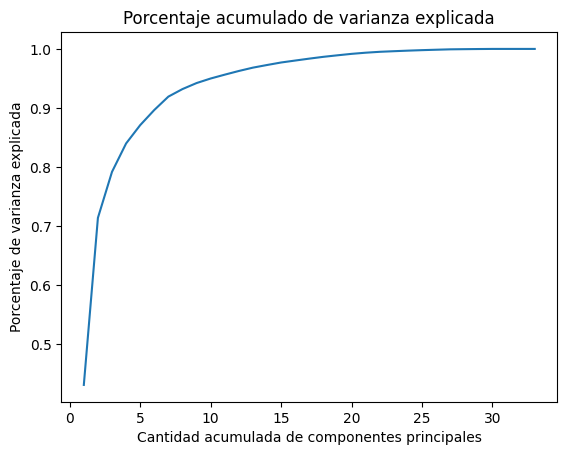


El valor óptimo de mínimos componentes a tomar es 24 con un MSE de 0.0119

Matriz de MSE para cada número de componentes evaluados:
 Num Componentes      MSE
             1.0 0.011977
             2.0 0.011977
             3.0 0.011977
             4.0 0.012039
             5.0 0.012176
             6.0 0.012176
             7.0 0.012201
             8.0 0.012226
             9.0 0.012239
            10.0 0.012214
            11.0 0.012214
            12.0 0.012214
            13.0 0.012102
            14.0 0.012239
            15.0 0.012239
            16.0 0.012214
            17.0 0.012226
            18.0 0.012189
            19.0 0.012164
            20.0 0.011952
            21.0 0.011952
            22.0 0.011940
            23.0 0.011902
            24.0 0.011865
            25.0 0.011865
            26.0 0.011865
            27.0 0.011865
            28.0 0.011865
            29.0 0.011865
            30.0 0.011865
            31.0 0.011865
            32.0 0.011865
         

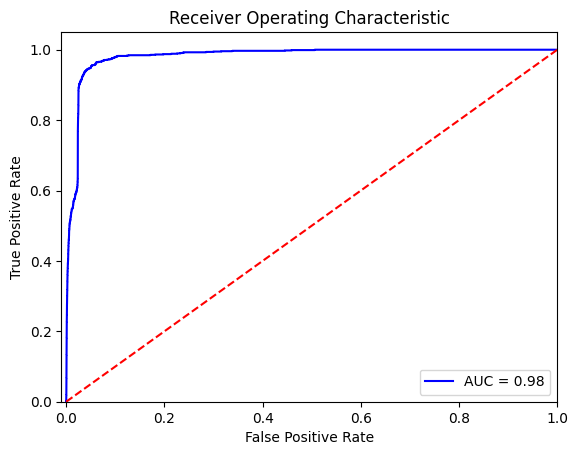

El valor de AUC para el modelo LogisticRegression() es:
0.9815574116934113 

.......................................................................................... 



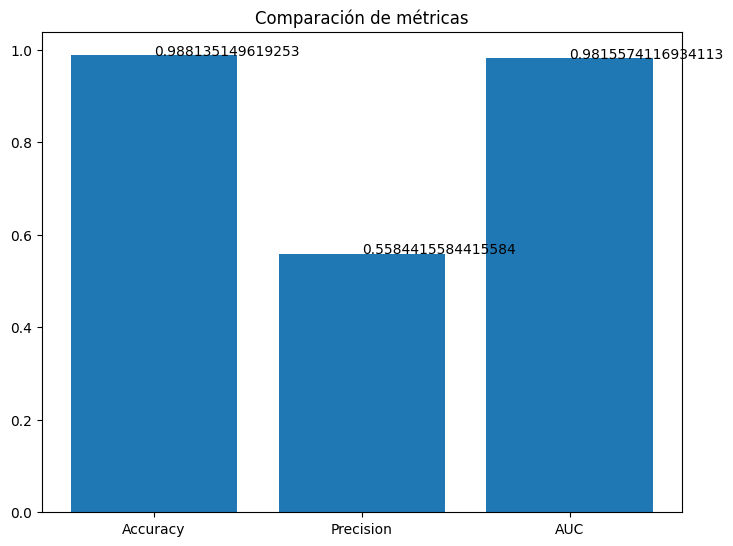

(0.011864850380747222,
 0.988135149619253,
 0.5584415584415584,
 0.9815574116934113,
 0.08285163776493257)

In [47]:
### MODELO PCA ###

def modelo_pca_mse_opt(n_componentes, XTrain_sc_num, yTrain, XTest_sc_num, yTest):
    
    # Ajustar PCA
    pca = PCA(n_components=XTrain_sc_num.shape[1])
    X_pca_train = pca.fit_transform(XTrain_sc_num) # Transformar datos de entrenamiento
    joblib.dump(pca, "pca_model.pkl")

    # Varianza explicada
    porcentaje_varianza_explicada = np.cumsum(pca.explained_variance_ratio_)

    # Graficar porcentaje acumulado de varianza explicada
    plt.plot(range(1, XTrain_sc_num.shape[1] + 1), porcentaje_varianza_explicada)
    plt.xlabel('Cantidad acumulada de componentes principales')
    plt.ylabel('Porcentaje de varianza explicada')
    plt.title('Porcentaje acumulado de varianza explicada')
    plt.show()

    # Inicializar matriz para guardar resultados
    MSE_PCA = np.zeros((len(n_componentes), 2))

    # Estandarizar XTest con los mismos parámetros de XTrain
    X_pca_test = pca.transform(XTest_sc_num)

    #ZTotalTest = np.matmul(XEscaladoTest, A)
    # en el codigo de clase la matriz de transformación A = pca.components_ se obtiene manualmente y se usa con np.matmul para proyectar los datos.
    # en este se usa directamente la función pca.transform(), lo cual es la forma más estándar y segura de aplicar PCA.
    
    for i, n_comp in enumerate(n_componentes):
        # Seleccionar n componentes principales
        ZTrain = X_pca_train[:, :n_comp]
        ZTest = X_pca_test[:, :n_comp]

        # Ajustar regresión lineal
        regPCA = LogisticRegression()
        regPCA.fit(ZTrain, yTrain)

        # Predecir y calcular MSE
        prediccionPCA = regPCA.predict(ZTest)
        mse = np.mean((prediccionPCA - yTest) ** 2)

        # Guardar resultados
        MSE_PCA[i] = [n_comp, mse]

    # Encontrar el mejor modelo
    n_componentes_opt, mse_minimo = MSE_PCA[np.argmin(MSE_PCA[:, 1])]

    ZTrain = X_pca_train[:, :int(n_componentes_opt)]
    regPCA = LogisticRegression()
    regPCA.fit(ZTrain, yTrain)

    # Mostrar resultados de forma más legible
    df_mse = pd.DataFrame(MSE_PCA, columns=["Num Componentes", "MSE"])
    print(f"\nEl valor óptimo de mínimos componentes a tomar es {n_componentes_opt:.0f} con un MSE de {mse_minimo:.4f}")
    print(f"\nMatriz de MSE para cada número de componentes evaluados:")
    print(df_mse.to_string(index=False))

    return pca, int(n_componentes_opt), regPCA
    
num_cols = XTrain_red.select_dtypes(include=['float64', 'int64']).columns
np.savetxt("num_cols.csv", np.array(num_cols), delimiter=",", fmt="%s")

n_componentes = list(range(1, XTrain_red[num_cols].shape[1] + 1))

XTrain_sc_num = XTrain_sc[num_cols]
XTest_sc_num = XTest_sc[num_cols]

pca_transf, n_componentes_opt_lr, modelo_regPCA = modelo_pca_mse_opt(n_componentes, XTrain_sc_num, yTrain, XTest_sc_num, yTest)

# Metricas en la base de testeo

X_pca_test = pca_transf.transform(XTest_sc_num)
ZTest = X_pca_test[:, :n_componentes_opt_lr]

metricas_desempeño(ZTest, yTest, modelo_regPCA)

..............................................................................................................
Inicio del proceso de selección de variables secuencial (forward)
..............................................................................................................
Evaluación del modelo con 1 variables
Evaluación del modelo con 2 variables
Evaluación del modelo con 3 variables
Evaluación del modelo con 4 variables
Evaluación del modelo con 5 variables
Evaluación del modelo con 6 variables
Evaluación del modelo con 7 variables
Evaluación del modelo con 8 variables
Evaluación del modelo con 9 variables
Evaluación del modelo con 10 variables
..............................................................................................................
Gráfica del R² ajustado para cada número de variables evaluado:
..............................................................................................................


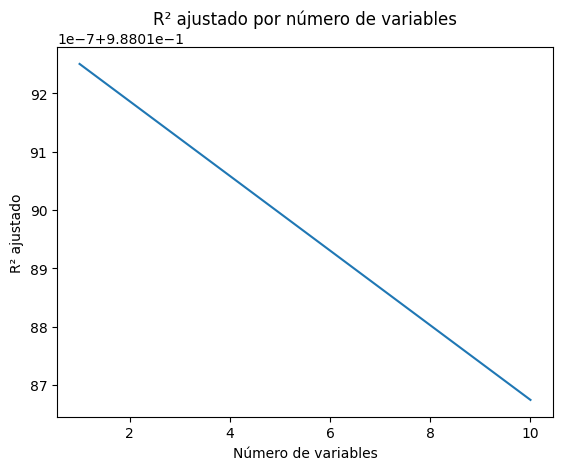

..............................................................................................................
El número de variables seleccionadas es 1 y corresponden a las columnas: [1]
..............................................................................................................
..............................................................................................................
El MSE de la regresión lineal usando las variables seleccionadas por el método forward es: 0.011977018083926368
..............................................................................................................
.......................................................................................... 

El error de clasificación para LogisticRegression() en la muestra de test es:
0.011977018083926556 

.......................................................................................... 

[[79276     0]
 [  961     0]] 

...............................................

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


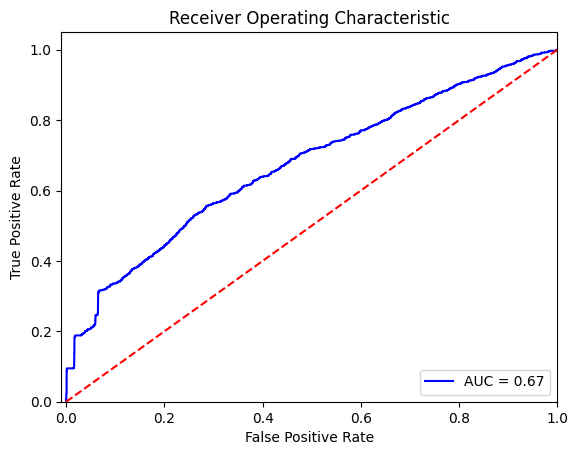

El valor de AUC para el modelo LogisticRegression() es:
0.6723346874542392 

.......................................................................................... 



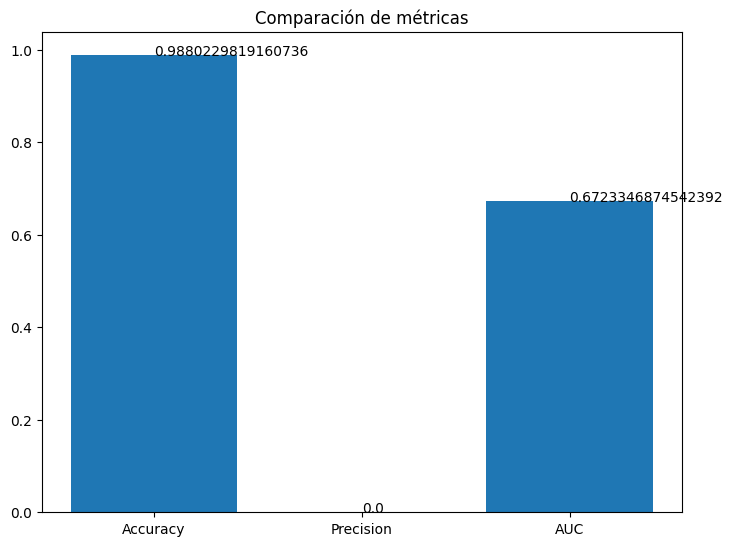

(0.011977018083926556, 0.9880229819160736, 0.0, 0.6723346874542392, 0.0)

In [48]:
# Función para entrenamiento del modelo PCA y aplicación del método Forward
def modelo_pca_mse_fw(n_componentes, XTrain_sc_num, yTrain, XTest_sc_num, yTest):
    
    # Estandarización de las variables predictoras en la base de entrenamiento
    
    XEscaladoTrain = XTrain_sc_num

    # Aplicación de PCA
    pca = PCA(n_components=XTrain_sc_num.shape[1])
    ZTotalTrain = pca.fit_transform(XEscaladoTrain)  # Transformar los datos correctamente

    # Aplicar el método de selección forward sobre los componentes principales
    r2adj = []
    datosTrain = len(yTrain)

    print(f"{'.' * 110}")
    print('Inicio del proceso de selección de variables secuencial (forward)')
    print(f"{'.' * 110}")

    for a in range(1, n_componentes):
        if a < XTrain_sc_num.shape[1]:
            sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=a, direction='forward')
            sfs.fit(ZTotalTrain, yTrain)
            ZTrainSeleccionado = sfs.transform(ZTotalTrain)  # Aplicar selección de variables
            regAuxiliar = LogisticRegression()
            regAuxiliar.fit(ZTrainSeleccionado, yTrain)
            r2Modelo = regAuxiliar.score(ZTrainSeleccionado, yTrain)
            r2adjModelo = 1 - (1 - r2Modelo) * (datosTrain - 1) / (datosTrain - a - 1)
            r2adj.append(r2adjModelo)
        else:
            regAuxiliar = LogisticRegression()
            regAuxiliar.fit(ZTotalTrain, yTrain)
            r2Modelo = regAuxiliar.score(ZTotalTrain, yTrain)
            r2adjModelo = 1 - (1 - r2Modelo) * (datosTrain - 1) / (datosTrain - a - 1)
            r2adj.append(r2adjModelo)

        print(f"Evaluación del modelo con {a} variables")

    # Gráfica del R² ajustado
    print(f"{'.' * 110}")
    print(f"Gráfica del R² ajustado para cada número de variables evaluado:")
    print(f"{'.' * 110}")

    plt.plot(range(1, n_componentes), r2adj)
    plt.xlabel('Número de variables')
    plt.ylabel('R² ajustado')
    plt.title('R² ajustado por número de variables')
    plt.show()

    # Selección del número de variables óptimas basado en R² ajustado
    nVariablesSeleccionadas = np.argmax(r2adj) + 1

    # Aplicar selección de variables óptimas
    sfsElegido = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=nVariablesSeleccionadas, direction='forward')
    sfsElegido.fit(ZTotalTrain, yTrain)
    ZTrainSeleccionado = sfsElegido.transform(ZTotalTrain)
    
    modeloFwd = LogisticRegression()
    modeloFwd.fit(ZTrainSeleccionado, yTrain)
    
    # Obtener las variables seleccionadas
    variablesSeleccionadas = np.where(sfsElegido.get_support())[0] + 1

    print(f"{'.' * 110}")
    print(f"El número de variables seleccionadas es {nVariablesSeleccionadas} y corresponden a las columnas: {variablesSeleccionadas}")
    print(f"{'.' * 110}")

    # Transformación de los datos de prueba con PCA
    XEscaladoTest = XTest_sc_num
    ZTotalTest = pca.transform(XEscaladoTest)

    # Aplicar modelo en test
    prediccionFwd = modeloFwd.predict(ZTotalTest[:, variablesSeleccionadas - 1])
    MSEFwd = np.mean((prediccionFwd - yTest) ** 2)

    print(f"{'.' * 110}")
    print(f"El MSE de la regresión lineal usando las variables seleccionadas por el método forward es: {MSEFwd}")
    print(f"{'.' * 110}")

    return nVariablesSeleccionadas, variablesSeleccionadas, pca, modeloFwd

# Evaluar el modelo con forward selection
#n_componentes = list(range(1, (n_componentes_opt_lr + 2)))
n_componentes = 9 + 2

nVarSel_PCAF, VarSel_PCAF, PCAF_transf, modelo_regPCAF = modelo_pca_mse_fw(n_componentes, XTrain_sc_num, yTrain, XTest_sc_num, yTest)

# Metricas en la base de testeo

X_pca_test = PCAF_transf.transform(XTest_sc_num)
ZTest = X_pca_test[:, VarSel_PCAF - 1]

metricas_desempeño(ZTest, yTest, modelo_regPCAF)

In [49]:
XTrain_sc_num

,REV_OUT_INFORMATION,CONSUMO_DATOS,DIAS_INACTIVIDAD,MINUTES_OUT,REV_OUT_COMMUNICATION,MSG_IN,AGEING,QTY_RCHG,CALLS_OUT,AMNT_RCHG,MINUTES_IN,REV_TOTAL,CALLS_IN,REV_IN,DIAS_INACTIVIDAD_M-1,MSG_OUT,REV_OUT,qty_pqt_M.1,QTY_PQT,CONSUMO_DATOS_M-1,qty_pqt_M.3,qty_pqt_M.2,REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD_M-3,REV_OUT_SOLUTIONS,MSG_OUT_M-1,CONSUMO_DATOS_MAX_3M,QTY_RCHG_MAX_3M,REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD_M-2,QTY_RCHG_MEAN_3M,CONSUMO_DATOS_M-3,REV_OUT_INFORMATION_M-1
486583,0.091312,0.000861,0.000382,0.021934,0.133406,0.000232,0.004386,0.058824,0.037955,0.093023,0.004045,0.098118,0.007775,0.004027,0.000382,0.000484,0.149134,0.000000,0.073171,0.000000,0.000000,0.000000,0.000000,0.000391,0.002473,0.000000,0.000000,0.000000,0.00000,0.000386,0.000000,0.000000,0.000000
302956,0.099838,0.003810,0.000382,0.000040,0.134338,0.000463,0.149123,0.176471,0.000225,0.102990,0.000669,0.104765,0.001944,0.000175,0.000382,0.000000,0.157261,0.068182,0.219512,0.001908,0.146341,0.071429,0.104784,0.000391,0.000000,0.000224,0.020995,0.068182,0.00000,0.000772,0.051793,0.037988,0.052082
436023,0.151364,0.066838,0.000764,0.000721,0.144983,0.000000,0.048246,0.058824,0.003041,0.156146,0.000412,0.162131,0.001458,0.000217,0.000764,0.000000,0.211316,0.045455,0.073171,0.085532,0.024390,0.000000,0.078126,0.002346,0.000000,0.002687,0.045541,0.022727,0.00000,0.000386,0.011952,0.009546,0.078126
195054,0.041868,0.019827,0.000382,0.010876,0.122357,0.000000,0.179825,0.039216,0.010925,0.043189,0.085244,0.083887,0.023567,0.085261,0.000382,0.004836,0.096448,0.045455,0.048780,0.031690,0.000000,0.000000,0.052082,0.000782,0.000000,0.005822,0.016873,0.022727,0.00000,0.000386,0.007968,0.000179,0.052082
295461,0.077749,0.045991,0.000764,0.027883,0.129786,0.001390,0.030702,0.078431,0.056538,0.079734,0.008636,0.089385,0.024052,0.010169,0.000764,0.004836,0.137933,0.045455,0.097561,0.027368,0.097561,0.119048,0.117192,0.000391,0.044910,0.002687,0.025358,0.056818,0.00047,0.000386,0.047809,0.022311,0.039066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96899,0.099838,0.001849,0.000382,0.045100,0.134338,0.001622,0.578947,0.039216,0.022075,0.102990,0.114539,0.115581,0.080175,0.021265,0.000382,0.000000,0.157261,0.000000,0.048780,0.001438,0.024390,0.023810,0.065104,0.000391,0.000000,0.000000,0.001946,0.011364,0.00000,0.000386,0.007968,0.003521,0.000000
345289,0.086956,0.018988,0.000382,0.002696,0.131672,0.000695,0.039474,0.039216,0.008447,0.089701,0.013517,0.097231,0.013848,0.013444,0.000382,0.005319,0.143745,0.000000,0.048780,0.000120,0.024390,0.000000,0.065104,0.001173,0.000000,0.004702,0.000824,0.011364,0.00000,0.000386,0.003984,0.000356,0.000000
184395,0.086956,0.083024,0.000382,0.009009,0.131672,0.000000,0.013158,0.137255,0.024778,0.089701,0.018297,0.095192,0.034014,0.009467,0.000382,0.003385,0.143745,0.090909,0.170732,0.084834,0.000000,0.000000,0.065104,0.000391,0.000000,0.000448,0.045169,0.045455,0.00000,0.002704,0.015936,0.000000,0.065104
422331,0.082123,0.070742,0.000382,0.013720,0.130675,0.000695,0.052632,0.078431,0.014867,0.084717,0.044985,0.096713,0.028426,0.022911,0.000382,0.005561,0.138680,0.181818,0.097561,0.070347,0.097561,0.190476,0.088341,0.000391,0.000000,0.008061,0.068295,0.068182,0.00000,0.000386,0.063745,0.122897,0.075422


.......................................................................................... 

El error de clasificación para LogisticRegression() en la muestra de test es:
0.011864850380747222 

.......................................................................................... 

[[79242    34]
 [  918    43]] 

.......................................................................................... 

El valor de accuracy para el modelo LogisticRegression() es:
0.988135149619253 

.......................................................................................... 

El valor de precision para el modelo LogisticRegression() es:
0.5584415584415584 

.......................................................................................... 

El valor de F1-Score para el modelo LogisticRegression() es:
0.08285163776493257 

.......................................................................................... 



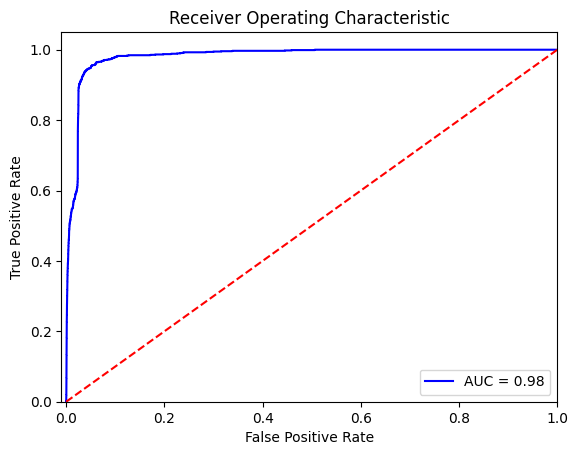

El valor de AUC para el modelo LogisticRegression() es:
0.9815574116934113 

.......................................................................................... 



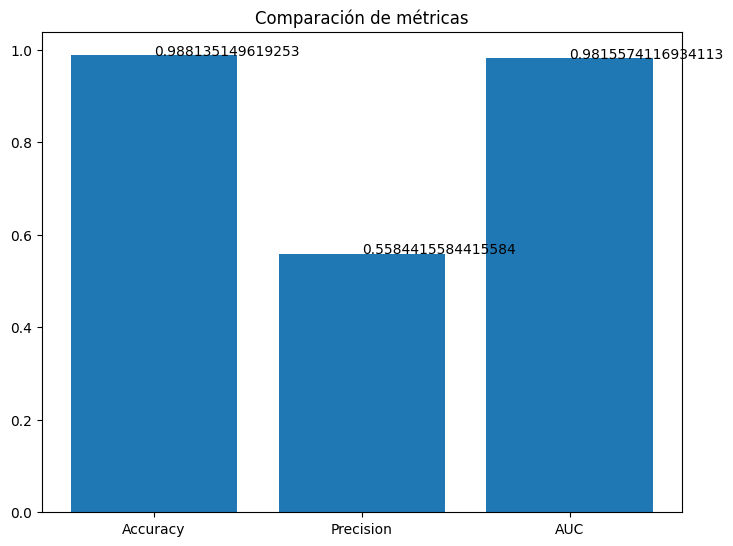

(0.011864850380747222,
 0.988135149619253,
 0.5584415584415584,
 0.9815574116934113,
 0.08285163776493257)

In [50]:
# Variables selecionadas por PCA y por PCA Forward
VarSel_PCA = list(range(1, n_componentes_opt_lr + 1))
VarSel_PCA_F = np.union1d(VarSel_PCA, VarSel_PCAF)

# Guardar la lista de variables finales de PCA
np.savetxt("VarSel_PCA_F.csv", VarSel_PCA_F, delimiter=",", fmt="%d")

#Transformación por PCA
pca_F = PCA(n_components=XTrain_sc_num.shape[1])

X_pca_train = pca_F.fit_transform(XTrain_sc_num)
ZTrain = X_pca_train[:, VarSel_PCA_F - 1]

X_pca_test = pca_F.transform(XTest_sc_num)
ZTest = X_pca_test[:, VarSel_PCA_F - 1]

#Modelo regresión con el nuevo conjunto PCA
modeloPCA_F = LogisticRegression()
modeloPCA_F.fit(ZTrain, yTrain)

metricas_desempeño(ZTest, yTest, modeloPCA_F)

In [51]:
VarSel_PCA_F

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

# MODELO POLYNOMIAL FEATURES PARA ENCONTRAR LAS MEJORES COMBINACIONES NO LINEALES

In [52]:
pf = PolynomialFeatures(degree=2)

XTrain_pol = pf.fit_transform(XTrain_sc_num)
XTrain_pol = pd.DataFrame(XTrain_pol, columns=pf.get_feature_names_out())
joblib.dump(pf, "polyFeature_model.pkl")

XTrain_pol

,1,REV_OUT_INFORMATION,CONSUMO_DATOS,DIAS_INACTIVIDAD,MINUTES_OUT,REV_OUT_COMMUNICATION,MSG_IN,AGEING,QTY_RCHG,CALLS_OUT,AMNT_RCHG,MINUTES_IN,REV_TOTAL,CALLS_IN,REV_IN,DIAS_INACTIVIDAD_M-1,MSG_OUT,REV_OUT,qty_pqt_M.1,QTY_PQT,CONSUMO_DATOS_M-1,qty_pqt_M.3,qty_pqt_M.2,REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD_M-3,REV_OUT_SOLUTIONS,MSG_OUT_M-1,CONSUMO_DATOS_MAX_3M,QTY_RCHG_MAX_3M,REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD_M-2,QTY_RCHG_MEAN_3M,CONSUMO_DATOS_M-3,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION^2,REV_OUT_INFORMATION CONSUMO_DATOS,REV_OUT_INFORMATION DIAS_INACTIVIDAD,REV_OUT_INFORMATION MINUTES_OUT,REV_OUT_INFORMATION REV_OUT_COMMUNICATION,REV_OUT_INFORMATION MSG_IN,REV_OUT_INFORMATION AGEING,REV_OUT_INFORMATION QTY_RCHG,REV_OUT_INFORMATION CALLS_OUT,REV_OUT_INFORMATION AMNT_RCHG,REV_OUT_INFORMATION MINUTES_IN,REV_OUT_INFORMATION REV_TOTAL,REV_OUT_INFORMATION CALLS_IN,REV_OUT_INFORMATION REV_IN,REV_OUT_INFORMATION DIAS_INACTIVIDAD_M-1,REV_OUT_INFORMATION MSG_OUT,REV_OUT_INFORMATION REV_OUT,REV_OUT_INFORMATION qty_pqt_M.1,REV_OUT_INFORMATION QTY_PQT,REV_OUT_INFORMATION CONSUMO_DATOS_M-1,REV_OUT_INFORMATION qty_pqt_M.3,REV_OUT_INFORMATION qty_pqt_M.2,REV_OUT_INFORMATION REV_OUT_INFORMATION_MAX_3M,REV_OUT_INFORMATION DIAS_INACTIVIDAD_M-3,REV_OUT_INFORMATION REV_OUT_SOLUTIONS,REV_OUT_INFORMATION MSG_OUT_M-1,REV_OUT_INFORMATION CONSUMO_DATOS_MAX_3M,REV_OUT_INFORMATION QTY_RCHG_MAX_3M,REV_OUT_INFORMATION REV_OUT_ENTERTAIMENT,REV_OUT_INFORMATION DIAS_INACTIVIDAD_M-2,REV_OUT_INFORMATION QTY_RCHG_MEAN_3M,REV_OUT_INFORMATION CONSUMO_DATOS_M-3,REV_OUT_INFORMATION REV_OUT_INFORMATION_M-1,CONSUMO_DATOS^2,CONSUMO_DATOS DIAS_INACTIVIDAD,CONSUMO_DATOS MINUTES_OUT,CONSUMO_DATOS REV_OUT_COMMUNICATION,CONSUMO_DATOS MSG_IN,CONSUMO_DATOS AGEING,CONSUMO_DATOS QTY_RCHG,CONSUMO_DATOS CALLS_OUT,CONSUMO_DATOS AMNT_RCHG,CONSUMO_DATOS MINUTES_IN,CONSUMO_DATOS REV_TOTAL,CONSUMO_DATOS CALLS_IN,CONSUMO_DATOS REV_IN,CONSUMO_DATOS DIAS_INACTIVIDAD_M-1,CONSUMO_DATOS MSG_OUT,CONSUMO_DATOS REV_OUT,CONSUMO_DATOS qty_pqt_M.1,CONSUMO_DATOS QTY_PQT,CONSUMO_DATOS CONSUMO_DATOS_M-1,CONSUMO_DATOS qty_pqt_M.3,CONSUMO_DATOS qty_pqt_M.2,CONSUMO_DATOS REV_OUT_INFORMATION_MAX_3M,CONSUMO_DATOS DIAS_INACTIVIDAD_M-3,CONSUMO_DATOS REV_OUT_SOLUTIONS,CONSUMO_DATOS MSG_OUT_M-1,CONSUMO_DATOS CONSUMO_DATOS_MAX_3M,CONSUMO_DATOS QTY_RCHG_MAX_3M,CONSUMO_DATOS REV_OUT_ENTERTAIMENT,CONSUMO_DATOS DIAS_INACTIVIDAD_M-2,CONSUMO_DATOS QTY_RCHG_MEAN_3M,CONSUMO_DATOS CONSUMO_DATOS_M-3,CONSUMO_DATOS REV_OUT_INFORMATION_M-1,DIAS_INACTIVIDAD^2,DIAS_INACTIVIDAD MINUTES_OUT,DIAS_INACTIVIDAD REV_OUT_COMMUNICATION,DIAS_INACTIVIDAD MSG_IN,DIAS_INACTIVIDAD AGEING,DIAS_INACTIVIDAD QTY_RCHG,DIAS_INACTIVIDAD CALLS_OUT,DIAS_INACTIVIDAD AMNT_RCHG,DIAS_INACTIVIDAD MINUTES_IN,DIAS_INACTIVIDAD REV_TOTAL,DIAS_INACTIVIDAD CALLS_IN,DIAS_INACTIVIDAD REV_IN,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD MSG_OUT,DIAS_INACTIVIDAD REV_OUT,DIAS_INACTIVIDAD qty_pqt_M.1,DIAS_INACTIVIDAD QTY_PQT,DIAS_INACTIVIDAD CONSUMO_DATOS_M-1,DIAS_INACTIVIDAD qty_pqt_M.3,DIAS_INACTIVIDAD qty_pqt_M.2,DIAS_INACTIVIDAD REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-3,DIAS_INACTIVIDAD REV_OUT_SOLUTIONS,DIAS_INACTIVIDAD MSG_OUT_M-1,DIAS_INACTIVIDAD CONSUMO_DATOS_MAX_3M,DIAS_INACTIVIDAD QTY_RCHG_MAX_3M,DIAS_INACTIVIDAD REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD QTY_RCHG_MEAN_3M,DIAS_INACTIVIDAD CONSUMO_DATOS_M-3,DIAS_INACTIVIDAD REV_OUT_INFORMATION_M-1,MINUTES_OUT^2,MINUTES_OUT REV_OUT_COMMUNICATION,MINUTES_OUT MSG_IN,MINUTES_OUT AGEING,MINUTES_OUT QTY_RCHG,MINUTES_OUT CALLS_OUT,MINUTES_OUT AMNT_RCHG,MINUTES_OUT MINUTES_IN,MINUTES_OUT REV_TOTAL,MINUTES_OUT CALLS_IN,MINUTES_OUT REV_IN,MINUTES_OUT DIAS_INACTIVIDAD_M-1,MINUTES_OUT MSG_OUT,MINUTES_OUT REV_OUT,MINUTES_OUT qty_pqt_M.1,MINUTES_OUT QTY_PQT,MINUTES_OUT CONSUMO_DATOS_M-1,MINUTES_OUT qty_pqt_M.3,MINUTES_OUT qty_pqt_M.2,MINUTES_OUT REV_OUT_INFORMATION_MAX_3M,MINUTES_OUT DIAS_INACTIVIDAD_M-3,MINUTES_OUT REV_OUT_SOLUTIONS,MINUTES_

In [53]:
#Ejecución de un modelo LightGBM para encontrar las mejores variables numericas

model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1) 

param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],  # Reducir combinaciones aquí
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 100]  # Usar menos estimadores
}

grid_search_lgbm_pol = RandomizedSearchCV(
    estimator=model,  # Asegúrate de que 'model' sea un LGBMClassifier
    param_distributions=param_grid,
    cv=5,
    n_jobs=4,
    verbose=1,
    n_iter=10
)

# Entrenar el modelo sin 'early_stopping_rounds' dentro de fit()
grid_search_lgbm_pol.fit(XTrain_pol, yTrain)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1)

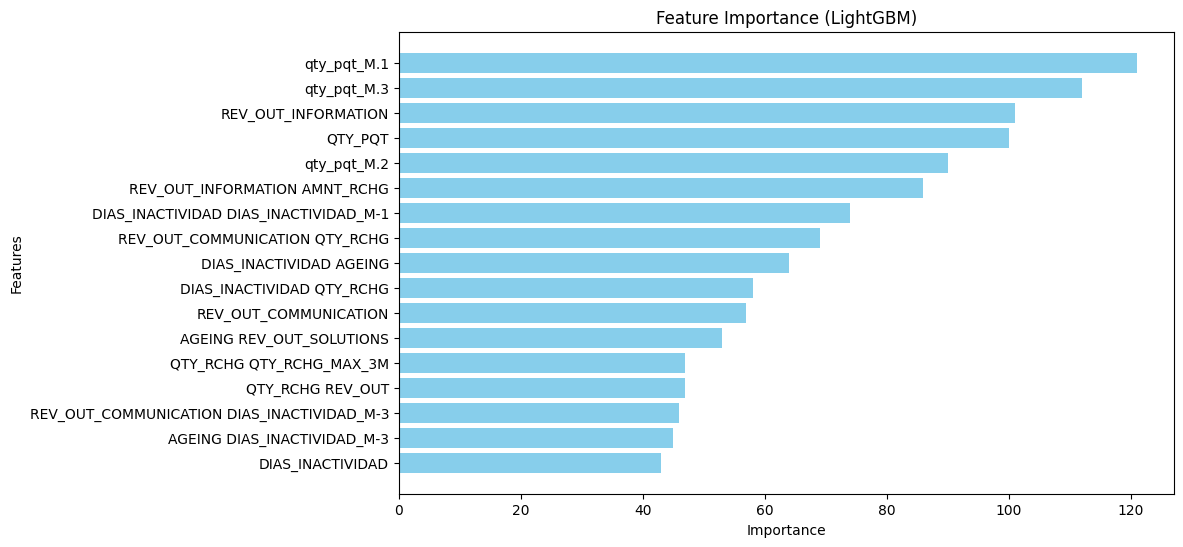

In [54]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_pol.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_pol.columns if isinstance(XTrain_pol, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean() + (importance_df[importance_df['Importance'] != 0]['Importance'].std()*2)

selvars_pol = importance_df[importance_df['Importance'] >= corte]
selvars_pol = selvars_pol['Feature'].tolist()
np.savetxt("selvars_pol.csv", np.array(selvars_pol), delimiter=",", fmt="%s")

importance_df_red = importance_df[importance_df['Feature'].isin(selvars_pol)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red["Feature"], importance_df_red["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()


# UNION DE BASES PARA OBTENER LA BASE FINAL DE ENTRENAMIENTO

In [55]:
XTrain, XTest, yTrain, yTest = train_test_f(df_churn_trasnf, 'CHURN')

In [56]:
def transf_PCA_POL(XDF_sc):
    
    # Carga de listas de variables y transformadores
    num_cols_loaded = np.loadtxt("num_cols.csv", delimiter=",", dtype=str)
    
    VarSel_PCA_F_loaded = np.loadtxt("VarSel_PCA_F.csv", delimiter=",")
    VarSel_PCA_F_loaded = VarSel_PCA_F_loaded.astype(int)
    VarSel_PCA_F_loaded = np.array(VarSel_PCA_F_loaded)
    
    # Asegurar que `VarSel_PCA_F_loaded` sea un array NumPy
    if isinstance(VarSel_PCA_F_loaded, (int, float)):  # Si es un número escalar, conviértelo a una lista
        VarSel_PCA_F_loaded = [VarSel_PCA_F_loaded]
    elif isinstance(VarSel_PCA_F_loaded, np.ndarray) and VarSel_PCA_F_loaded.ndim == 0:  # Si es un array de dimensión 0, conviértelo en un array de dimensión 1
        VarSel_PCA_F_loaded = np.array([VarSel_PCA_F_loaded])
    
    selvars_pol_loaded = np.loadtxt("selvars_pol.csv", delimiter=",", dtype=str)

    pca_loaded = joblib.load("pca_model.pkl")
    pf_loaded = joblib.load("polyFeature_model.pkl")

    # Construcción de base con las variables de PCA
    
    XDF_sc_num = XDF_sc[num_cols_loaded]

    #X_pca_test = pca_transf.transform(XTest_sc_num)
    #ZTest = X_pca_test[:, :n_componentes_opt_lr]
    
    X_pca = pca_loaded.transform(XDF_sc_num)
    X_pca_selected = X_pca[:, VarSel_PCA_F_loaded - 1]
    XDF_PCA = pd.DataFrame(X_pca_selected)
    column_names = [f'PCA_{num}' for num in VarSel_PCA_F_loaded]
    XDF_PCA.columns = column_names

    # Construcción de base con las variables de PCA
    
    X_pol = pf_loaded.transform(XDF_sc_num)
    XDF_pol = pd.DataFrame(X_pol, columns=pf.get_feature_names_out())
    XDF_pol = XDF_pol[selvars_pol_loaded]

    XDF_Final = pd.concat([XDF_PCA, XDF_pol], axis=1)
    
    return XDF_Final

In [57]:
XTrain_sc_PCA_Pol = transf_PCA_POL(XTrain_sc)
XTrain_sc_PCA_Pol

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,qty_pqt_M.1,qty_pqt_M.3,REV_OUT_INFORMATION,QTY_PQT,qty_pqt_M.2,REV_OUT_INFORMATION AMNT_RCHG,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1,REV_OUT_COMMUNICATION QTY_RCHG,DIAS_INACTIVIDAD AGEING,DIAS_INACTIVIDAD QTY_RCHG,REV_OUT_COMMUNICATION,AGEING REV_OUT_SOLUTIONS,QTY_RCHG QTY_RCHG_MAX_3M,QTY_RCHG REV_OUT,REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3,AGEING DIAS_INACTIVIDAD_M-3,DIAS_INACTIVIDAD
0,-0.142889,-0.030052,0.132652,0.034773,0.018073,-0.001433,0.009858,0.006006,-0.003267,-0.013643,-0.007928,0.024131,0.000041,-0.005924,-0.009346,0.000443,-0.003894,-0.016217,-0.005057,-0.005765,-0.000766,0.001058,0.001503,0.012571,0.000000,0.000000,0.091312,0.073171,0.000000,0.008494,1.457904e-07,0.007847,0.000002,0.000022,0.133406,0.000011,0.000000,0.008773,0.000052,0.000002,0.000382
1,0.026565,0.182054,0.020707,0.140559,0.040272,-0.040968,0.014669,0.101311,-0.021369,0.005834,0.007616,-0.022374,-0.004297,0.012368,-0.006263,-0.007402,-0.007605,-0.017125,0.001321,-0.005125,0.009887,-0.000471,-0.000545,-0.001629,0.068182,0.146341,0.099838,0.219512,0.071429,0.010282,1.457904e-07,0.023707,0.000057,0.000067,0.134338,0.000000,0.012032,0.027752,0.000053,0.000058,0.000382
2,-0.086670,0.134699,0.164729,-0.058391,0.018967,-0.041934,-0.008009,-0.026709,-0.018051,0.000363,-0.024008,-0.041483,-0.002434,-0.007931,-0.003529,0.001742,-0.000587,-0.000859,0.007018,-0.001375,-0.000224,0.004621,-0.000414,-0.000512,0.045455,0.024390,0.151364,0.073171,0.000000,0.023635,5.831617e-07,0.008528,0.000037,0.000045,0.144983,0.000000,0.001337,0.012430,0.000340,0.000113,0.000764
3,0.040543,-0.039213,0.036907,-0.022159,-0.010982,0.084101,-0.051063,-0.006276,-0.007151,0.009705,0.015353,-0.035058,-0.011344,-0.001609,-0.001326,-0.019619,-0.008053,0.000367,-0.007750,-0.011422,-0.004739,0.005266,-0.001438,0.004319,0.045455,0.000000,0.041868,0.048780,0.000000,0.001808,1.457904e-07,0.004798,0.000069,0.000015,0.122357,0.000000,0.000891,0.003782,0.000096,0.000141,0.000382
4,-0.093946,0.123627,-0.014288,0.034591,0.010451,0.009317,0.046270,0.015098,0.045171,0.016910,-0.045079,0.030233,-0.006675,-0.012564,-0.001979,0.009044,-0.000276,0.015620,-0.011549,-0.007132,-0.004928,0.006278,0.001855,0.015379,0.045455,0.097561,0.077749,0.097561,0.119048,0.006199,5.831617e-07,0.010179,0.000023,0.000060,0.129786,0.001379,0.004456,0.010818,0.000051,0.000012,0.000764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187213,0.440497,-0.037178,0.140226,-0.003816,0.004340,0.083778,0.024025,0.015073,0.022135,-0.009944,-0.003829,0.002513,-0.007194,-0.023821,-0.000098,0.042333,0.014386,-0.017509,0.028016,0.019371,0.005684,-0.007388,-0.004022,-0.011178,0.000000,0.024390,0.099838,0.048780,0.023810,0.010282,1.457904e-07,0.005268,0.000221,0.000015,0.134338,0.000000,0.000446,0.006167,0.000053,0.000226,0.000382
187214,-0.103292,-0.016701,0.102180,-0.003115,-0.008457,0.000826,0.038150,0.022569,0.005251,0.003802,-0.003793,-0.017397,-0.006279,-0.021617,-0.003943,0.004085,0.005637,0.004563,-0.001346,-0.002496,-0.005482,0.001538,-0.000652,0.000068,0.000000,0.024390,0.086956,0.048780,0.000000,0.007800,1.457904e-07,0.005164,0.000015,0.000015,0.131672,0.000000,0.000446,0.005637,0.000154,0.000046,0.000382
187215,-0.122331,0.115031,0.067131,0.031994,0.054447,-0.016031,-0.128626,0.032549,-0.004033,-0.002905,-0.021463,-0.030353,0.005838,-0.019038,-0.007295,0.018191,0.005015,0.011686,-0.006959,-0.004440,0.001485,0.002747,0.000172,-0.000939,0.090909,0.000000,0.086956,0.170732,0.000000,0.007800,1.457904e-07,0.018073,0.000005,0.000052,0.131672,0.000000,0.006239,0.019730,0.000051,0.000005,0.000382
187216,-0.061931,0.216410,-0.086650,0.021381,0.079192,0.025979,0.010413,-0.086689,0.011623,-0.019180,0.056998,0.018764,-0.011706,-0.021494,0.006269,0.007028,0.0026

In [58]:
#Columnas DF reducido
XDF_sc_Columns = XTrain_sc.columns
XDF_PCA_Pol = XTrain_sc_PCA_Pol.columns

XDF_columns_F = list(set(XDF_sc_Columns) | set(XDF_PCA_Pol))
np.savetxt("XDF_columns_Final.csv", XDF_columns_F, delimiter=",", fmt="%s", encoding="utf-8")

In [59]:
def XD_Train_Final(XDF_sc, XDF_sc_PCA_Pol):

    XDF_columns_Final_loaded = np.loadtxt("XDF_columns_Final.csv", delimiter=",", dtype=str, usecols=[0], encoding="utf-8")

    # Igualar los indixes
    XDF_sc_PCA_Pol.index = XDF_sc.index 
    
    # Identificar columnas repetidas
    common_columns = XDF_sc.columns.intersection(XDF_sc_PCA_Pol.columns)
    
    # Eliminar las columnas duplicadas de XTrain_sc_PCA_Pol
    XDF_sc_PCA_Pol_clean = XDF_sc_PCA_Pol.drop(columns=common_columns)
    
    # Concatenar los DataFrames sin repetir columnas
    XDFTrain_Final = pd.concat([XDF_sc, XDF_sc_PCA_Pol_clean], axis=1)
    
    print("DataFrame unido sin columnas duplicadas:", XDFTrain_Final.shape)

    return XDFTrain_Final

In [60]:
XTrain_Final = XD_Train_Final(XTrain_sc, XTrain_sc_PCA_Pol)

# Utilizar el mismo orden de las columnas que van a ser usadas en el entrenamiento
Orden_Columnas = XTrain_Final.columns
np.savetxt("Orden_Columnas.csv", Orden_Columnas, delimiter=";", fmt="%s", encoding="utf-8")

#XTrain_Final
Orden_Columnas

DataFrame unido sin columnas duplicadas: (187218, 125)


Index(['REV_OUT_INFORMATION', 'CONSUMO_DATOS', 'DIAS_INACTIVIDAD',
       'MINUTES_OUT', 'REV_OUT_COMMUNICATION', 'MSG_IN', 'AGEING', 'QTY_RCHG',
       'CALLS_OUT', 'AMNT_RCHG',
       ...
       'REV_OUT_INFORMATION AMNT_RCHG',
       'DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1',
       'REV_OUT_COMMUNICATION QTY_RCHG', 'DIAS_INACTIVIDAD AGEING',
       'DIAS_INACTIVIDAD QTY_RCHG', 'AGEING REV_OUT_SOLUTIONS',
       'QTY_RCHG QTY_RCHG_MAX_3M', 'QTY_RCHG REV_OUT',
       'REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3',
       'AGEING DIAS_INACTIVIDAD_M-3'],
      dtype='object', length=125)

In [61]:
XTrain_Final.to_csv('XTrain_Final.csv')

In [62]:
pd.DataFrame(yTrain).to_csv('yTrain.csv')

# CONSTRUCCIÓN Y TRANSFORMACIÓN BASE TEST

In [63]:
def encoder_scaler_loading(df_churn_new_vars): 
    
    Selected_Cols_loaded = np.loadtxt("Selected_Cols.csv", delimiter=",", dtype=str)
    df_churn_red = df_churn_new_vars[Selected_Cols_loaded] 
    
    # Carga de los escaladores para variables numericas
    
    # Crear un diccionario para almacenar los escaladores cargados
    scalers_loaded = {}
    
    # Ruta de la carpeta donde se guardaron los escaladores
    folder_name_sc = "scalers_folder"
    
    # Cargar cada escalador guardado
    for file in os.listdir(folder_name_sc):
        if file.endswith("_scaler.pkl"):  # Asegurar que solo se cargan archivos de escaladores
            col_name = file.replace("_scaler.pkl", "")  # Obtener el nombre de la columna
            scalers_loaded[col_name] = joblib.load(os.path.join(folder_name_sc, file))
    
    print("Escaladores cargados correctamente.")

    # Crear un diccionario para almacenar los codificadores cargados
    encoders_loaded = {}
    
    # Ruta de la carpeta donde se guardaron los encoders
    folder_name_enc = "encoders_folder"
    
    # Cargar cada codificador guardado
    for file in os.listdir(folder_name_enc):
        if file.endswith("_encoder.pkl"):  # Asegurar que solo se cargan archivos de encoders
            col_name = file.replace("_encoder.pkl", "")  # Obtener el nombre de la columna
            encoders_loaded[col_name] = joblib.load(os.path.join(folder_name_enc, file))
    
    print("Codificadores cargados correctamente.")

    # Escalar una nueva columna usando el escalador guardado
    df_churn_sc = df_churn_red.copy()
    for col, scaler in scalers_loaded.items():
        if col in df_churn_sc.columns:  # Verificar que la columna exista en los nuevos datos
            df_churn_sc[col] = scaler.transform(df_churn_sc[[col]])
    
    # Codificar una nueva columna usando el encoder guardado

    for col, encoder in encoders_loaded.items():
        if col in df_churn_sc.columns:
            encoded_values = encoder.transform(df_churn_sc[[col]].astype(str))
            encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names_out([col]), index=df_churn_sc.index)
            df_churn_sc = df_churn_sc.drop(columns=[col]).join(encoded_df)
    
    print("Transformaciones aplicadas correctamente.")
    return df_churn_red, df_churn_sc

In [64]:
def fun_final_base(DF_Original):
    
    var_list_pqt_loaded = np.loadtxt("var_list_pqt.csv", delimiter=",", dtype=str)
    col_trans_loaded = np.loadtxt("col_trans.csv", delimiter=",", dtype=str)
    
    df_new_vars = new_vars_trend(DF_Original, col_trans_loaded, var_list_pqt_loaded)
    df_new_vars = df_new_vars.drop(var_list_pqt_loaded, axis = 1)

    X_red, X_sc = encoder_scaler_loading(df_new_vars)
    X_sc_PCA_Pol = transf_PCA_POL(X_sc)

    X_Final = XD_Train_Final(X_sc, X_sc_PCA_Pol)

    Orden_Columnas_loaded = np.loadtxt("Orden_Columnas.csv", delimiter=";", dtype=str, usecols=[0], encoding="utf-8")
    XDF_Final = X_Final[Orden_Columnas_loaded]

    return X_red, X_sc, XDF_Final

In [65]:
XTest_red, XTest_sc, XTest_Final = fun_final_base(XTest)
XTest_Final

Escaladores cargados correctamente.
Codificadores cargados correctamente.
Transformaciones aplicadas correctamente.
DataFrame unido sin columnas duplicadas: (80237, 125)


,REV_OUT_INFORMATION,CONSUMO_DATOS,DIAS_INACTIVIDAD,MINUTES_OUT,REV_OUT_COMMUNICATION,MSG_IN,AGEING,QTY_RCHG,CALLS_OUT,AMNT_RCHG,MINUTES_IN,REV_TOTAL,CALLS_IN,REV_IN,DIAS_INACTIVIDAD_M-1,MSG_OUT,REV_OUT,qty_pqt_M.1,QTY_PQT,CONSUMO_DATOS_M-1,qty_pqt_M.3,qty_pqt_M.2,REV_OUT_INFORMATION_MAX_3M,DIAS_INACTIVIDAD_M-3,REV_OUT_SOLUTIONS,MSG_OUT_M-1,CONSUMO_DATOS_MAX_3M,QTY_RCHG_MAX_3M,REV_OUT_ENTERTAIMENT,DIAS_INACTIVIDAD_M-2,QTY_RCHG_MEAN_3M,CONSUMO_DATOS_M-3,REV_OUT_INFORMATION_M-1,missing_1,missing_3,missing_2,missing_M,DEVICE_TECHNOLOGY_2G,DEVICE_TECHNOLOGY_3G,DEVICE_TECHNOLOGY_4G,DATA_USR_N,DATA_USR_Y,DEPARTMENT_AMAZONAS,DEPARTMENT_ANTIOQUIA,DEPARTMENT_ARAUCA,"DEPARTMENT_ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y",DEPARTMENT_ATLÁNTICO,"DEPARTMENT_BOGOTÁ, D. C.",DEPARTMENT_BOLÍVAR,DEPARTMENT_BOYACÁ,DEPARTMENT_CALDAS,DEPARTMENT_CAQUETÁ,DEPARTMENT_CASANARE,DEPARTMENT_CAUCA,DEPARTMENT_CESAR,DEPARTMENT_CHOCÓ,DEPARTMENT_CUNDINAMARCA,DEPARTMENT_CÓRDOBA,DEPARTMENT_GUAINÍA,DEPARTMENT_GUAVIARE,DEPARTMENT_HUILA,DEPARTMENT_LA GUAJIRA,DEPARTMENT_MAGDALENA,DEPARTMENT_META,DEPARTMENT_NARIÑO,DEPARTMENT_NORTE DE SANTANDER,DEPARTMENT_PUTUMAYO,DEPARTMENT_QUINDÍO,DEPARTMENT_RISARALDA,DEPARTMENT_SANTANDER,DEPARTMENT_SUCRE,DEPARTMENT_TO BE DETERMINED,DEPARTMENT_TOLIMA,DEPARTMENT_VALLE DEL CAUCA,DEPARTMENT_VAUPÉS,DEPARTMENT_VICHADA,DATA_USR_M-1_N,DATA_USR_M-1_Y,TECHNOLOGY_2G,TECHNOLOGY_3G,TECHNOLOGY_4G,CORE_M-1_CORE,CORE_M-1_NO CORE,DATA_USR_M-3_N,DATA_USR_M-3_Y,DATA_USR_M-2_N,DATA_USR_M-2_Y,CORE_M-3_CORE,CORE_M-3_NO CORE,CORE_M-2_CORE,CORE_M-2_NO CORE,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,REV_OUT_INFORMATION AMNT_RCHG,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1,REV_OUT_COMMUNICATION QTY_RCHG,DIAS_INACTIVIDAD AGEING,DIAS_INACTIVIDAD QTY_RCHG,AGEING REV_OUT_SOLUTIONS,QTY_RCHG QTY_RCHG_MAX_3M,QTY_RCHG REV_OUT,REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3,AGEING DIAS_INACTIVIDAD_M-3
97612,0.011272,0.000000e+00,0.000382,0.000000,0.116034,0.000000,0.004386,0.019608,0.000000,0.011628,0.000000,0.006111,0.000000,0.000000,0.000382,0.000000,0.064351,0.000000,0.024390,0.000000,0.000000,0.000000,0.000000,0.000391,0.0,0.000000,0.000000,0.000000,0.000000,0.000386,0.000000,0.000000,0.000000,True,True,True,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.149282,-0.149869,-0.003049,0.009671,0.008089,-0.012299,-0.000136,0.001140,-0.002914,-0.006216,0.000078,0.002377,-0.007235,0.003669,-0.008508,-0.000710,-0.002558,-0.003574,0.002250,-0.000107,-0.001249,-0.001060,0.000815,0.000348,0.000131,1.457904e-07,0.002275,0.000002,0.000007,0.0,0.000000,0.001262,0.000045,0.000002
91799,0.051531,2.000985e-02,0.000382,0.005290,0.124352,0.001390,0.048246,0.019608,0.012051,0.053156,0.008647,0.051598,0.016764,0.001337,0.000382,0.000000,0.106583,0.022727,0.024390,0.036519,0.024390,0.023810,0.065104,0.000782,0.0,0.000448,0.019444,0.011364,0.000000,0.000386,0.011952,0.034308,0.065104,False,False,False,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,-0.092601,-0.024317,0.007482,-0.051463,-0.004994,-0.010407,0.008270,-0.007606,-0.009748,-0.010833,-0.000171,0.005462,-0.005208,0.010925,-0.006202,0.009323,0.002308,-0.002365,-0.000157,0.000781,-0.000748,-0.000758,0.001098,-0.000139,0.002739,1.457904e-07,0.002438,0.000018,0.000007,0.0,0.000223,0.002090,0.000097,0.000038
43754,0.000000,1.644181e-04,0.000382,0.000511,0.131432,0.001159,0.166667,0.078431,0.001239,0.013289,0.018798,0.007970,0.031827,0.000911,0.000382,0.002176,0.065664,0.068182,0.097561,0.000334,0.170732,0.095238,0.013022,0.000782,0.0,0.000672,0.000182,0.079545,0.000000,0.000386,0.055

# CONSTRUCCIÓN DE MODELOS

## Random Forest

In [66]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [100, 200],
    #'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear el modelo base
RF = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)

# Ajustar el modelo
grid_search_RF.fit(XTrain_Final, yTrain)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Python(7998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2) en la muestra de test es:
0.003153158767152306 

.......................................................................................... 

[[79266    10]
 [  243   718]] 

.......................................................................................... 

El valor de accuracy para el modelo GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimato

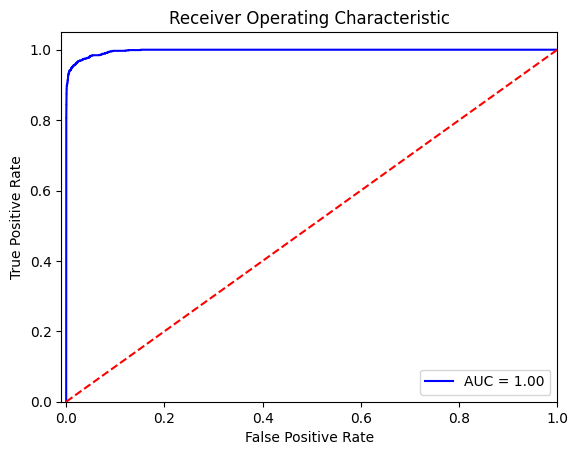

El valor de AUC para el modelo GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2) es:
0.9972403083493546 

.......................................................................................... 



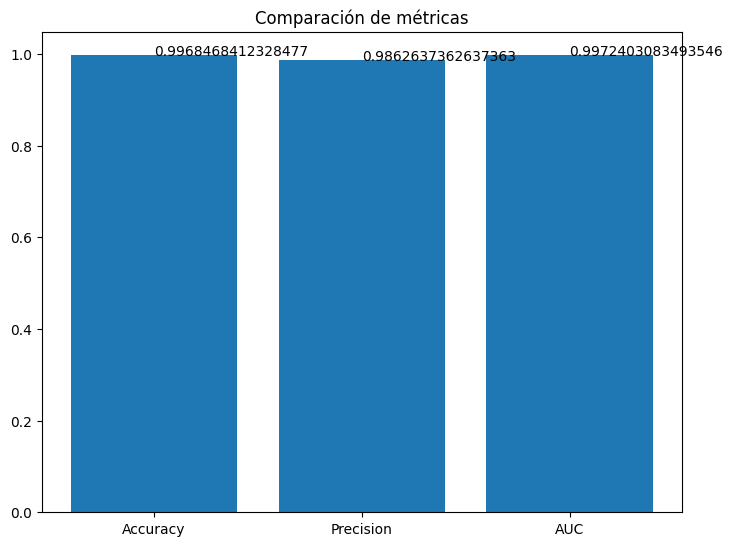

In [67]:
error_rf_test, accuracy_rf_test, precision_rf_test, AUC_rf_test, F1_rf_test = metricas_desempeño(XTest_Final, yTest, grid_search_RF)

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2) en la muestra de test es:
0.00251044237199412 

.......................................................................................... 

[[184968      7]
 [   463   1780]] 

.......................................................................................... 

El valor de accuracy para el modelo GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estim

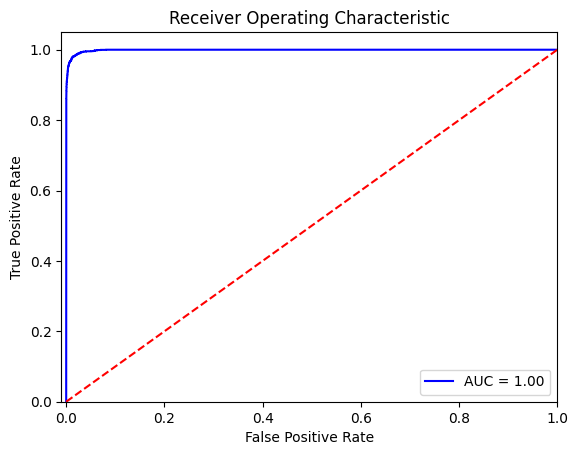

El valor de AUC para el modelo GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [100, 200],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2) es:
0.9989703395833094 

.......................................................................................... 



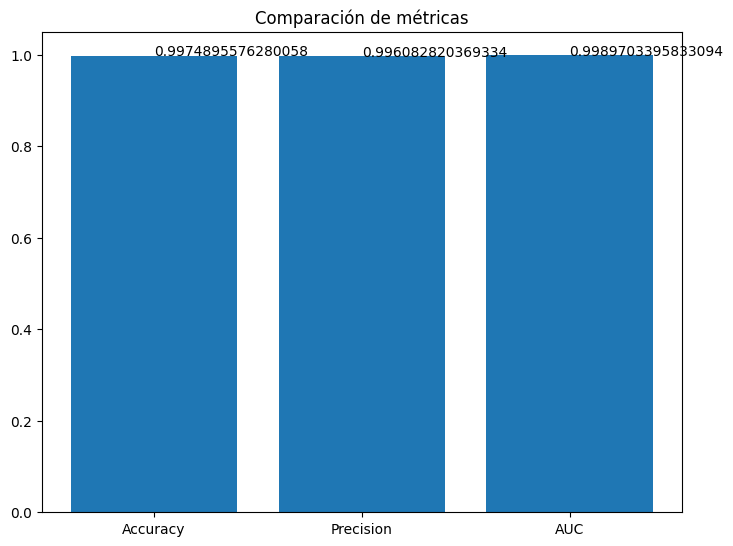

In [68]:
error_rf_train, accuracy_rf_train, precision_rf_train, AUC_rf_train, F1_rf_train = metricas_desempeño(XTrain_Final, yTrain, grid_search_RF)

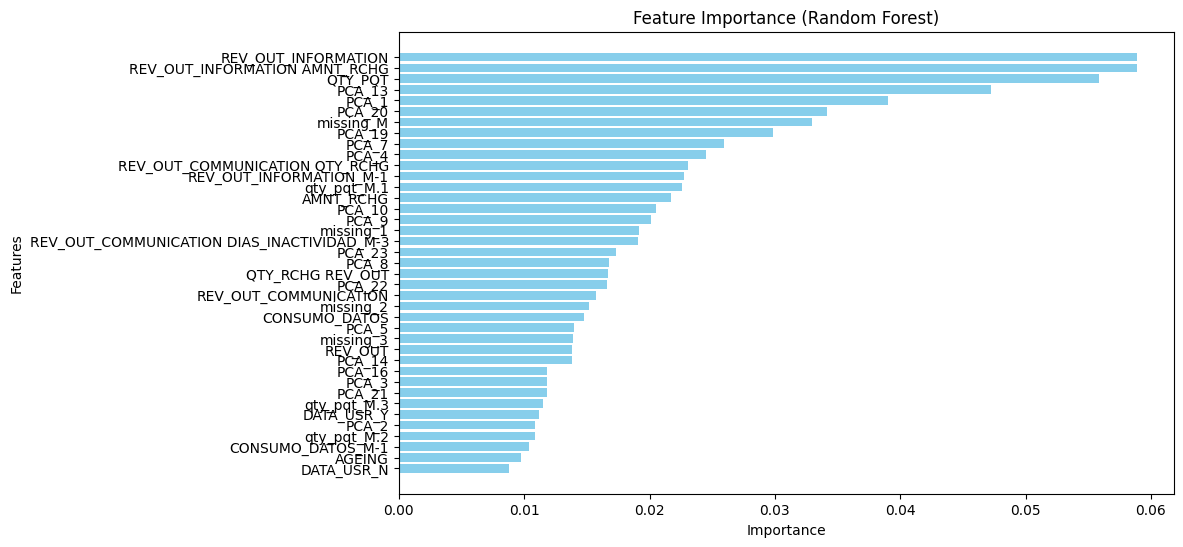

In [69]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_RF.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_Final.columns if isinstance(XTrain_Final, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_RF = importance_df[importance_df['Importance'] >= corte]
selvars_RF = selvars_RF['Feature'].tolist()

importance_df_red_RF = importance_df[importance_df['Feature'].isin(selvars_RF)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red_RF["Feature"], importance_df_red_RF["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

## Bagging

In [70]:
# Definir el modelo base
base_estimator = DecisionTreeClassifier()

# Configurar el BaggingClassifier
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42)

# Rango de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [80, 100],
    'estimator__max_depth': [5, 10],
    'max_samples': [0.7, 1.0],
    'max_features': [0.7, 1.0],
    'bootstrap': [False]
}

# Configurar GridSearchCV
grid_search_bagg = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=4, scoring='recall', verbose=2, n_jobs=-1)

# Ajustar el modelo
grid_search_bagg.fit(XTrain_Final, yTrain)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_split=100, n_estimators=100; total time=  22.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=200, n_estimators=100; total time=  19.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=200, n_estimators=200; total time=  42.4s
[CV] END max_depth=5, max_features=log2, min_samples_split=100, n_estimators=200; total time=  27.7s
[CV] END max_depth=5, max_features=log2, min_samples_split=200, n_estimators=200; total time=  28.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=100, n_estimators=200; total time=  51.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=200, n_estimators=200; total time=  51.6s
[CV] END max_depth=10, max_features=log2, min_samples_split=200, n_estimators=100; total time=  17.8s
[CV] END max_depth=10, max_features=log2, min_samples_split=200, n_estimators=100; total time=  16.9s
[CV] END bootstrap=False, 

GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'estimator__max_depth': [5, 10],
                         'max_features': [0.7, 1.0], 'max_samples': [0.7, 1.0],
                         'n_estimators': [80, 100]},
             scoring='recall', verbose=2)

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'estimator__max_depth': [5, 10],
                         'max_features': [0.7, 1.0], 'max_samples': [0.7, 1.0],
                         'n_estimators': [80, 100]},
             scoring='recall', verbose=2) en la muestra de test es:
0.0020439448134900416 

.......................................................................................... 

[[79224    52]
 [  112   849]] 

.......................................................................................... 

El valor de accuracy para el modelo GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         

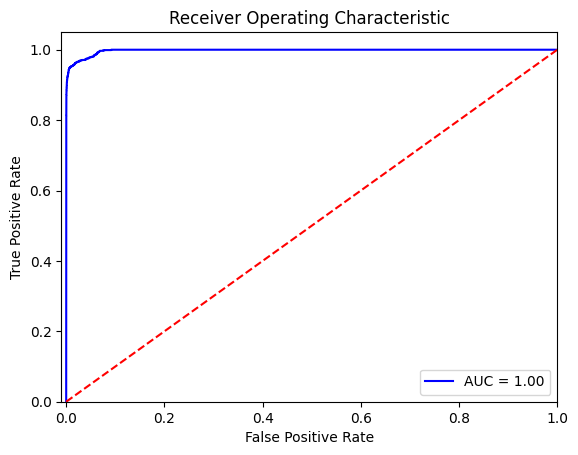

El valor de AUC para el modelo GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'estimator__max_depth': [5, 10],
                         'max_features': [0.7, 1.0], 'max_samples': [0.7, 1.0],
                         'n_estimators': [80, 100]},
             scoring='recall', verbose=2) es:
0.9976890757295249 

.......................................................................................... 



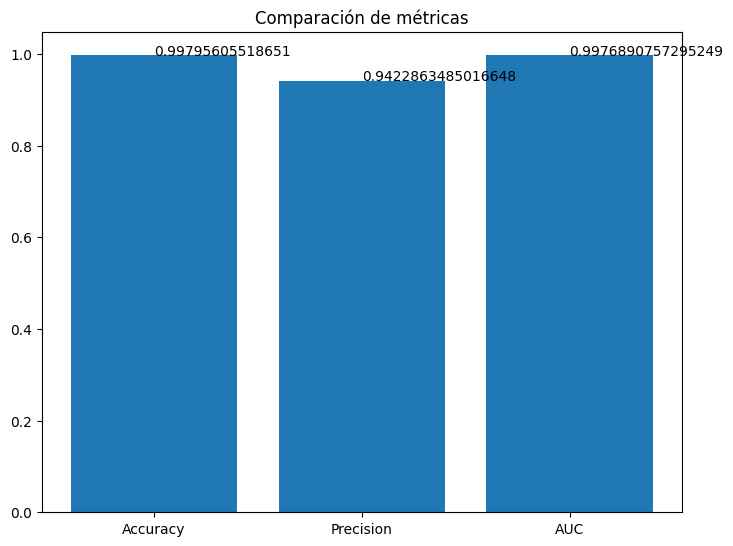

In [71]:
error_bag_test, accuracy_bag_test, precision_bag_test, AUC_bag_test, F1_bag_test = metricas_desempeño(XTest_Final, yTest, grid_search_bagg)

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'estimator__max_depth': [5, 10],
                         'max_features': [0.7, 1.0], 'max_samples': [0.7, 1.0],
                         'n_estimators': [80, 100]},
             scoring='recall', verbose=2) en la muestra de test es:
0.001319317586984153 

.......................................................................................... 

[[184899     76]
 [   171   2072]] 

.......................................................................................... 

El valor de accuracy para el modelo GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                      

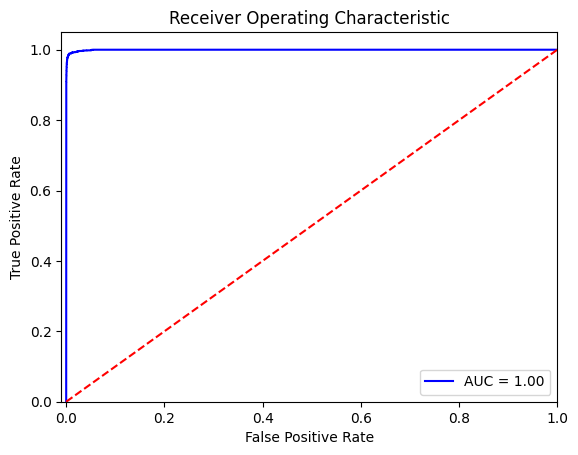

El valor de AUC para el modelo GridSearchCV(cv=4,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'estimator__max_depth': [5, 10],
                         'max_features': [0.7, 1.0], 'max_samples': [0.7, 1.0],
                         'n_estimators': [80, 100]},
             scoring='recall', verbose=2) es:
0.9995995253542777 

.......................................................................................... 



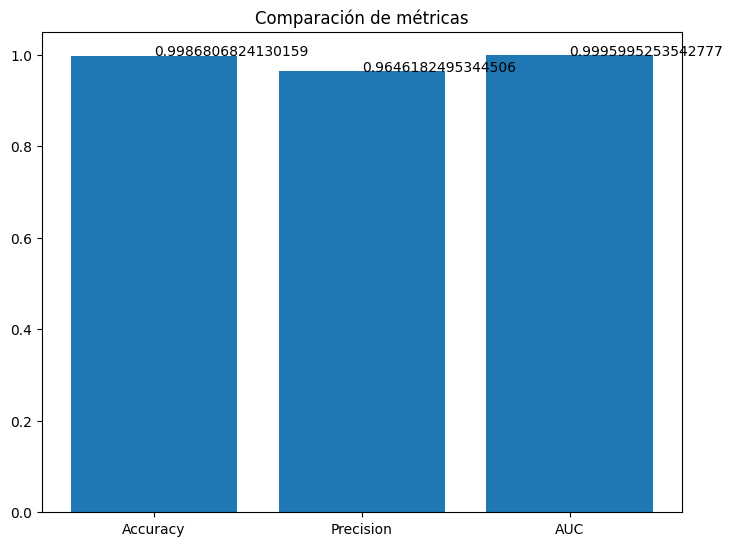

In [72]:
error_bag_train, accuracy_bag_train, precision_bag_train, AUC_bag_train, F1_bag_train = metricas_desempeño(XTrain_Final, yTrain, grid_search_bagg)

Importancia de las características: [1.27402798e-01 9.19032845e-06 4.38720441e-05 0.00000000e+00
 1.12992237e-02 1.58462789e-06 0.00000000e+00 0.00000000e+00
 2.60851156e-05 1.29482085e-02 2.16257991e-02 1.70977380e-04
 5.70747058e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.05408662e-03 3.24285756e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.54503371e-03 0.00000000e+00 6.15197692e-03
 1.78456445e-02 0.00000000e+00 2.48896567e-05 0.00000000e+00
 0.00000000e+00 1.04005530e-02 2.91961660e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.79737522e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.38330645e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.58993141e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

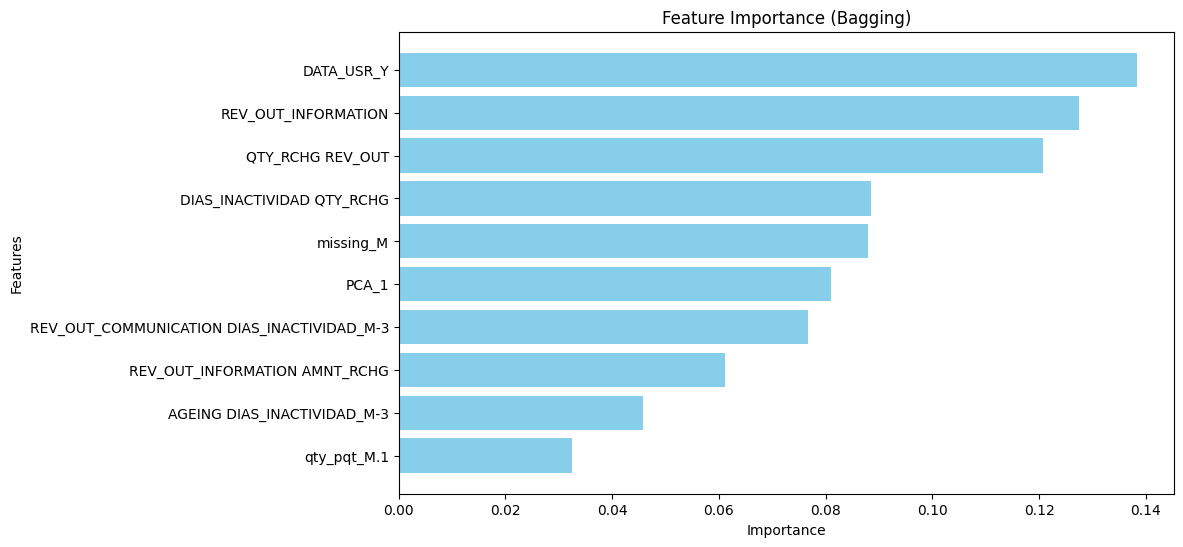

In [73]:
# Extraer importancias desde el modelo base
base_model = best_lgbm_model.estimators_[0]  # Tomar el primer estimador del Bagging

# Verificar si el modelo base tiene feature_importances_
if hasattr(base_model, "feature_importances_"):
    feature_importances = base_model.feature_importances_
    print("Importancia de las características:", feature_importances)
else:
    print("❌ El modelo base no tiene feature_importances_.")

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_Final.columns if isinstance(XTrain_Final, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_Bagg = importance_df[importance_df['Importance'] >= corte]
selvars_Bagg = selvars_Bagg['Feature'].tolist()

importance_df_red_bgg = importance_df[importance_df['Feature'].isin(selvars_Bagg)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red_bgg["Feature"], importance_df_red_bgg["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Bagging)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

## LightGBM

In [74]:
# Guardar nombres originales de las columnas
nombres_originales = XTrain_Final.columns.tolist()

# Crear un DataFrame a partir de la lista nombres_originales
df_nombres = pd.DataFrame(nombres_originales, columns=['Nombre'])

# Agregar una columna 'Col_Indice' con números del 0 al total de columnas
df_nombres['Feature'] = range(len(XTrain_Final.columns))

XTrain_Final_C = XTrain_Final.copy()
XTest_Final_C = XTest_Final.copy()

# Asegúrate de que las longitudes coincidan
if len(df_nombres) == len(XTrain_Final_C.columns):
    # Reemplazar 'Col_Indice' con los nombres de las columnas de XTrain_mod_arbol
    XTrain_Final_C.columns = df_nombres['Feature']
else:
    print("Error: Las longitudes de df_nombres y las columnas de XTrain_Final_C no coinciden.")

# Asegúrate de que las longitudes coincidan
if len(df_nombres) == len(XTest_Final_C.columns):
    # Reemplazar 'Col_Indice' con los nombres de las columnas de XTrain_mod_arbol
    XTest_Final_C.columns = df_nombres['Feature']
else:
    print("Error: Las longitudes de df_nombres y las columnas de XTest_Final_C no coinciden.")

In [75]:
#Ejecución de un modelo LightGBM para encontrar las mejores variables numericas

model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1) 

param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],  # Reducir combinaciones aquí
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 100]  # Usar menos estimadores
}

grid_search_lgbm_t = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=5,
    n_jobs=4,
    verbose=1,
    n_iter=10
)

# Entrenar el modelo 
grid_search_lgbm_t.fit(XTrain_Final_C, yTrain)

[CV] END max_depth=5, max_features=sqrt, min_samples_split=100, n_estimators=200; total time=  41.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=200, n_estimators=200; total time=  41.2s
[CV] END max_depth=5, max_features=log2, min_samples_split=100, n_estimators=200; total time=  28.7s
[CV] END max_depth=5, max_features=log2, min_samples_split=200, n_estimators=200; total time=  27.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=100, n_estimators=100; total time=  25.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=200, n_estimators=100; total time=  24.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=200, n_estimators=200; total time=  51.2s
[CV] END max_depth=10, max_features=log2, min_samples_split=100, n_estimators=200; total time=  35.0s
[CV] END max_depth=10, max_features=log2, min_samples_split=200, n_estimators=200; total time=  25.6s
[CV] END bootstrap=False, estimator__max_depth=5, max_features=0.7, max_samples=0.7, n

Python(8368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1)

.......................................................................................... 

El error de clasificación para RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) en la muestra de test es:
0.0015329586101175303 

.......................................................................................... 

[[79243    33]
 [   90   871]] 

.......................................................................................... 

El valor de accuracy para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
            

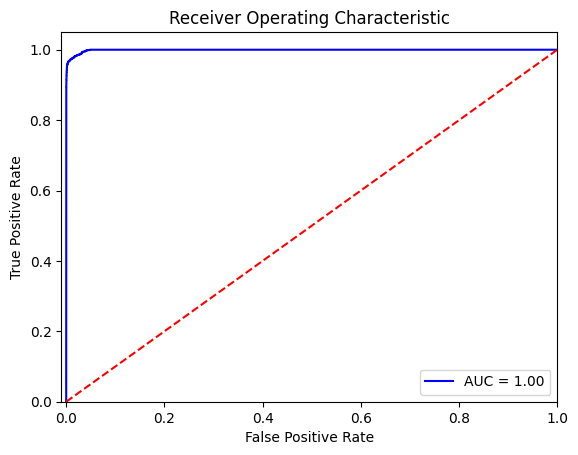

El valor de AUC para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) es:
0.9991461750696037 

.......................................................................................... 



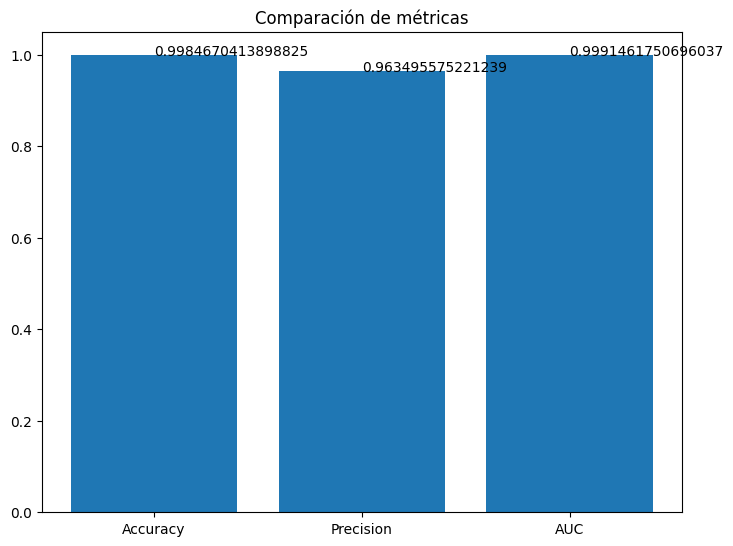

In [76]:
error_LGBM_test, accuracy_LGBM_test, precision_LGBM_test, AUC_LGBM_test, F1_LGBM_test = metricas_desempeño(XTest_Final_C, yTest, grid_search_lgbm_t)

.......................................................................................... 

El error de clasificación para RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) en la muestra de test es:
0.00015489963571878776 

.......................................................................................... 

[[184975      0]
 [    29   2214]] 

.......................................................................................... 

El valor de accuracy para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
       

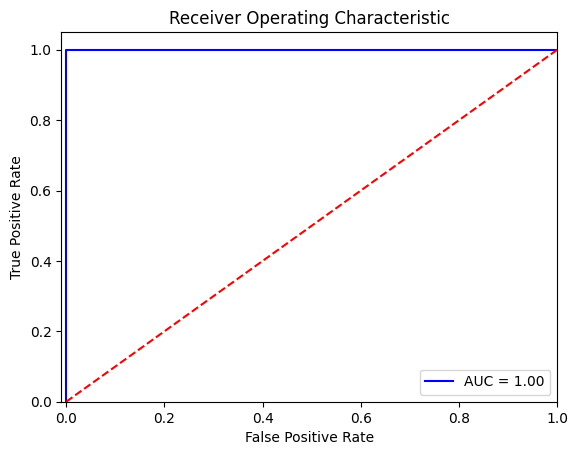

El valor de AUC para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) es:
0.99999985297624 

.......................................................................................... 



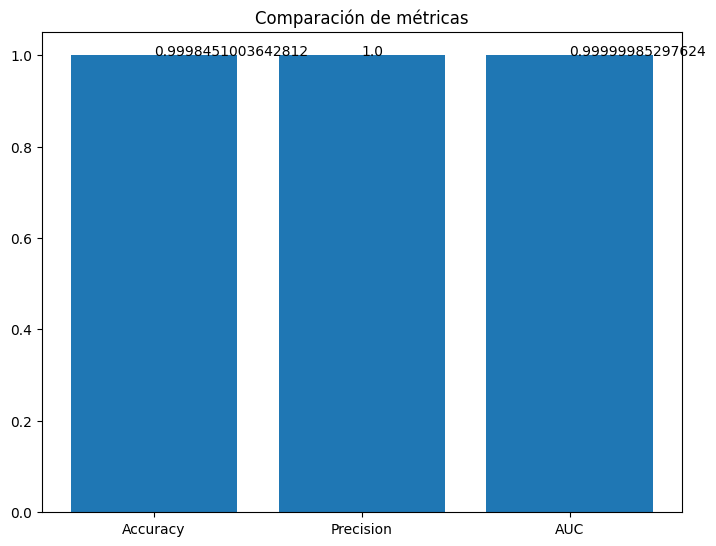

In [77]:
error_LGBM_train, accuracy_LGBM_train, precision_LGBM_train, AUC_LGBM_train, F1_LGBM_train = metricas_desempeño(XTrain_Final_C, yTrain, grid_search_lgbm_t)

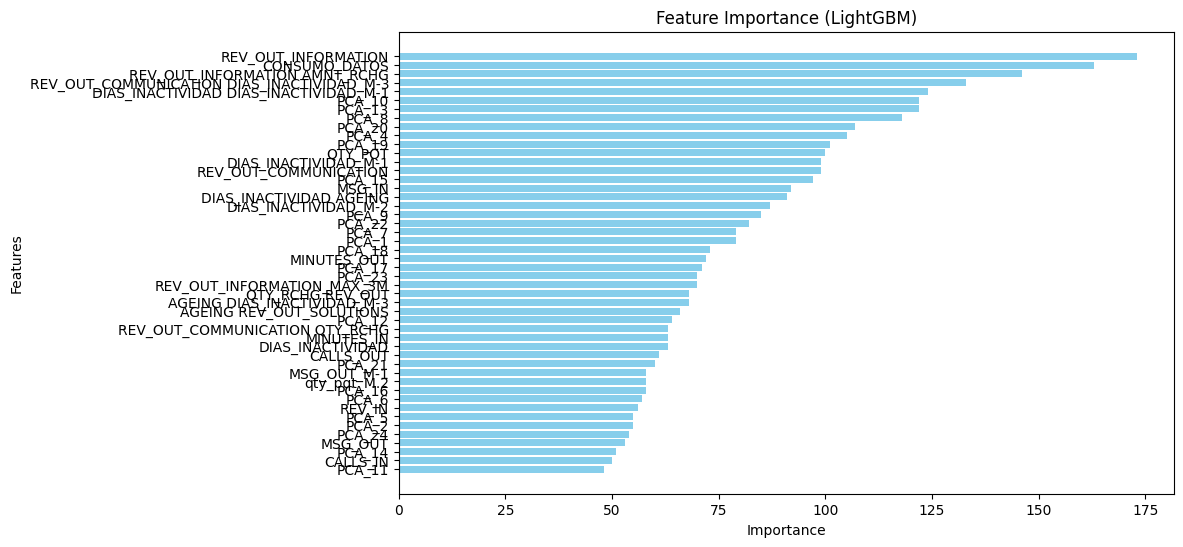

In [78]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_t.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_Final_C.columns if isinstance(XTrain_Final_C, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

importance_df = importance_df.merge(df_nombres, on = 'Feature', how = 'left')
corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_lgbm_t = importance_df[importance_df['Importance'] >= corte]
selvars_lgbm_t = selvars_lgbm_t['Nombre'].tolist()

importance_df_red_LGBM = importance_df[importance_df['Nombre'].isin(selvars_lgbm_t)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red_LGBM["Nombre"], importance_df_red_LGBM["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()


## XGBoost

In [79]:
# Definir modelo XGBoost
xgb_model = xgb.XGBClassifier(eval_metric="logloss")

# Definir el grid de hiperparámetros
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.2],
    "subsample": [0.7, 1.0]
}

# Aplicar GridSearchCV
grid_search_XGBoost = GridSearchCV(xgb_model, param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_search_XGBoost.fit(XTrain_Final, yTrain)

Python(8388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.7, 1.0]},
             scoring='recall')

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     m

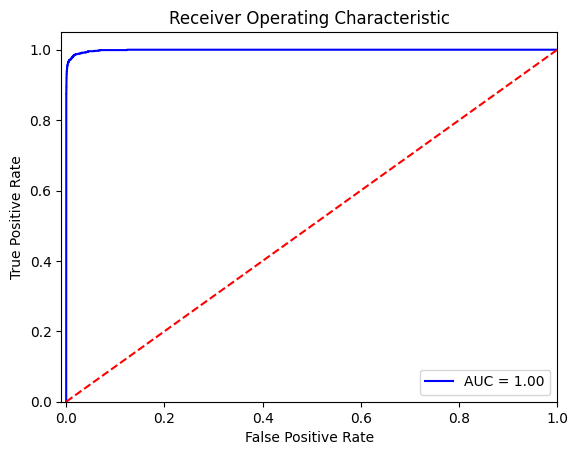

El valor de AUC para el modelo GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min

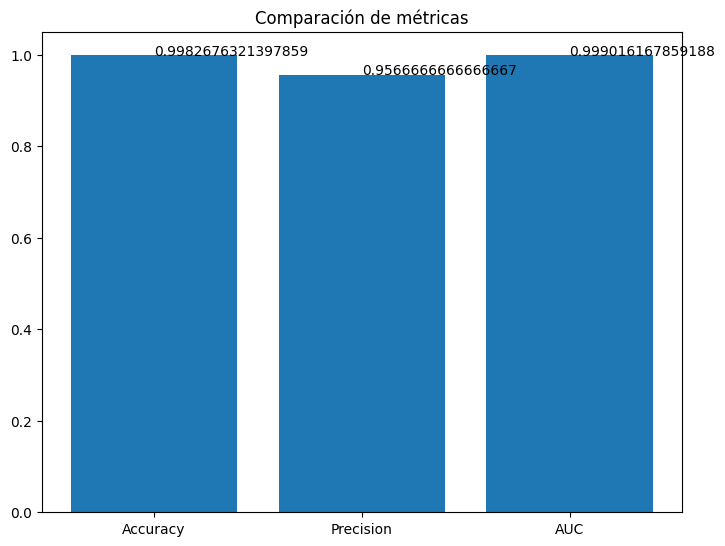

In [80]:
error_XGB_test, accuracy_XGB_test, precision_XGB_test, AUC_XGB_test, F1_XGB_test = metricas_desempeño(XTest_Final, yTest, grid_search_XGBoost)

.......................................................................................... 

El error de clasificación para GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     m

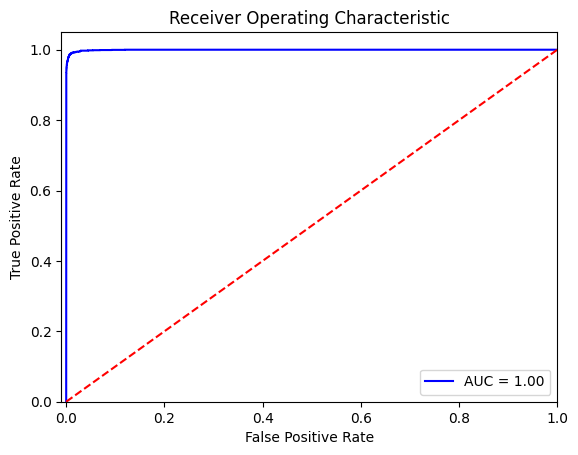

El valor de AUC para el modelo GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min

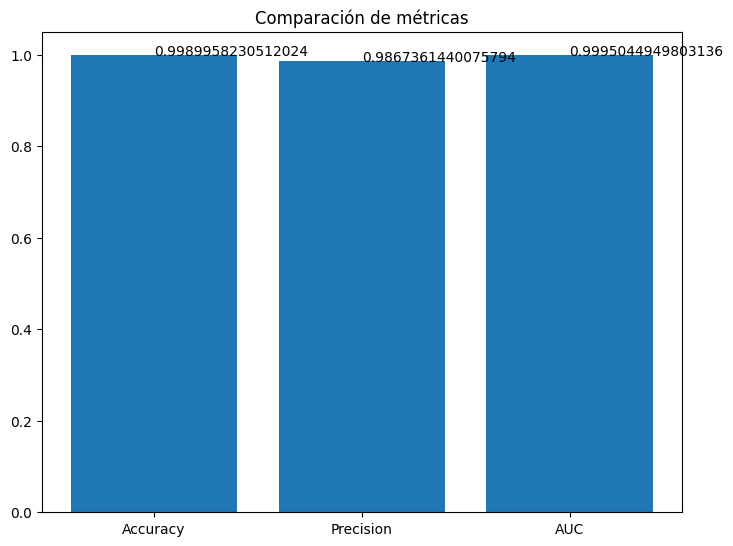

In [81]:
error_XGB_train, accuracy_XGB_train, precision_XGB_train, AUC_XGB_train, F1_XGB_train = metricas_desempeño(XTrain_Final, yTrain, grid_search_XGBoost)

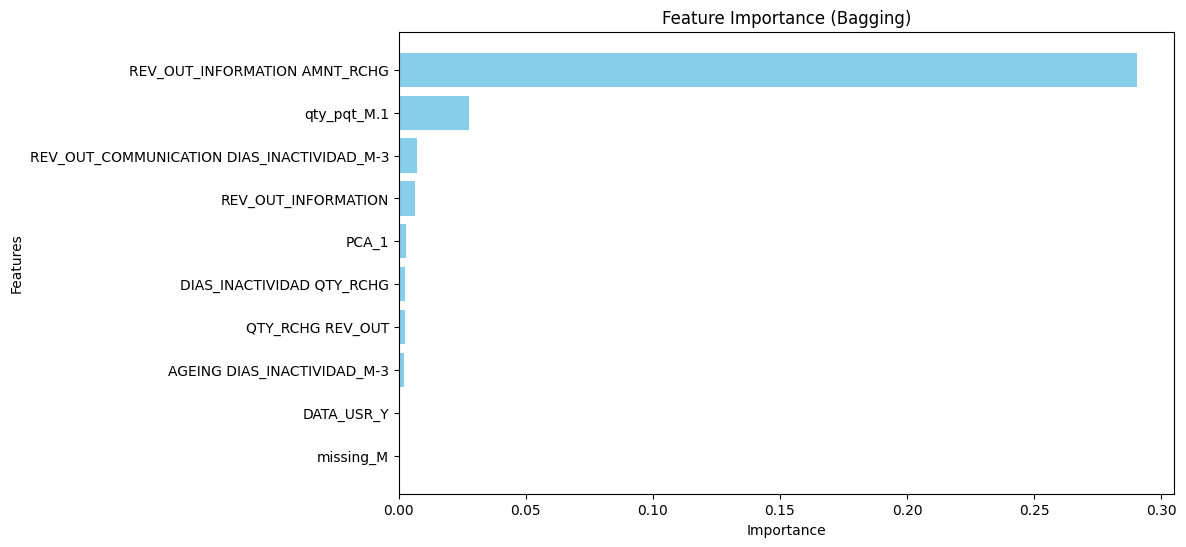

In [82]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_XGBoost.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_Final.columns if isinstance(XTrain_Final, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_XGB = importance_df[importance_df['Importance'] >= corte]
selvars_XGB = selvars_XGB['Feature'].tolist()

importance_df_red_XGB = importance_df[importance_df['Feature'].isin(selvars_Bagg)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red_XGB["Feature"], importance_df_red_XGB["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Bagging)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

## Selección del mejor modelo

In [83]:
# Comparación de modelos

vars_sel_df = pd.DataFrame({
    "Modelo": ['Random Forest', 'Bagging', 'LightGBM', 'XGBoost'],
    "Accuracy_Train": [accuracy_rf_train, accuracy_bag_train, accuracy_LGBM_train, accuracy_XGB_train],
    "Accuracy_Test": [accuracy_rf_test, accuracy_bag_test, accuracy_LGBM_test, accuracy_XGB_test],
    "Precision_Train": [precision_rf_train, precision_bag_train, precision_LGBM_train, precision_XGB_train],
    "Precision_Test": [precision_rf_test, precision_bag_test, precision_LGBM_test, precision_XGB_test],
    "AUC_Train": [AUC_rf_train, AUC_bag_train, AUC_LGBM_train, AUC_XGB_train],
    "AUC_Test": [AUC_rf_test, AUC_bag_test, AUC_LGBM_test, AUC_XGB_test],
    "F1-Score_Train": [F1_rf_train, F1_bag_train, F1_LGBM_train, F1_XGB_train],
    "F1-Score_Test": [F1_rf_test, F1_bag_test, F1_LGBM_test, F1_XGB_test]
})

vars_sel_df

,Modelo,Accuracy_Train,Accuracy_Test,Precision_Train,Precision_Test,AUC_Train,AUC_Test,F1-Score_Train,F1-Score_Test
0,Random Forest,0.997490,0.996847,0.996083,0.986264,0.998970,0.997240,0.883375,0.850207
1,Bagging,0.998681,0.997956,0.964618,0.942286,0.999600,0.997689,0.943749,0.911923
2,LightGBM,0.999845,0.998467,1.000000,0.963496,1.000000,0.999146,0.993493,0.934048
3,XGBoost,0.998996,0.998268,0.986736,0.956667,0.999504,0.999016,0.956821,0.925309


In [84]:
importance_df_red_LGBM

,Feature,Importance,Nombre
0,0,173,REV_OUT_INFORMATION
1,1,163,CONSUMO_DATOS
2,115,146,REV_OUT_INFORMATION AMNT_RCHG
3,123,133,REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3
4,116,124,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1
5,100,122,PCA_10
6,103,122,PCA_13
7,98,118,PCA_8
8,110,107,PCA_20
9,94,105,PCA_4


# CREACIÓN MEJOR MODELO CON LAS MEJORES VARIABLES

In [85]:
Vars_LGBM_MostImp = importance_df_red_LGBM['Nombre'].to_list()
XTrain_Final_Red = XTrain_Final[Vars_LGBM_MostImp]
XTest_Final_Red = XTest_Final[Vars_LGBM_MostImp]

In [86]:
# Clasificar con el modelo seleccionado y el conjunto de variables más importantes
model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1) 

param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],  # Reducir combinaciones aquí
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 100]  # Usar menos estimadores
}

grid_search_lgbm_t2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=5,
    n_jobs=4,
    verbose=1,
    n_iter=10
)

# Entrenar el modelo 
grid_search_lgbm_t2.fit(XTrain_Final_Red, yTrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Python(8409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(8412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1)

.......................................................................................... 

El error de clasificación para RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) en la muestra de test es:
0.0016700524695589362 

.......................................................................................... 

[[79247    29]
 [  105   856]] 

.......................................................................................... 

El valor de accuracy para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
            

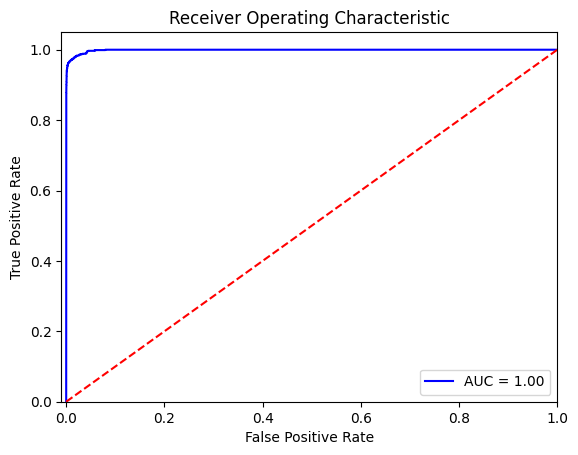

El valor de AUC para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) es:
0.998931347162161 

.......................................................................................... 



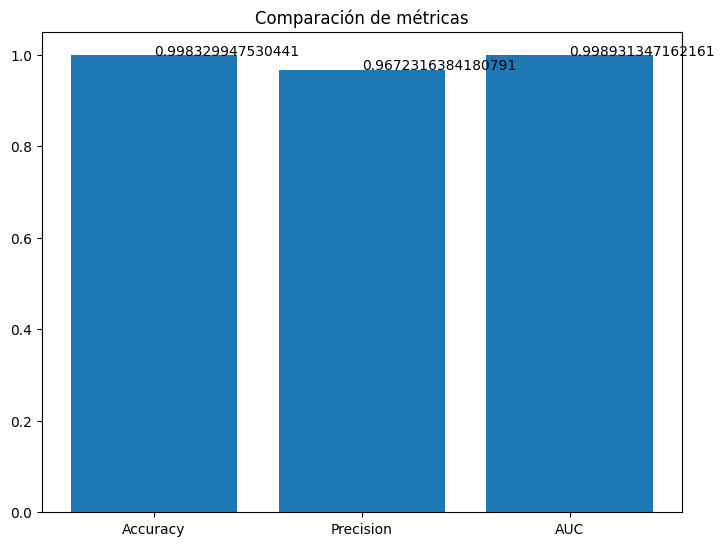

In [87]:
error_LGBM_test, accuracy_LGBM_test, precision_LGBM_test, AUC_LGBM_test, F1_LGBM_test = metricas_desempeño(XTest_Final_Red, yTest, grid_search_lgbm_t2)

.......................................................................................... 

El error de clasificación para RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) en la muestra de test es:
0.0005127712078966774 

.......................................................................................... 

[[184967      8]
 [    88   2155]] 

.......................................................................................... 

El valor de accuracy para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
        

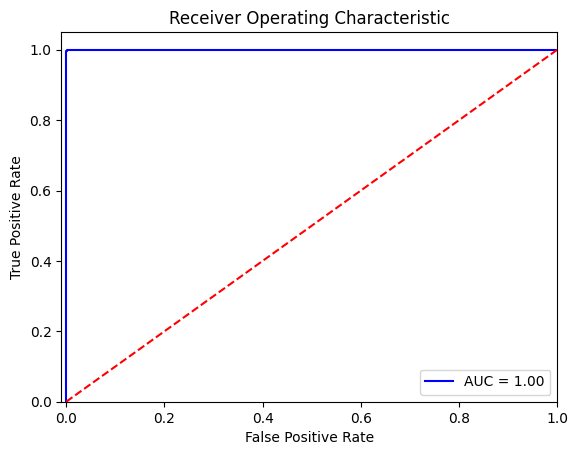

El valor de AUC para el modelo RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(force_row_wise=True, verbose=-1),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.05],
                                        'max_depth': [-1, 10],
                                        'n_estimators': [50, 100],
                                        'num_leaves': [31, 50]},
                   verbose=1) es:
0.9999890744474693 

.......................................................................................... 



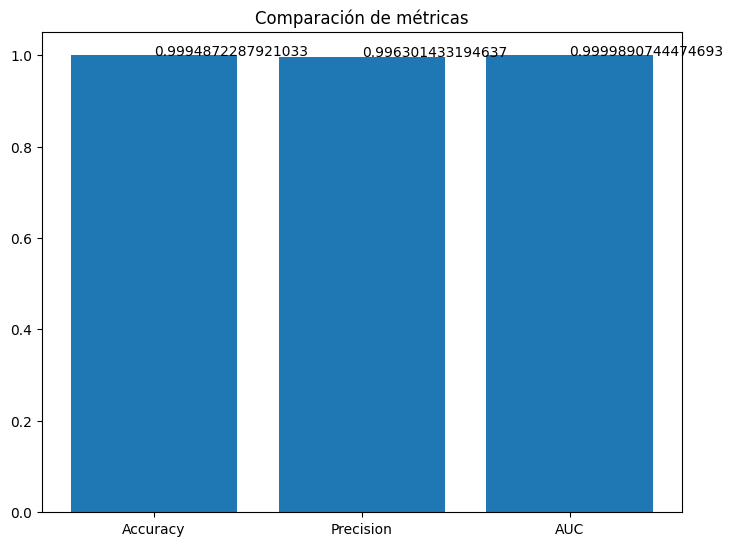

In [88]:
error_LGBM_train, accuracy_LGBM_train, precision_LGBM_train, AUC_LGBM_train, F1_LGBM_train = metricas_desempeño(XTrain_Final_Red, yTrain, grid_search_lgbm_t2)

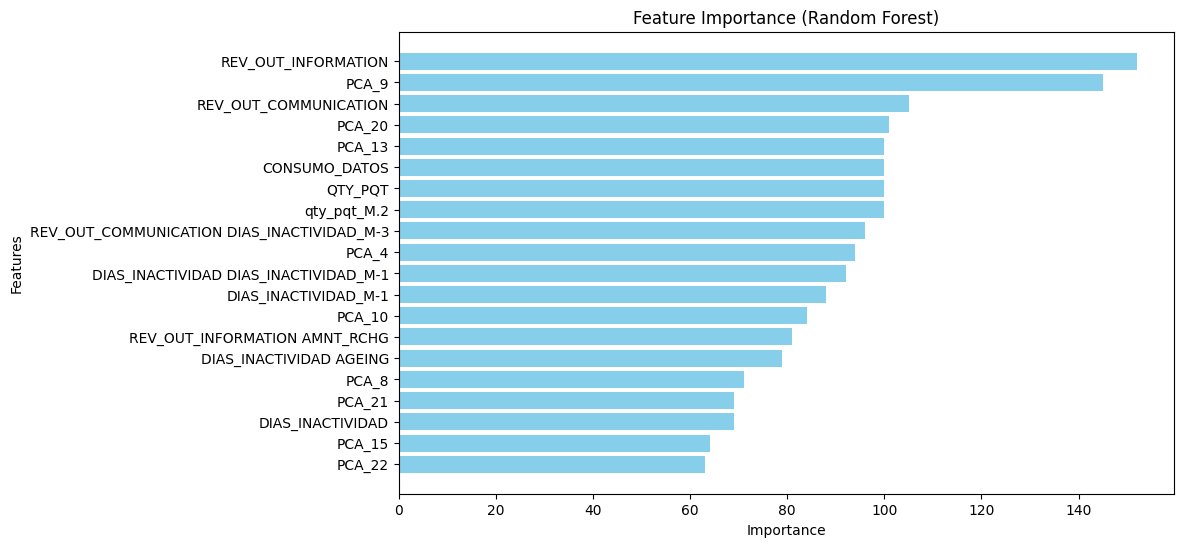

In [89]:
# Obtener el modelo óptimo ajustado por GridSearchCV
best_lgbm_model = grid_search_lgbm_t2.best_estimator_

# Extraer las importancias de las características
feature_importances = best_lgbm_model.feature_importances_

# Suponiendo que tienes una lista de nombres de las características
feature_names = XTrain_Final_Red.columns if isinstance(XTrain_Final_Red, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

# Crear un DataFrame para ordenar y visualizar
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

corte = (importance_df[importance_df['Importance'] != 0]['Importance']).mean()

selvars_LGBM_Red = importance_df[importance_df['Importance'] >= corte]
selvars_LGBM_Red = selvars_LGBM_Red['Feature'].tolist()

importance_df_red_LGBM = importance_df[importance_df['Feature'].isin(selvars_LGBM_Red)]

# Visualizar con un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df_red_LGBM["Feature"], importance_df_red_LGBM["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Invertir el eje para mostrar la más importante arriba
plt.show()

In [90]:
selvars_LGBM_Red

['REV_OUT_INFORMATION',
 'PCA_9',
 'REV_OUT_COMMUNICATION',
 'PCA_20',
 'PCA_13',
 'CONSUMO_DATOS',
 'QTY_PQT',
 'qty_pqt_M.2',
 'REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3',
 'PCA_4',
 'DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1',
 'DIAS_INACTIVIDAD_M-1',
 'PCA_10',
 'REV_OUT_INFORMATION AMNT_RCHG',
 'DIAS_INACTIVIDAD AGEING',
 'PCA_8',
 'PCA_21',
 'DIAS_INACTIVIDAD',
 'PCA_15',
 'PCA_22']

In [91]:
# Guardar el mejor modelo encontrado por GridSearchCV
best_lgbm_model = grid_search_lgbm_t2.best_estimator_
joblib.dump(best_lgbm_model, "best_model.pkl")

print("✅ Modelo guardado correctamente como 'best_model.pkl'")

✅ Modelo guardado correctamente como 'best_model.pkl'


# ANALISIS ADICIONALES

In [92]:
modelo = grid_search_lgbm_t2

predicciones=modelo.predict(XTrain_Final_Red)
prediccionesProb=modelo.predict_proba(XTrain_Final_Red)
XTrain_Final_prob = XTrain_Final_Red.copy()
XTrain_Final_prob['Pred'] = predicciones
XTrain_Final_prob['Pred_prob'] = prediccionesProb[:, 1]
XTrain_Final_prob

,REV_OUT_INFORMATION,CONSUMO_DATOS,REV_OUT_INFORMATION AMNT_RCHG,REV_OUT_COMMUNICATION DIAS_INACTIVIDAD_M-3,DIAS_INACTIVIDAD DIAS_INACTIVIDAD_M-1,PCA_10,PCA_13,PCA_8,PCA_20,PCA_4,PCA_19,QTY_PQT,DIAS_INACTIVIDAD_M-1,REV_OUT_COMMUNICATION,PCA_15,MSG_IN,DIAS_INACTIVIDAD AGEING,DIAS_INACTIVIDAD_M-2,PCA_9,PCA_22,PCA_7,PCA_1,PCA_18,MINUTES_OUT,PCA_17,PCA_23,REV_OUT_INFORMATION_MAX_3M,QTY_RCHG REV_OUT,AGEING DIAS_INACTIVIDAD_M-3,AGEING REV_OUT_SOLUTIONS,PCA_12,REV_OUT_COMMUNICATION QTY_RCHG,MINUTES_IN,DIAS_INACTIVIDAD,CALLS_OUT,PCA_21,MSG_OUT_M-1,qty_pqt_M.2,PCA_16,PCA_6,REV_IN,PCA_5,PCA_2,PCA_24,MSG_OUT,PCA_14,CALLS_IN,PCA_11,Pred,Pred_prob
486583,0.091312,0.000861,0.008494,0.000052,1.457904e-07,-0.013643,0.000041,0.006006,-0.005765,0.034773,-0.005057,0.073171,0.000382,0.133406,-0.009346,0.000232,0.000002,0.000386,-0.003267,0.001058,0.009858,-0.142889,-0.016217,0.021934,-0.003894,0.001503,0.000000,0.008773,0.000002,0.000011,0.024131,0.007847,0.004045,0.000382,0.037955,-0.000766,0.000000,0.000000,0.000443,-0.001433,0.004027,0.018073,-0.030052,0.012571,0.000484,-0.005924,0.007775,-0.007928,0,0.000081
302956,0.099838,0.003810,0.010282,0.000053,1.457904e-07,0.005834,-0.004297,0.101311,-0.005125,0.140559,0.001321,0.219512,0.000382,0.134338,-0.006263,0.000463,0.000057,0.000772,-0.021369,-0.000471,0.014669,0.026565,-0.017125,0.000040,-0.007605,-0.000545,0.104784,0.027752,0.000058,0.000000,-0.022374,0.023707,0.000669,0.000382,0.000225,0.009887,0.000224,0.071429,-0.007402,-0.040968,0.000175,0.040272,0.182054,-0.001629,0.000000,0.012368,0.001944,0.007616,0,0.000081
436023,0.151364,0.066838,0.023635,0.000340,5.831617e-07,0.000363,-0.002434,-0.026709,-0.001375,-0.058391,0.007018,0.073171,0.000764,0.144983,-0.003529,0.000000,0.000037,0.000386,-0.018051,0.004621,-0.008009,-0.086670,-0.000859,0.000721,-0.000587,-0.000414,0.078126,0.012430,0.000113,0.000000,-0.041483,0.008528,0.000412,0.000764,0.003041,-0.000224,0.002687,0.000000,0.001742,-0.041934,0.000217,0.018967,0.134699,-0.000512,0.000000,-0.007931,0.001458,-0.024008,0,0.000081
195054,0.041868,0.019827,0.001808,0.000096,1.457904e-07,0.009705,-0.011344,-0.006276,-0.011422,-0.022159,-0.007750,0.048780,0.000382,0.122357,-0.001326,0.000000,0.000069,0.000386,-0.007151,0.005266,-0.051063,0.040543,0.000367,0.010876,-0.008053,-0.001438,0.052082,0.003782,0.000141,0.000000,-0.035058,0.004798,0.085244,0.000382,0.010925,-0.004739,0.005822,0.000000,-0.019619,0.084101,0.085261,-0.010982,-0.039213,0.004319,0.004836,-0.001609,0.023567,0.015353,0,0.000081
295461,0.077749,0.045991,0.006199,0.000051,5.831617e-07,0.016910,-0.006675,0.015098,-0.007132,0.034591,-0.011549,0.097561,0.000764,0.129786,-0.001979,0.001390,0.000023,0.000386,0.045171,0.006278,0.046270,-0.093946,0.015620,0.027883,-0.000276,0.001855,0.117192,0.010818,0.000012,0.001379,0.030233,0.010179,0.008636,0.000764,0.056538,-0.004928,0.002687,0.119048,0.009044,0.009317,0.010169,0.010451,0.123627,0.015379,0.004836,-0.012564,0.024052,-0.045079,0,0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96899,0.099838,0.001849,0.010282,0.000053,1.457904e-07,-0.009944,-0.007194,0.015073,0.019371,-0.003816,0.028016,0.048780,0.000382,0.134338,-0.000098,0.001622,0.000221,0.000386,0.022135,-0.007388,0.024025,0.440497,-0.017509,0.045100,0.014386,-0.004022,0.065104,0.006167,0.000226,0.000000,0.002513,0.005268,0.114539,0.000382,0.022075,0.005684,0.000000,0.023810,0.042333,0.083778,0.021265,0.004340,-0.037178,-0.011178,0.000000,-0.023821,0.080175,-0.003829,0,0.000081
345289,0.086956,0.018988,0.007800,0.000154,1.457904e-07,0.003802,-0.006279,0.022569,-0.002496,-0.003115,-0.001346,0.048780,0.000382,0.131672,-0.003943,0.000695,0.000015,0.000386,0.005251,0.001538,0.038150,-0.103292,0.004563,0.002696,0.005637,-0.000652,0.065104,0.005637,0.000046,0.000000,-0.017397,0.005164,0.013517,0.000382,0.008447,-0.005482,0.004702

In [93]:
XTrain_probChurn = XTrain.merge(XTrain_Final_prob[['Pred', 'Pred_prob']], 
                                left_index=True, right_index=True)
XTrain_probChurn

,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,PQT_MAS_COMPRADO,qty_pqt_M.1,pqt_mas_comprado_M.1,qty_pqt_M.2,pqt_mas_comprado_M.2,qty_pqt_M.3,pqt_mas_comprado_M.3,ACTIVATION_CHANNEL_MOD,PQT_MAS_COMPRADO_MOD,pqt_mas_comprado_M.1_MOD,pqt_mas_comprado_M.2_MOD,pqt_mas_comprado_M.3_MOD,Pred,Pred_prob
486583,1.0,MOBILE,4G,2G,Y,N,N,N,SMARTPHONE,BOGOTA,"BOGOTÁ, D. C.",N,Y,N,3.0,0,0,0,28000.0,0.0,0.0,0.0,24398.0,0,0,0,482.0,0,0,0,23916.0,0,0,0,0,32.0,0,0,0,36.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,337.0,0,0,0,386.4,0.0,0.0,0.0,2.0,0,0,0,0.0,0.0,0.0,3614.0,0,0,0,0.0,0,0,0,20252.0,0,0,0,50.0,0,0,0,359125.6,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,0.0,0,0,0,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,0.0,MISSING,0.0,MISSING,0.0,MISSING,TIENDAS_PROPIAS,Voz Ilimitada + SMS Ilimitados Allnet + 500 MB...,MISSING,MISSING,MISSING,0,0.000081
302956,34.0,MOBILE,4G,2G,Y,Y,Y,Y,SMARTPHONE,ANDINA,ANTIOQUIA,Y,N,N,9.0,3,4,6,31000.0,12000.0,11000.0,24000.0,25949.0,10086,8274,21183,21.0,50,34,102,25928.0,10036,8240,21081,0,8.0,6,7,7,6.0,3.8,2.4,10.0,2.0,0.0,2.0,1.0,2.0,0,4,1,0.7,0.0,0.2,0.2,0.0,1,3,0,0.0,0.0,0.0,3785.0,1465,1118,2930,0.0,0,693,0,22143.0,8571,6429,17244,0.0,0,0,908,1589974.0,493643.3,1024359.0,10202423.0,CORE,CORE,CORE,CORE,0.0,0,1,0,9.0,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,6.0,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,DISTRIBUIDORES,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,0,0.000081
436023,11.0,MOBILE,4G,2G,Y,Y,N,N,SMARTPHONE,BOGOTA,"BOGOTÁ, D. C.",Y,N,N,3.0,2,0,1,47000.0,18000.0,0.0,10000.0,39336.0,15069,0,8364,26.0,14,0,0,39310.0,15055,0,8364,0,6.0,5,0,0,3.7,2.4,0.0,0.0,0.0,0.0,0.0,0.0,27.0,28,0,10,12.7,28.7,0.0,5.4,0.0,12,17,9,0.0,0.0,0.0,5738.0,2198,0,1221,0.0,0,0,0,33571.0,12857,0,7143,0.0,0,0,0,27891020.0,22129853.0,3688.6,2563748.0,CORE,CORE,NO CORE,CORE,1.0,1,0,5,3.0,Voz Ilimitada + SMS Ilimitados Allnet + 3 GB +...,2.0,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,0.0,MISSING,1.0,Voz Ilimitada + SMS Ilimitados Allnet + 3 GB +...,TIENDAS_PROPIAS,Voz Ilimitada + SMS Ilimitados Allnet + 3 GB +...,Voz Ilimitada + SMS Ilimitados Allnet + 350 MB...,MISSING,Voz Ilimitada + SMS Ilimitados Allnet + 3 GB +...,0,0.000081
195054,41.0,MOBILE,4G,2G,Y,Y,N,N,SMARTPHONE,COSTA,CESAR,Y,N,N,2.0,2,0,0,13000.0,12000.0,0.0,0.0,21077.0,13274,899,540,10204.0,3238,689,540,10873.0,10036,210,0,0,97.0,51,18,18,765.0,232.1,45.5,40.1,0.0,11.0,4.0,7.0,97.0,53,0,1,191.6,78.8,0.0,0.5,20.0,26,35,30,0.0,0.0,0.0,1587.0,1465

In [94]:
XTrain_probChurn['NUM_PQT_MISSING'] = (XTrain_probChurn[['pqt_mas_comprado_M.1', 'pqt_mas_comprado_M.2', 'pqt_mas_comprado_M.3']] == "MISSING").sum(axis=1)

In [149]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.5) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['NUM_PQT_MISSING'].value_counts()

NUM_PQT_MISSING
0    87489
3    41731
1    28877
2    26958
Name: count, dtype: int64

In [47]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 1) & (XTrain_probChurn['Pred_prob'] >= 0.5)]['NUM_PQT_MISSING'].value_counts()

NameError: name 'XTrain_probChurn' is not defined

In [131]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.5) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['PQT_MAS_COMPRADO'].value_counts()

PQT_MAS_COMPRADO
Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB + WA + FB 6d -$6000    42707
Voz Ilimitada + SMS Ilimitados Allnet + 350 MB + WA + FB 2d -$3000    35220
MISSING                                                               26160
Voz Ilimitada + SMS Ilimitados Allnet + 6 GB + WA + FB 30d -$15000    14753
Voz Ilimitada + SMS Ilimitados Allnet + 500 MB + WA + FB 5d -$3000    14281
                                                                      ...  
5 Min Offnet -$750                                                        1
50 Min + 50 SMS Allnet + 500 MB Sem -$18900                               1
Voz Ilimitado Allnet Día -$4900                                           1
10 SMS Offnet -$800                                                       1
CUG Avon -$5000                                                           1
Name: count, Length: 61, dtype: int64

In [132]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.5) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['pqt_mas_comprado_M.1'].value_counts()

pqt_mas_comprado_M.1
MISSING                                                                             60149
Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB + WA + FB 6d -$6000                  35271
Voz Ilimitada + SMS Ilimitados Allnet + 350 MB + WA + FB 2d -$3000                  28644
Voz Ilimitada + SMS Ilimitados Allnet + 6 GB + WA + FB 30d -$15000                  12504
Voz Ilimitada + SMS Ilimitados Allnet + 3 GB + WA + FB 10d -$10000                  11849
Voz Ilimitada + SMS Ilimitados Allnet + 500 MB + WA + FB 5d -$3000                   8886
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB + WA + FB 7d -$7000                     8171
Voz Ilimitada + SMS Ilimitados Allnet + 1,5 GB + WA + FB 7d ATCK -$5000              3695
Voz Ilimitada + SMS Ilimitados Allnet + 1 GB 2d -$3000                               2513
Voz Ilimitada + SMS Ilimitados Allnet + 7,5 GB + WA + FB 20d -$20000                 1824
Voz ilimitada + SMS Ilimitados  Allnet + 500 MB -$2000                         

In [133]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.5) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['pqt_mas_comprado_M.2'].value_counts()

pqt_mas_comprado_M.2
MISSING                                                                             69933
Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB + WA + FB 6d -$6000                  33746
Voz Ilimitada + SMS Ilimitados Allnet + 350 MB + WA + FB 2d -$3000                  26106
Voz Ilimitada + SMS Ilimitados Allnet + 6 GB + WA + FB 30d -$15000                  11658
Voz Ilimitada + SMS Ilimitados Allnet + 3 GB + WA + FB 10d -$10000                  11347
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB + WA + FB 7d -$7000                     7583
Voz Ilimitada + SMS Ilimitados Allnet + 500 MB + WA + FB 5d -$3000                   7457
Voz Ilimitada + SMS Ilimitados Allnet + 1,5 GB + WA + FB 7d ATCK -$5000              3193
Voz Ilimitada + SMS Ilimitados Allnet + 1 GB 2d -$3000                               2188
Voz Ilimitada + SMS Ilimitados Allnet + 7,5 GB + WA + FB 20d -$20000                 1831
Voz ilimitada + SMS Ilimitados  Allnet + 500 MB -$2000                         

In [134]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.5) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['pqt_mas_comprado_M.3'].value_counts()

pqt_mas_comprado_M.3
MISSING                                                                             77904
Voz Ilimitada + SMS Ilimitados Allnet + 1.3 GB + WA + FB 6d -$6000                  32250
Voz Ilimitada + SMS Ilimitados Allnet + 350 MB + WA + FB 2d -$3000                  24184
Voz Ilimitada + SMS Ilimitados Allnet + 3 GB + WA + FB 10d -$10000                  10978
Voz Ilimitada + SMS Ilimitados Allnet + 6 GB + WA + FB 30d -$15000                  10077
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB + WA + FB 7d -$7000                     6822
Voz Ilimitada + SMS Ilimitados Allnet + 500 MB + WA + FB 5d -$3000                   6427
Voz Ilimitada + SMS Ilimitados Allnet + 1,5 GB + WA + FB 7d ATCK -$5000              2889
Voz Ilimitada + SMS Ilimitados Allnet + 1 GB 2d -$3000                               2311
Voz Ilimitada + SMS Ilimitados Allnet + 7,5 GB + WA + FB 20d -$20000                 1720
Voz ilimitada + SMS Ilimitados  Allnet + 500 MB -$2000                         

In [137]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 1) & (XTrain_probChurn['Pred_prob'] >= 0.5)]['PQT_MAS_COMPRADO'].value_counts()

PQT_MAS_COMPRADO
MISSING                                                  2163
7 Min + 3 SMS Allnet -$1000                                 0
CUG Avon -$5000                                             0
SMS Ilim Tarifa Especial Allnet -$799                       0
SUSCRIPCION 60 Minutos + 60 SMS Allnet + 60 MB -$1000       0
                                                         ... 
50 Min + 10 SMS Allnet 2d -$3000                            0
50 Min + 50 SMS Allnet + 500 MB Sem -$18900                 0
500 Min + 500 SMS Allnet + 500 MB Mes -$20000               0
60 Minutos + 60 SMS Allnet + 60 MB -$1000                   0
65 Min + 10 SMS Allnet 2d -$4000                            0
Name: count, Length: 61, dtype: int64

In [138]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 1) & (XTrain_probChurn['Pred_prob'] >= 0.5)]['pqt_mas_comprado_M.1'].value_counts()

pqt_mas_comprado_M.1
MISSING                                                                             2161
Voz Ilimitada + SMS Ilimitados Allnet + 3 GB + WA + FB 10d -$10000                     2
Voz Ilimitada + SMS Ilimitados Allnet + 2 GB + WA + FB 7d -$7000                       0
CUG Taxis Libres -$5000                                                                0
SMS Ilim Tarifa Especial Allnet -$799                                                  0
SUSCRIPCION 60 Minutos + 60 SMS Allnet + 60 MB -$1000                                  0
SUSCRIPCION Voz Ilimitada + SMS Ilimitados Allnet + 10 GB 15d -$20000                  0
SUSCRIPCION Voz Ilimitada + SMS Ilimitados Allnet + 7,5 GB + WA + FB 20d -$20000       0
SUSRIPCION Voz Ilimitada + SMS Ilimitados Allnet + 5 GB Sem -$10000                    0
Voz Ilimitada + SMS Ilimitados Allnet + 1 GB 2d -$3000                                 0
Voz Ilimitada + SMS Ilimitados Allnet + 1,5 GB + WA + FB 7d ATCK -$5000                0


In [140]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 1) & (XTrain_probChurn['Pred_prob'] >= 0.5)]

,AGEING,BUSINESS_UNIT,TECHNOLOGY,DEVICE_TECHNOLOGY,DATA_USR,DATA_USR_M-1,DATA_USR_M-2,DATA_USR_M-3,DEVICE_TYPE,REGIONAL,DEPARTMENT,OPENING,GROSS,RECONNECTION,QTY_RCHG,QTY_RCHG_M-1,QTY_RCHG_M-2,QTY_RCHG_M-3,AMNT_RCHG,AMNT_RCHG_M-1,AMNT_RCHG_M-2,AMNT_RCHG_M-3,REV_TOTAL,REV_TOTAL_M-1,REV_TOTAL_M-2,REV_TOTAL_M-3,REV_IN,REV_IN_M-1,REV_IN_M-2,REV_IN_M-3,REV_OUT,REV_OUT_M-1,REV_OUT_M-2,REV_OUT_M-3,ARPU,CALLS_IN,CALLS_IN_M-1,CALLS_IN_M-2,CALLS_IN_M-3,MINUTES_IN,MINUTES_IN_M-1,MINUTES_IN_M-2,MINUTES_IN_M-3,MSG_IN,MSG_IN_M-1,MSG_IN_M-2,MSG_IN_M-3,CALLS_OUT,CALLS_OUT_M-1,CALLS_OUT_M-2,CALLS_OUT_M-3,MINUTES_OUT,MINUTES_OUT_M-1,MINUTES_OUT_M-2,MINUTES_OUT_M-3,MSG_OUT,MSG_OUT_M-1,MSG_OUT_M-2,MSG_OUT_M-3,PCKG_VOICE_FIXNET_M-1,PCKG_VOICE_FIXNET_M-2,PCKG_VOICE_FIXNET_M-3,REV_OUT_COMMUNICATION,REV_OUT_COMMUNICATION_M-1,REV_OUT_COMMUNICATION_M-2,REV_OUT_COMMUNICATION_M-3,REV_OUT_ENTERTAIMENT,REV_OUT_ENTERTAIMENT_M-1,REV_OUT_ENTERTAIMENT_M-2,REV_OUT_ENTERTAIMENT_M-3,REV_OUT_INFORMATION,REV_OUT_INFORMATION_M-1,REV_OUT_INFORMATION_M-2,REV_OUT_INFORMATION_M-3,REV_OUT_SOLUTIONS,REV_OUT_SOLUTIONS_M-1,REV_OUT_SOLUTIONS_M-2,REV_OUT_SOLUTIONS_M-3,CONSUMO_DATOS,CONSUMO_DATOS_M-1,CONSUMO_DATOS_M-2,CONSUMO_DATOS_M-3,CORE,CORE_M-1,CORE_M-2,CORE_M-3,DIAS_INACTIVIDAD,DIAS_INACTIVIDAD_M-1,DIAS_INACTIVIDAD_M-2,DIAS_INACTIVIDAD_M-3,QTY_PQT,PQT_MAS_COMPRADO,qty_pqt_M.1,pqt_mas_comprado_M.1,qty_pqt_M.2,pqt_mas_comprado_M.2,qty_pqt_M.3,pqt_mas_comprado_M.3,ACTIVATION_CHANNEL_MOD,PQT_MAS_COMPRADO_MOD,pqt_mas_comprado_M.1_MOD,pqt_mas_comprado_M.2_MOD,pqt_mas_comprado_M.3_MOD,Pred,Pred_prob
452150,64.0,MOBILE,4G,2G,Y,Y,Y,Y,SMARTPHONE,COSTA,CESAR,Y,N,N,4.0,2,2,2,15000.0,12000.0,12000.0,9000.0,16092.0,15001,16284,14207,3546.0,4965,6248,6680,12546.0,10036,10036,7527,0,91.0,141,151,176,265.3,371.7,455.5,442.7,8.0,8.0,9.0,11.0,189.0,204,328,113,572.4,436.2,686.5,372.7,21.0,28,17,18,0.0,0.0,0.0,1831.0,1465,1465,1099,0.0,0,0,0,10714.0,8571,8571,6429,0.0,0,0,0,4013436.0,1886196.0,3705945.0,1264804.0,CORE,CORE,CORE,CORE,0.0,0,0,0,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,FUERZA_VD,MISSING,MISSING,MISSING,MISSING,1,0.981038
191423,61.0,MOBILE,4G,2G,Y,Y,Y,Y,SMARTPHONE,COSTA,BOLÍVAR,Y,N,N,5.0,3,4,3,24300.0,10000.0,12000.0,12000.0,19022.0,7914,10682,9989,622.0,387,646,630,18400.0,7527,10036,9359,0,59.0,42,47,41,63.1,37.5,49.1,53.5,1.0,6.0,2.0,1.0,196.0,130,79,145,111.5,133.5,56.7,243.9,19.0,24,17,21,0.0,0.0,0.0,2686.0,1099,1465,1611,0.0,0,0,0,15714.0,6429,8571,7647,0.0,0,0,101,4276472.0,2331608.0,7728260.0,4696635.0,CORE,CORE,CORE,CORE,0.0,0,0,0,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,RETAIL,MISSING,MISSING,MISSING,MISSING,1,0.985698
17513,7.0,MOBILE,2G,4G,Y,N,N,N,SMARTPHONE,SUR,RISARALDA,Y,N,N,2.0,0,0,0,2000.0,0.0,0.0,0.0,1674.0,0,0,0,1.0,0,0,0,1673.0,0,0,0,0,2.0,0,0,0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,244.0,0,0,0,0.0,0,0,0,1429.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,0.0,165,134,103,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,DISTRIBUIDORES,MISSING,MISSING,MISSING,MISSING,1,0.983588
186803,7.0,MOBILE,2G,4G,Y,N,N,N,SMARTPHONE,ANDINA,ANTIOQUIA,Y,N,N,2.0,0,0,0,2000.0,0.0,0.0,0.0,1673.0,0,0,0,0.0,0,0,0,1673.0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,244.0,0,0,0,0.0,0,0,0,1429.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,CORE,NO CORE,NO CORE,NO CORE,0.0,165,134,103,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,DISTRIBUIDORES,MISSING,MISSING,MISSING,MISSING,1,0.983588
338544,4.0,MOBILE,4G,2G,Y,Y,N,N,SMARTPHONE,COSTA,ATLÁNTICO,Y,N,N,1.0,2,0,0,15000.0,20000.0,0.0,0.0,15673.0,18166,0,0,2986.0,1566,0,0,12687.0,16600,0,0,0,201.0,121,0,0,469.4,213.2,0.0,0.0,2.0,8.0,0.0,0.0,241.0,146,0,0,568.9,324.8,0.0,0.0,4.0,4,0,0,0.0,0.0,0.0,1973.0,1831,0,0,0.0,693,0,0,10714.0,14076,0,0,0.0,0,0,0,19594665.0,3681480.0,0.0,0.0,CORE,CORE,NO CORE,NO CORE,0.0,0,36,5,0.0,MISSING,0.0,MISSING,0.0,MISSING,0.0,MISSING,DISTRIBUIDORES,MISSING,MISSING,MISSING,MISSING,1,0.910460
...,...

In [125]:
mean_value = (XTrain_probChurn[XTrain_probChurn['Pred'] == 1]['DIAS_INACTIVIDAD_M-1'] * 
              XTrain_probChurn[XTrain_probChurn['Pred'] == 1]['DIAS_INACTIVIDAD']).mean()

print("✅ Media del producto:", mean_value)

✅ Media del producto: 16.5709662505779


In [126]:
mean_value = (XTrain_probChurn[XTrain_probChurn['Pred'] == 0]['DIAS_INACTIVIDAD_M-1'] * 
              XTrain_probChurn[XTrain_probChurn['Pred'] == 0]['DIAS_INACTIVIDAD']).mean()

print("✅ Media del producto:", mean_value)

✅ Media del producto: 543.8849639296426


In [127]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.1) & (XTrain_probChurn['Pred_prob'] >= 0.0)]['DIAS_INACTIVIDAD_M-1'].mean()

3.8695911022109164

In [128]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 0.9) & (XTrain_probChurn['Pred_prob'] >= 0.1)]['DIAS_INACTIVIDAD_M-1'].mean()

1.1359223300970873

In [129]:
XTrain_probChurn[(XTrain_probChurn['Pred_prob'] < 1) & (XTrain_probChurn['Pred_prob'] >= 0.9)]['DIAS_INACTIVIDAD_M-1'].mean()

3.9907120743034055